# q3dfit notebook: JWST/MIRI data of J1652

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://q3d.github.io/) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Initializing the fit](#chapter1_1)
    * [1.2. Setting up the data and models](#chapter1_2)
    * [1.3. Setting up the fitting parameters](#chapter1_3)
        * [1.3.1. Emission line parameters](#chapter1_3_1)
        * [1.3.2. Continuum parameters](#chapter1_3_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
from astropy.io import fits
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
import sys
sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'J1652/'
# prefix label for output files
gal = 'J1652'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
label='J1652'
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder:

In [4]:
# make tuples of urls and download filenames
# infile = data cube
#infile_tup=('https://rhodes.box.com/shared/static/scu2ydokah2wcqtfsh1tg2y76m75b91q.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
#from q3dfit.jnb import download_files
#infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
#infile = initdir+infile

In [5]:
infile = '../../../DATA_Reduction/MIRI_MRS_reduction/J1652_reduction/sci/stage3_l2emsm_l3emsm_OutlierOff_MRSimatchOff_masterbkg/chancube_ch1-short_s3d.fits'
cfinfile = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/input/Config_files/MIRI_J1652.cf'

### 1.1. Initializing the fit <a class="anchor" id="chapter1_1"></a>

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [6]:
from q3dfit.q3din import q3din
#q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)
q3di = q3din(infile, label, datext=1, varext=2, dqext=3, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [7]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': '../../../DATA_Reduction/MIRI_MRS_reduction/J1652_reduction/sci/stage3_l2emsm_l3emsm_OutlierOff_MRSimatchOff_masterbkg/chancube_ch1-short_s3d.fits',
 'fitrange': None,
 'label': 'J1652',
 'logfile': 'J1652/J1652-fitlog.txt',
 'name': None,
 'outdir': 'J1652/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 1,
 'varext': 2,
 'dqext': 3,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models <a class="anchor" id="chapter1_2"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.

In [8]:
hdul = fits.open(infile)
argsreadcube = {'wmapext':4, #'datext': 1, 'varext': 2, 'dqext': 3, 
                'fluxnorm': 1e-18,  #'fluxnorm': 1e-14, #1e-8, 
                'pixarea_sqas': hdul[1].header['PIXAR_A2'], #0.0025,
                #'fluxunit_in': 'Jy', 
                #'fluxunit_in':'MJy/sr', 'waveunit_in': 'micron'
               }

#q3di.argsreadcube = {'wmapext': None,
#                     'fluxunit_in': 'erg/s/cm2/Angstrom'}
q3di.argsreadcube = argsreadcube
cube = q3di.load_cube()

Size of data cube: [ 43 , 49 , 1050 ]
Wavelength range: [ 4.9004 , 5.7396 ]  micron


Let's plot a spaxel near the quasar to see how it looks. The arguments are column and row in unity-offset units. This is the region of the galaxy's spectrum containing H$\beta$ and [OIII] 4959, 5007 Å. The flux units are erg/s/cm$^2$/$\mu$m.

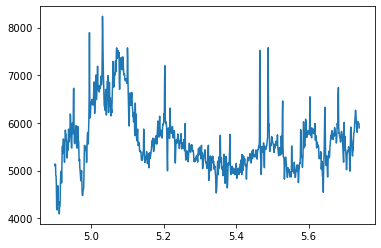

In [9]:
spec_test = cube.specextract(21,20, radius=0)

Due to the fact that JWST/NIRSpec undersamples the PSF, bright point sources create undulations in the spectrum. We apply light smoothing with a circular aperture of radius 2.5 spaxels to account for this, and then plot the result.

In [10]:
cube.convolve(2.5)

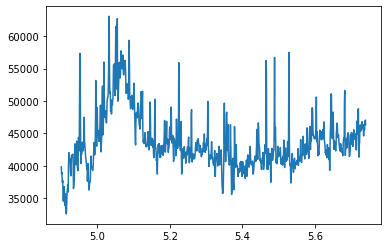

In [11]:
spec_conv = cube.specextract(21,20, radius=0)

Now we'll write this convolved cube to disk, and redefine it as our input file for the fit.

In [12]:
cube.writefits(initdir+'MIRI-J1652-conv.fits')
q3di.infile = initdir+'MIRI-J1652-conv.fits'

This time, we are going to normalize to minimize numerical issues in the fitting.

In [13]:
q3di.argsreadcube = {#'wmapext': None, 
                     #'fluxunit_in': 'erg/s/cm2/micron',
                     'fluxnorm': 1e-18}
q3di.argsreadcube = {'wmapext':4, #'datext': 1, 'varext': 2, 'dqext': 3, 
                'fluxnorm': 1e-12,  #'fluxnorm': 1e-14, #1e-8, 
                'pixarea_sqas': hdul[1].header['PIXAR_A2'], #0.0025,
                #'fluxunit_in': 'Jy', 
                #'fluxunit_in':'MJy/sr', 'waveunit_in': 'micron'
               }

cube = q3di.load_cube()
print(cube.dat[:,:,500].max())

Size of data cube: [ 43 , 49 , 1050 ]
Wavelength range: [ 4.9004 , 5.7396 ]  micron
1.8679509


Let's double-check what we have:

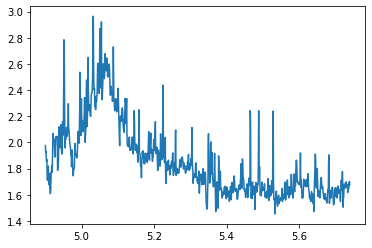

In [14]:
spec_test = cube.specextract(21,20, radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below.

In [15]:
q3di.name = 'J1652'
q3di.zsys_gas = 2.94

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [16]:
q3di.fitrange = [17.8, 20.8]
q3di.fitrange = [4.92, 5.73]
#q3di.cutrange = np.array([,])

Create quasar template from the peak spaxel. We normalize so the template flux is around unity.

makeqsotempate: using peak spaxel in white light as center


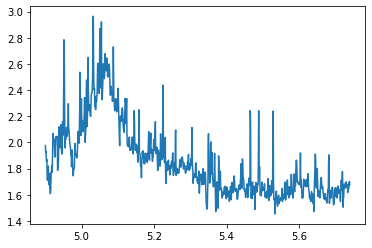

In [17]:
qsotemplate = '../q3dfit/data/questfit_templates/'+'J1652_qso.npy'
cube.makeqsotemplate(qsotemplate, radius=0.) #, norm=5e3)

### 1.3. Setting up the fitting parameters <a class="anchor" id="chapter1_3"></a>

#### 1.3.1. Emission-line parameters <a class="anchor" id="chapter1_3_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/q3dfit/data/linelists), or in `q3dfit/data/linelists/`.

In [18]:
lines = ['Pab']  # ['[NeVI]7.65'] #'H2_00_S5', '[ArII]6.99', '[NeVI]7.65']

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1. Here, we change this to 3.

In [19]:
q3di.init_linefit(lines, linetie='Pab', maxncomp=3)
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas'])

Because of the complexity of these line profiles, we change the default initial conditions. `zinit_gas` and `siginit_gas` are dictionaries of arrays that hold the initial conditions for each line, spaxel, and velocity component.

In [20]:
#for i in lines:
#    # narrow, redshifted component
#    q3di.zinit_gas[i][:,:,2] = 1.59
#    # broad, blueshifted component
#    q3di.zinit_gas[i][:,:,1] = 1.59
#    q3di.siginit_gas[i][:,:,1] = 500.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [21]:
# Global limit
q3di.siglim_gas = np.array([5., 2000.])
#q3di.siglim_gas = np.array([500., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run. The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut. Component checking can be disabled by setting `checkcomp = False`.

In [22]:
q3di.checkcomp = False
q3di.argscheckcomp['sigcut'] = 3.
#q3di.argscheckcomp['ignore']= ['Hbeta']

#### Line ratio constraints
Lines with ratios fixed by atomic physics have their ratios fixed automatically. Other line ratios can have bound constraints applied, or they can be fixed to a particular value.

`line1`, `line2`, and `comp` are required. `comp` is an array of velocity components (zero-indexed) on which to apply the constraints, one array for each pair of lines.

`value` is the initial value of `line1`/`line2`. Presently, if `value` is specified for one pair of lines, it must be specified for all. Otherwise, the initial value is determined from the data.

The ratio can be `fixed` to the initial value. Presently, if `fixed` is defined, it must be set to `True` or `False` for all pairs of line.

If the ratio is not `fixed`, `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) Presently, if `lower` or `upper` is defined here for one set of lines, it must be defined here for every pair of lines.

In [23]:
# Required columns:
# line1 = ['[NI]5198', '[SII]6716']
# line2 = ['[NI]5200', '[SII]6731']
# comp = np.array([[0], [0]], dtype=np.int32)

# Optional columns:
# value = [1.5, 1.]
# fixed = [True, False]
# lower = []
# upper = []

# Write table
# from astropy.table import QTable
# lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

# q3di.argslineinit['lineratio']=lineratio

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

This case applies to the GMOS B600 grating. Gemini website says R = 1688 at 4610 A for 0.5" slit, with IFU 0.31" eff. slit. This gives 1.69 A FWHM. I measure sometimes closer to 1.5-1.6 A.

In [24]:
#spect_instrum = {'JWST_NIRSPEC':['G235H']}
spect_instrum = {'JWST_MIRI':['CH1A']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [25]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares`
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`

In [26]:
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-10:
# q3di.argslinefit['ftol'] = 1.e-10
# q3di.argslinefit['gtol'] = 1.e-10
# q3di.argslinefit['xtol'] = 1.e-10

#### 1.3.2 Continuum parameters <a class="anchor" id="chapter1_3_2"></a>

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [27]:
do_questfit = True
if do_questfit:
    fcncontfit = 'questfit'
    argscontfit = dict()
    argscontfit['config_file'] = cfinfile
    argscontfit['outdir'] = outdir
    argscontfit['plot_decomp'] = True

In [28]:
if not do_questfit:
    #fcncontfit = 'fitqsohost'
    fcncontfit = 'fitpoly'
    q3di.init_contfit(fcncontfit)
else:
    q3di.init_contfit(fcncontfit, argscontfit=argscontfit, argscontplot={}, argsconvtemp={})
    q3di.dolinefit = True
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'argsconvtemp', 'decompose_qso_fit', 'decompose_ppxf_fit', 'dividecont', 'ebv_star', 'fcnconvtemp', 'forcefloat64', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'tweakcntfit', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. The default mask value is 500 km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

For this case, the lines are quite broad and we change the default.

In [29]:
q3di.maskwidths_def = 1000.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

In [30]:
if do_questfit:
    q3di.decompose_qso_fit = True
else:
    q3di.argscontfit['qsoxdr'] = qsotemplate
    q3di.argscontfit['qsoord'] = 2
    q3di.argscontfit['hostord'] = 2
    q3di.argscontfit['fitord'] = 3

In [31]:
if do_questfit:
    q3di.plotMIR = True

Optional arguments to `lmfit`. These are the tolerances for determining fit convergence, described in further detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).

In [32]:
#argslmfit = dict()
#argslmfit['ftol'] = 1.e-10
#argslmfit['gtol'] = 1.e-10
#argslmfit['xtol'] = 1.e-10

#q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [33]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [48]:
cols = [19]
rows = [21]

cols = [15, 23]
rows = [15, 23]

cols = [10, 30]
rows = [10, 30]

#cols = [0,35]
#rows = [0,35]

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [49]:
from q3dfit.q3df import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

Core 1: # spaxels fit=441
[col,row]=[10,10] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.03905897 (init = 1)
    template_0_multpolyB:  1.13128642 (init = 1)
    template_0_multpolyC:  1.99423690 (init = 0.1)
    blackbody250a:         5.8481e-68 (init = 0.1)
    blackbody250T:         190.561926 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0496e+06                                    5.55e+03    
       1              2         2.0478e+06      1.88e+03       3.53e+01       1.47e+03    
       2              3         2.0476e+06      1.41e+02       1.27e+01       3.50e+03    
       3              4         2.0476e+06      5.22e+01       1.82e-01       7.48e+02 

       8              9         2.3879e+06      2.84e+00       2.46e+00       1.29e+03    
       9             12         2.3879e+06      1.47e+01       2.72e-02       2.49e+03    
      10             14         2.3879e+06      5.79e+00       6.59e-03       2.16e+03    
      11             15         2.3879e+06      6.81e+00       3.07e-02       2.34e+03    
      12             16         2.3879e+06      7.42e+00       6.04e-02       9.36e+02    
      13             19         2.3879e+06      4.75e-01       8.65e-03       8.35e+02    
      14             20         2.3879e+06      5.13e-01       1.52e-02       5.61e+02    
      15             22         2.3879e+06      2.15e-01       1.73e-03       5.26e+02    
      16             23         2.3879e+06      1.09e-01       3.42e-03       4.77e+02    
      17             24         2.3879e+06      5.84e-02       6.24e-03       3.57e+02    
      18             25         2.3879e+06      1.24e-02       2.57e-03       3.20e+02    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  0.37502316 (init = 1)
    template_0_multpolyB:  1.50820105 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         4.6475e-24 (init = 0.1)
    blackbody250T:         469.716392 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7333e+06                                    1.66e+03    
       1              2         2.7333e+06      2.13e+00       1.07e-02       4.44e+02    
       2              7         2.7333e+06      4.28e-01       2.19e-02       6.26e+02    
       3              8         2.7333e+06      3.59e-01       4.04e-02       4.12e+02    
       4             10         2.7333e+06      8.41e-02       1.45e-02       1.46e+02    
   

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3112e+06                                    1.53e+03    
       1              2         2.3108e+06      4.17e+02       4.88e+01       7.25e+02    
       2              3         2.3108e+06      1.89e+01       1.43e-01       2.50e+01    
       3              4         2.3108e+06      3.61e-02       7.00e-05       2.25e+01    
       4              5         2.3108e+06      1.65e-02       8.19e-05       1.11e+01    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.3112e+06, final cost 2.3108e+06, first-order optimality 1.11e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obje

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.1465e-06 (init = 1)
    template_0_multpolyB:  1.99150218 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.9623e-16 (init = 0.1)
    blackbody250T:         2603.22368 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7275e+06                                    2.15e+03    
       1              2         1.7271e+06      3.75e+02       3.83e+01       4.05e+02    
       2              3         1.7271e+06      2.44e+00       1.74e-03       2.54e+02    
       3              4         1.7271e+06      3.06e-01       1.15e-03       1.90e+02    
       4              5         1.7271e+06      2.22e-01       2.97e-02       8.79e+01    
   

      21             30         1.6904e+06      1.45e-02       5.55e-04       3.08e+01    
`ftol` termination condition is satisfied.
Function evaluations 30, initial cost 1.6908e+06, final cost 1.6904e+06, first-order optimality 3.08e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 1013
    # variables        = 9
    chi-square         = 3380791.46
    reduced chi-square = 3367.32217
    Akaike info crit   = 8236.41723
    Bayesian info crit = 8280.70327
[[Variables]]
    Pab_0_flx:  0.03047854 +/- 6088.30289 (19975700.99%) (init = 0.03853358)
    Pab_0_cwv:  5.04929622 +/- 84.6954708 (1677.37%

      44             53         1.8525e+06      9.43e+01       2.56e-03       3.21e+05    
      45             54         1.8524e+06      3.93e+01       7.73e-03       3.22e+05    
      46             55         1.8524e+06      8.25e+01       1.55e-02       3.27e+05    
      47             56         1.8523e+06      5.56e+01       3.13e-02       3.42e+05    
      48             57         1.8522e+06      1.19e+02       1.55e-02       3.45e+05    
      49             59         1.8521e+06      8.23e+01       2.85e-03       3.38e+05    
      50             60         1.8521e+06      4.38e+01       8.66e-03       3.40e+05    
      51             61         1.8520e+06      8.76e+01       1.74e-02       3.44e+05    
      52             62         1.8518e+06      1.74e+02       3.52e-02       3.52e+05    
      53             63         1.8515e+06      3.06e+02       7.10e-02       3.73e+05    
      54             66         1.8514e+06      5.41e+01       3.75e-03       3.69e+05    

      138            168        1.8249e+06      7.00e+01       8.59e-02       7.88e+05    
      139            169        1.8247e+06      2.22e+02       3.72e-03       7.98e+05    
      140            170        1.8246e+06      7.59e+01       4.27e-02       8.04e+05    
      141            171        1.8246e+06      7.17e+01       4.46e-02       7.96e+05    
      142            172        1.8245e+06      7.54e+01       4.21e-02       8.02e+05    
      143            173        1.8244e+06      7.05e+01       4.44e-02       7.93e+05    
      144            174        1.8243e+06      7.51e+01       4.16e-02       8.00e+05    
      145            175        1.8243e+06      6.95e+01       4.43e-02       7.90e+05    
      146            176        1.8242e+06      7.49e+01       4.12e-02       7.98e+05    
      147            177        1.8241e+06      6.88e+01       4.42e-02       7.88e+05    
      148            178        1.8241e+06      7.49e+01       4.08e-02       7.96e+05    

[[Variables]]
    template_0_amp:        0.72000010 (init = 0.9)
    template_0_multpolyA:  8.3972e-07 (init = 1)
    template_0_multpolyB:  1.96557792 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.4671e-44 (init = 0.1)
    blackbody250T:         184.431818 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0706e+06                                    1.08e+04    
       1              2         2.0665e+06      4.12e+03       2.08e+01       5.78e+03    
       2              3         2.0654e+06      1.10e+03       1.15e+01       2.71e+03    
       3              4         2.0653e+06      7.80e+01       2.33e-03       2.67e+03    
       4              5         2.0652e+06      1.09e+02       9.71e-04       3.02e+03    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.0513e-05 (init = 1)
    template_0_multpolyB:  1.98757166 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         9.490e-102 (init = 0.1)
    blackbody250T:         206.109918 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2172e+06                                    8.11e+01    
       1              2         2.2172e+06      2.07e-01       1.01e-01       1.31e+02    
       2              4         2.2172e+06      3.86e-01       6.85e-02       1.30e+02    
       3              9         2.2172e+06      6.34e-03       2.87e-04       1.31e+02    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 2.2172e+06, fi

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2747e+06                                    1.16e+03    
       1              2         2.2743e+06      4.14e+02       3.63e+01       7.53e+02    
       2              4         2.2743e+06      3.04e+01       3.17e-03       1.32e+03    
       3              5         2.2743e+06      1.51e+01       1.00e-02       8.58e+02    
       4              7         2.2742e+06      7.51e+00       1.25e-03       9.06e+02    
       5              8         2.2742e+06      7.18e+00       5.20e-03       6.85e+02    
       6              9         2.2742e+06      6.50e+00       1.07e-02       2.44e+02    
       7             11         2.2742e+06      2.66e+00       7.90e-04       2.24e+02    
       8             12         2.2742e+06      4.46e-01       2.25e-03       1.46e+02    
       9             13         2.2742e+06      8.36e-01       1.47e-04       1.46e+02    

[[Variables]]
    template_0_amp:        0.72000223 (init = 0.9)
    template_0_multpolyA:  1.4605e-04 (init = 1)
    template_0_multpolyB:  1.93986703 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         7.1069e-19 (init = 0.1)
    blackbody250T:         1084.38602 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2818e+06                                    1.56e-06    
       1              2         2.2818e+06      2.54e-06       2.20e+01       2.12e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2818e+06, final cost 2.2818e+06, first-order optimality 2.12e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000100 (init = 0.9)
    template_0_multpolyA:  6.1800e-06 (init = 1)
    template_0_multpolyB:  1.97963423 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         8.2842e-43 (init = 0.1)
    blackbody250T:         226.342237 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3344e+06                                    1.03e-06    
       1              2         2.3344e+06      3.08e-06       2.20e+01       1.35e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3344e+06, final cost 2.3344e+06, first-order optimality 1.35e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72002104 (init = 0.9)
    template_0_multpolyA:  4.7891e-04 (init = 1)
    template_0_multpolyB:  1.79728499 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.4936e-19 (init = 0.1)
    blackbody250T:         1098.15696 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3322e+06                                    9.59e+02    
       1              2         2.3318e+06      3.72e+02       4.25e+01       9.90e+01    
       2              3         2.3318e+06      4.37e+01       1.95e+01       1.24e+02    
       3              9         2.3318e+06      2.24e+00       1.91e-04       6.50e+01    
       4             11         2.3318e+06      4.58e-01       9.50e-05       1.59e+01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1474e-06 (init = 1)
    template_0_multpolyB:  1.96746928 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.6908e-39 (init = 0.1)
    blackbody250T:         118.713414 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0859e+06                                    7.28e+03    
       1              2         2.0841e+06      1.80e+03       2.25e+01       1.59e+03    
       2              3         2.0840e+06      1.56e+02       1.02e+01       1.42e+02    
       3              4         2.0840e+06      1.28e+01       1.15e+01       1.09e+03    
       4              5         2.0840e+06      3.50e+00       8.79e-04       1.70e+03    
   

      89             97         2.0823e+06      3.17e-02       4.08e-04       2.85e+02    
      90             98         2.0823e+06      2.75e-02       4.90e-04       2.80e+02    
      91             99         2.0823e+06      3.06e-02       4.06e-04       2.85e+02    
      92             100        2.0823e+06      2.58e-02       4.93e-04       2.80e+02    
      93             101        2.0823e+06      2.96e-02       4.04e-04       2.84e+02    
      94             102        2.0823e+06      2.41e-02       4.96e-04       2.79e+02    
      95             103        2.0823e+06      2.86e-02       5.71e-05       2.81e+02    
      96             104        2.0823e+06      2.00e-02       2.80e-04       2.82e+02    
`ftol` termination condition is satisfied.
Function evaluations 104, initial cost 2.0859e+06, final cost 2.0823e+06, first-order optimality 2.82e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + M

      28             39         1.9799e+06      4.39e-02       2.66e-04       4.24e+00    
      29             40         1.9799e+06      7.65e-03       2.03e-04       5.81e+00    
`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 1.9823e+06, final cost 1.9799e+06, first-order optimality 5.81e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 40
    # data points      = 1013
    # variables        = 9
    chi-square         = 3959871.29
    reduced chi-square = 3944.09491
    Akaike info crit   = 8396.57423
    Bayesian info crit = 8440.86028
[[Variables]]
    Pab_0_flx:  0.20934193 +/- 21481.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5842e+06                                    3.36e+03    
       1              2         2.5831e+06      1.14e+03       3.89e+01       1.04e+03    
       2              4         2.5830e+06      9.26e+01       1.11e-03       2.25e+03    
       3              5         2.5830e+06      3.41e+01       1.73e-02       1.72e+03    
       4              6         2.5830e+06      3.91e-01       1.99e-02       1.27e+03    
       5              7         2.5829e+06      4.51e+01       1.03e-03       1.95e+03    
       6              8         2.5829e+06      2.04e+01       1.13e-02       1.10e+03    
       7              9         2.5829e+06      8.59e+00       8.98e-03       1.01e+03    
       8             10         2.5829e+06      1.24e+01       9.19e-03       4.75e+02    
       9             11         2.5829e+06      4.96e+00       2.64e-02       2.75e+02    

      24             29         2.6137e+06      7.76e-01       3.58e-04       7.45e+02    
      25             30         2.6137e+06      7.33e-01       5.67e-04       7.29e+02    
      26             31         2.6137e+06      1.41e+00       1.15e-03       7.04e+02    
      27             32         2.6137e+06      2.63e+00       2.29e-03       6.43e+02    
      28             34         2.6137e+06      8.26e-01       1.00e-03       6.35e+02    
      29             35         2.6137e+06      9.02e-01       7.79e-04       5.96e+02    
      30             36         2.6137e+06      3.26e-01       7.22e-04       6.06e+02    
      31             37         2.6137e+06      5.55e-01       1.40e-04       5.95e+02    
      32             38         2.6137e+06      6.37e-01       3.92e-04       5.75e+02    
      33             39         2.6137e+06      5.61e-01       5.71e-04       5.63e+02    
      34             40         2.6137e+06      1.09e+00       1.15e-03       5.33e+02    

       1              2         2.2577e+06      2.75e-06       1.21e+02       1.56e+04    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2577e+06, final cost 2.2577e+06, first-order optimality 1.56e+04.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 4515424.73
    reduced chi-square = 4497.43499
    Akaike info crit   = 8529.56871
    Bayesian info crit = 8573.85475
##  Warning: uncertainties could not be estimated:
    Pab_0_flx:  at initial value
    Pab_0_flx:  at boundary
    Pab_0_cwv:  at boundary
    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.7302e-14 (init = 1)
    template_0_multpolyB:  1.50104171 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.7668e-27 (init = 0.1)
    blackbody250T:         1100.39983 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7476e+06                                    1.60e-06    
       1              2         1.7476e+06      4.03e-06       1.07e+01       5.91e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.7476e+06, final cost 1.7476e+06, first-order optimality 5.91e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      37             51         1.7703e+06      1.19e+00       1.32e-04       5.19e+03    
      38             52         1.7703e+06      2.37e+00       2.64e-04       5.18e+03    
      39             53         1.7703e+06      4.60e+00       5.25e-04       5.17e+03    
      40             56         1.7703e+06      5.30e-02       3.91e-05       5.17e+03    
      41             57         1.7703e+06      2.17e-01       1.08e-05       5.17e+03    
      42             58         1.7703e+06      3.78e-01       2.38e-05       5.17e+03    
      43             59         1.7703e+06      6.18e-01       5.61e-05       5.17e+03    
      44             60         1.7703e+06      1.18e+00       1.31e-04       5.17e+03    
      45             61         1.7703e+06      1.44e+00       2.58e-04       5.15e+03    
      46             62         1.7703e+06      1.18e+00       1.34e-04       5.15e+03    
      47             64         1.7703e+06      9.87e-01       1.94e-05       5.16e+03    

      131            177        1.7702e+06      1.11e+00       1.32e-04       4.92e+03    
      132            178        1.7702e+06      2.07e+00       2.58e-04       4.91e+03    
      133            181        1.7702e+06      2.50e-01       1.73e-05       4.91e+03    
      134            182        1.7702e+06      2.89e-01       3.13e-05       4.91e+03    
      135            183        1.7702e+06      5.62e-01       6.52e-05       4.91e+03    
      136            184        1.7702e+06      1.11e+00       1.32e-04       4.91e+03    
      137            185        1.7702e+06      2.05e+00       2.57e-04       4.90e+03    
      138            188        1.7702e+06      2.57e-01       1.70e-05       4.90e+03    
      139            189        1.7702e+06      2.88e-01       3.14e-05       4.90e+03    
      140            190        1.7702e+06      5.60e-01       6.53e-05       4.90e+03    
      141            191        1.7702e+06      1.10e+00       1.32e-04       4.89e+03    

1.0
1.0
[[Variables]]
    template_0_amp:        0.72000868 (init = 0.9)
    template_0_multpolyA:  6.5613e-04 (init = 1)
    template_0_multpolyB:  1.73582475 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.2322e-17 (init = 0.1)
    blackbody250T:         1143.54485 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9371e+06                                    4.57e-01    
       1              2         1.9371e+06      2.30e-01       8.00e+00       3.06e+00    
       2              5         1.9371e+06      3.50e-02       1.74e-03       4.24e-02    
       3              7         1.9371e+06      1.08e-04       1.05e-04       2.22e-02    
       4              8         1.9371e+06      3.75e-05       2.78e-05       4.56e-03

       5              7         2.2961e+06      2.09e+01       2.69e-03       9.10e+02    
       6              9         2.2961e+06      6.33e+00       4.10e-04       9.65e+02    
       7             10         2.2960e+06      1.05e+00       7.79e-04       9.42e+02    
       8             11         2.2960e+06      1.49e+00       7.15e-04       9.29e+02    
       9             12         2.2960e+06      8.59e-01       8.25e-04       9.03e+02    
      10             13         2.2960e+06      1.44e+00       6.63e-04       8.92e+02    
      11             14         2.2960e+06      6.97e-01       7.96e-04       8.67e+02    
      12             15         2.2960e+06      8.06e-01       1.55e-04       8.67e+02    
      13             16         2.2960e+06      9.33e-01       4.34e-04       8.58e+02    
      14             17         2.2960e+06      8.98e-01       6.11e-04       8.42e+02    
      15             18         2.2960e+06      1.69e+00       1.22e-03       8.11e+02    

      97             108        2.2960e+06      1.96e-01       8.46e-05       2.50e+02    
      98             109        2.2960e+06      6.74e-02       2.72e-04       2.49e+02    
      99             110        2.2960e+06      5.50e-03       2.05e-04       2.51e+02    
      100            111        2.2960e+06      4.24e-02       3.31e-05       2.49e+02    
      101            112        2.2960e+06      4.54e-02       9.16e-05       2.46e+02    
      102            113        2.2960e+06      3.90e-02       1.59e-04       2.45e+02    
      103            114        2.2960e+06      7.62e-02       3.19e-04       2.42e+02    
      104            115        2.2960e+06      9.06e-02       6.15e-04       2.40e+02    
      105            117        2.2960e+06      6.52e-02       6.51e-05       2.36e+02    
      106            118        2.2960e+06      3.36e-02       1.39e-04       2.34e+02    
      107            119        2.2960e+06      4.39e-02       2.91e-04       2.33e+02    

       4              9         2.3802e+06      7.64e+00       1.67e-02       9.46e+02    
       5             10         2.3802e+06      3.43e+00       6.40e-01       3.50e+01    
       6             11         2.3802e+06      1.01e-01       1.64e-01       4.31e+00    
       7             17         2.3802e+06      6.46e-04       2.16e-04       6.59e-01    
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 2.3828e+06, final cost 2.3802e+06, first-order optimality 6.59e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 1013
    # variables        = 9
    chi-squar

      68             92         2.3773e+06      1.38e+01       4.20e-04       1.23e+05    
      69             93         2.3773e+06      1.61e+01       9.63e-04       1.23e+05    
      70             94         2.3772e+06      2.99e+01       2.73e-03       1.24e+05    
      71             95         2.3772e+06      5.41e+01       5.49e-03       1.27e+05    
      72             97         2.3771e+06      2.10e+01       1.98e-03       1.31e+05    
      73             99         2.3771e+06      8.22e+00       3.18e-04       1.27e+05    
      74             100        2.3771e+06      7.57e+00       6.77e-04       1.28e+05    
      75             101        2.3771e+06      1.49e+01       1.41e-03       1.28e+05    
      76             102        2.3771e+06      2.89e+01       2.83e-03       1.29e+05    
      77             103        2.3770e+06      3.90e+01       5.28e-03       1.42e+05    
      78             105        2.3770e+06      1.54e+01       4.14e-04       1.32e+05    

      160            208        2.3757e+06      2.29e+01       3.98e-03       1.87e+05    
      161            210        2.3757e+06      1.52e+01       1.25e-03       1.87e+05    
      162            211        2.3757e+06      3.25e+00       1.80e-03       1.89e+05    
      163            212        2.3756e+06      6.47e+00       2.68e-04       1.88e+05    
      164            213        2.3756e+06      9.50e+00       6.51e-04       1.87e+05    
      165            214        2.3756e+06      1.38e+01       1.86e-03       1.89e+05    
      166            216        2.3756e+06      3.88e+00       8.31e-04       1.88e+05    
      167            217        2.3756e+06      8.15e+00       7.89e-04       1.88e+05    
      168            218        2.3756e+06      1.46e+01       2.02e-03       1.90e+05    
      169            219        2.3756e+06      2.36e+00       3.88e-03       1.97e+05    
      170            220        2.3756e+06      1.76e+01       3.83e-04       1.92e+05    

      11             13         2.3644e+06      5.92e+02       5.21e-01       7.99e+04    
      12             14         2.3637e+06      7.21e+02       8.71e+01       3.65e+04    
      13             19         2.3635e+06      1.53e+02       6.78e-04       2.61e+04    
      14             20         2.3634e+06      1.06e+02       9.59e-04       1.21e+04    
      15             23         2.3634e+06      7.37e+00       4.96e-05       1.21e+04    
      16             24         2.3634e+06      3.16e+00       8.77e-05       1.24e+04    
      17             25         2.3634e+06      2.73e+00       1.62e-04       1.28e+04    
      18             26         2.3634e+06      4.83e+00       3.63e-04       1.31e+04    
      19             27         2.3634e+06      8.55e+00       7.88e-04       1.30e+04    
      20             28         2.3634e+06      1.45e+01       1.69e-03       1.23e+04    
      21             31         2.3634e+06      1.08e+00       1.54e-04       1.23e+04    

      104            133        2.3631e+06      3.05e+00       3.25e-04       6.92e+03    
      105            134        2.3631e+06      5.87e+00       6.43e-04       6.91e+03    
      106            137        2.3631e+06      6.41e-01       5.49e-05       6.90e+03    
      107            138        2.3631e+06      7.83e-01       7.75e-05       6.90e+03    
      108            139        2.3631e+06      1.53e+00       1.61e-04       6.90e+03    
      109            140        2.3631e+06      3.03e+00       3.25e-04       6.89e+03    
      110            141        2.3631e+06      5.77e+00       6.41e-04       6.87e+03    
      111            144        2.3631e+06      6.61e-01       5.13e-05       6.86e+03    
      112            145        2.3631e+06      7.77e-01       7.78e-05       6.86e+03    
      113            146        2.3631e+06      1.52e+00       1.61e-04       6.86e+03    
      114            147        2.3631e+06      3.01e+00       3.25e-04       6.85e+03    

[col,row]=[11,23] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000050 (init = 0.9)
    template_0_multpolyA:  8.7028e-06 (init = 1)
    template_0_multpolyB:  1.99619534 (init = 1)
    template_0_multpolyC:  0.00895516 (init = 0.1)
    blackbody250a:         1.6198e-35 (init = 0.1)
    blackbody250T:         117.505243 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4097e+06                                    1.47e-06    
       1              2         2.4097e+06      2.89e-06       7.79e+01       4.27e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4097e+06, final cost 2.4097e+06, first-order optimality 4.27e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRE

[[Variables]]
    template_0_amp:        0.72000755 (init = 0.9)
    template_0_multpolyA:  2.2029e-04 (init = 1)
    template_0_multpolyB:  1.90867323 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         4.0043e-18 (init = 0.1)
    blackbody250T:         1082.91992 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4494e+06                                    1.42e-06    
       1              2         2.4494e+06      4.26e-06       1.12e+02       3.48e+04    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4494e+06, final cost 2.4494e+06, first-order optimality 3.48e+04.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.0776e-08 (init = 1)
    template_0_multpolyB:  1.45722084 (init = 1)
    template_0_multpolyC:  1.91205334 (init = 0.1)
    blackbody250a:         1.2276e-20 (init = 0.1)
    blackbody250T:         102.437316 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4552e+06                                    3.50e-06    
       1              2         2.4552e+06      4.94e-06       1.23e+02       4.19e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4552e+06, final cost 2.4552e+06, first-order optimality 4.19e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Mod

[[Variables]]
    template_0_amp:        0.72000077 (init = 0.9)
    template_0_multpolyA:  9.4127e-06 (init = 1)
    template_0_multpolyB:  1.99598998 (init = 1)
    template_0_multpolyC:  0.04207686 (init = 0.1)
    blackbody250a:         5.0302e-33 (init = 0.1)
    blackbody250T:         118.040790 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4255e+06                                    2.60e-05    
       1              2         2.4255e+06      2.42e-07       7.15e+01       7.83e-14    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4255e+06, final cost 2.4255e+06, first-order optimality 7.83e-14.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       3              4         2.0548e+06      4.36e+00       1.01e+00       1.97e+01    
       4              5         2.0548e+06      1.43e-01       2.65e+00       3.24e+01    
       5              6         2.0548e+06      2.32e-02       5.34e-05       1.55e+01    
       6              7         2.0548e+06      2.01e-03       1.59e-04       1.06e+01    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.0559e+06, final cost 2.0548e+06, first-order optimality 1.06e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 1013
    # variables        = 9
    chi-square 

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.00511636 (init = 1)
    template_0_multpolyB:  1.84366463 (init = 1)
    template_0_multpolyC:  1.99677554 (init = 0.1)
    blackbody250a:         7.409e-292 (init = 0.1)
    blackbody250T:         1039.67786 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 2.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0730e+06                                    6.84e+03    
       1              2         2.0709e+06      2.07e+03       2.48e+01       3.32e+03    
       2              3         2.0703e+06      6.15e+02       5.90e+00       4.44e+03    
       3              4         2.0700e+06      2.70e+02       1.28e-01       2.59e+03    
       4              5         2.0699e+06      7.49e+01       7.60e-04       1.18e+03    
   

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  0.00272485 (init = 1)
    template_0_multpolyB:  1.92979259 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.334e-105 (init = 0.1)
    blackbody250T:         164.227425 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2147e+06                                    6.29e+01    
       1              5         2.2147e+06      1.47e-03       7.56e-05       6.29e+01    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.2147e+06, final cost 2.2147e+06, first-order optimality 6.29e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      57             59         2.1690e+06      2.30e-02       1.19e-04       1.14e+02    
      58             60         2.1690e+06      3.50e-02       2.36e-04       1.06e+02    
      59             61         2.1690e+06      8.74e-04       1.48e-04       1.01e+02    
      60             62         2.1690e+06      2.49e-02       2.37e-05       1.00e+02    
      61             63         2.1690e+06      2.19e-02       6.93e-05       9.78e+01    
      62             64         2.1690e+06      1.78e-02       1.19e-04       9.35e+01    
`ftol` termination condition is satisfied.
Function evaluations 64, initial cost 2.1700e+06, final cost 2.1690e+06, first-order optimality 9.35e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obj

[col,row]=[12,15] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.9801e-06 (init = 1)
    template_0_multpolyB:  1.99332923 (init = 1)
    template_0_multpolyC:  1.99709114 (init = 0.1)
    blackbody250a:         1.2014e-18 (init = 0.1)
    blackbody250T:         1056.26562 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8153e+06                                    1.16e-06    
       1              2         1.8153e+06      2.72e-06       2.20e+01       8.18e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.8153e+06, final cost 1.8153e+06, first-order optimality 8.18e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRE

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  0.00126316 (init = 1)
    template_0_multpolyB:  1.95852053 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         2.1237e-89 (init = 0.1)
    blackbody250T:         1158.64685 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.5 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8743e+06                                    2.88e+02    
       1              2         1.8736e+06      6.36e+02       5.25e+01       3.22e+01    
       2              3         1.8736e+06      8.55e+01       2.34e+01       8.24e+01    
       3              4         1.8735e+06      6.86e+00       1.48e+00       5.12e-01    
       4              5         1.8703e+06      3.23e+03       6.58e-01       1.07e+05    
   

       3              4         2.0189e+06      7.75e-05       3.33e-02       7.73e-01    
       4              5         2.0189e+06      7.19e-02       4.01e-02       1.39e+02    
       5              8         2.0189e+06      1.42e+01       3.88e-03       7.45e+03    
       6              9         2.0188e+06      6.37e+01       4.53e-02       1.75e+03    
       7             10         2.0188e+06      2.02e+01       5.38e-02       1.47e+02    
       8             11         2.0188e+06      7.36e-01       1.77e+00       4.56e-03    
       9             12         2.0188e+06      6.98e-10       8.24e-02       8.34e-04    
      10             23         2.0188e+06      2.33e-10       1.96e-08       5.36e-04    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 23, initial cost 2.0189e+06, final cost 2.0188e+06, first-order optimality 5.36e-04.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f

       4             10         2.3260e+06      5.57e-01       2.78e-05       8.12e+01    
       5             12         2.3260e+06      4.51e-02       7.20e-06       3.29e+01    
       6             13         2.3260e+06      1.10e-02       8.29e-06       2.45e+01    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 2.3288e+06, final cost 2.3260e+06, first-order optimality 2.45e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 1013
    # variables        = 9
    chi-square         = 4652079.90
    reduced chi-square = 4633.54571
    Akaike info crit   = 8559.77

[[Variables]]
    template_0_amp:        0.72000586 (init = 0.9)
    template_0_multpolyA:  2.0623e-04 (init = 1)
    template_0_multpolyB:  1.91196267 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         2.9155e-18 (init = 0.1)
    blackbody250T:         1072.36800 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4469e+06                                    1.71e-06    
       1              2         2.4469e+06      3.39e-06       1.12e+02       8.20e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4469e+06, final cost 2.4469e+06, first-order optimality 8.20e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.1856e-05 (init = 1)
    template_0_multpolyB:  1.98752756 (init = 1)
    template_0_multpolyC:  1.99926693 (init = 0.1)
    blackbody250a:         7.573e-196 (init = 0.1)
    blackbody250T:         106.564872 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4858e+06                                    1.54e-06    
       1              2         2.4858e+06      4.61e-06       7.79e+01       2.33e+03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4858e+06, final cost 2.4858e+06, first-order optimality 2.33e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000042 (init = 0.9)
    template_0_multpolyA:  7.8856e-06 (init = 1)
    template_0_multpolyB:  1.99056002 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         2.6997e-43 (init = 0.1)
    blackbody250T:         138.226869 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5254e+06                                    1.72e-06    
       1              2         2.5254e+06      5.16e-06       7.79e+01       1.91e+03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5254e+06, final cost 2.5254e+06, first-order optimality 1.91e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  6.3190e-05 (init = 1)
    template_0_multpolyB:  1.98503137 (init = 1)
    template_0_multpolyC:  1.99848303 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         94.5022061 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4816e+06                                    1.06e-06    
       1              2         2.4816e+06      3.19e-06       1.12e+02       5.65e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4816e+06, final cost 2.4816e+06, first-order optimality 5.65e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.6719e-04 (init = 1)
    template_0_multpolyB:  1.96976431 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.250e-142 (init = 0.1)
    blackbody250T:         409.706528 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9985e+06                                    4.50e+02    
       1              2         1.9982e+06      2.74e+02       4.23e+01       8.23e+01    
       2              3         1.9982e+06      3.71e+01       2.02e+01       4.77e+01    
       3              4         1.9982e+06      1.22e+01       8.24e+00       5.96e+02    
       4              8         1.9981e+06      4.65e+00       4.00e-02       2.03e+03    
   

      90             105        1.9980e+06      6.06e-01       4.05e-04       8.68e+02    
      91             106        1.9980e+06      9.46e-01       7.82e-04       8.50e+02    
      92             108        1.9980e+06      5.34e-02       1.89e-04       8.46e+02    
      93             109        1.9980e+06      3.13e-01       4.24e-05       8.44e+02    
      94             110        1.9980e+06      3.50e-01       1.16e-04       8.40e+02    
      95             111        1.9980e+06      2.95e-01       2.03e-04       8.35e+02    
      96             112        1.9980e+06      5.83e-01       4.06e-04       8.25e+02    
      97             113        1.9980e+06      1.10e+00       8.07e-04       8.04e+02    
      98             115        1.9980e+06      6.26e-02       3.06e-04       7.99e+02    
      99             116        1.9980e+06      2.94e-01       4.24e-05       7.97e+02    
      100            117        1.9980e+06      3.20e-01       1.17e-04       7.93e+02    

      184            206        1.9980e+06      8.72e-02       1.64e-04       4.06e+02    
      185            207        1.9980e+06      1.22e-01       1.36e-04       4.02e+02    
      186            208        1.9980e+06      8.49e-02       1.63e-04       3.98e+02    
      187            209        1.9980e+06      1.19e-01       1.35e-04       3.94e+02    
      188            210        1.9980e+06      8.26e-02       1.63e-04       3.91e+02    
      189            211        1.9980e+06      1.17e-01       1.34e-04       3.87e+02    
      190            212        1.9980e+06      8.03e-02       1.62e-04       3.84e+02    
      191            213        1.9980e+06      1.15e-01       1.34e-04       3.79e+02    
      192            214        1.9980e+06      7.81e-02       1.62e-04       3.76e+02    
      193            215        1.9980e+06      1.13e-01       1.33e-04       3.72e+02    
      194            216        1.9980e+06      7.59e-02       1.62e-04       3.69e+02    

      58             62         1.9980e+06      3.59e-02       1.23e-04       1.71e+02    
      59             63         1.9980e+06      3.59e-02       1.22e-04       1.68e+02    
      60             64         1.9980e+06      3.45e-02       1.22e-04       1.65e+02    
      61             65         1.9980e+06      3.45e-02       1.22e-04       1.62e+02    
      62             66         1.9980e+06      3.32e-02       1.22e-04       1.59e+02    
      63             67         1.9980e+06      3.32e-02       1.22e-04       1.56e+02    
      64             68         1.9980e+06      3.18e-02       1.21e-04       1.53e+02    
      65             69         1.9980e+06      3.18e-02       1.21e-04       1.50e+02    
      66             70         1.9980e+06      3.05e-02       1.21e-04       1.47e+02    
      67             71         1.9980e+06      3.04e-02       1.21e-04       1.44e+02    
      68             72         1.9980e+06      2.91e-02       1.21e-04       1.41e+02    

[[Variables]]
    template_0_amp:        0.72000082 (init = 0.9)
    template_0_multpolyA:  1.9806e-04 (init = 1)
    template_0_multpolyB:  1.95551682 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.1714e-52 (init = 0.1)
    blackbody250T:         154.322287 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8932e+06                                    5.61e+03    
       1              2         1.8913e+06      1.92e+03       2.66e+01       2.95e+03    
       2              3         1.8908e+06      5.35e+02       1.38e+00       4.62e+03    
       3              4         1.8904e+06      3.26e+02       2.04e-01       2.26e+03    
       4              5         1.8904e+06      2.40e+01       5.17e-04       9.82e+02    
   

       7              9         1.9035e+06      4.57e+00       6.38e-01       5.82e+02    
       8             14         1.9035e+06      2.60e+00       6.46e-05       2.65e+02    
       9             16         1.9035e+06      5.65e-01       3.45e-05       1.06e+02    
      10             18         1.9035e+06      9.92e-02       2.57e-05       5.82e+01    
      11             19         1.9035e+06      1.39e-02       3.03e-04       4.95e+01    
`ftol` termination condition is satisfied.
Function evaluations 19, initial cost 1.9054e+06, final cost 1.9035e+06, first-order optimality 4.95e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # f

      34             41         1.8846e+06      8.12e-01       9.34e-04       4.87e+02    
      35             42         1.8846e+06      1.46e+00       1.87e-03       4.34e+02    
      36             43         1.8846e+06      2.41e+00       3.74e-03       3.13e+02    
      37             44         1.8846e+06      1.68e+00       7.65e-03       2.74e+02    
      38             47         1.8846e+06      9.11e-01       6.17e-05       9.75e+01    
      39             49         1.8846e+06      5.68e-02       3.37e-05       9.14e+01    
      40             50         1.8846e+06      1.49e-02       9.79e-05       8.61e+01    
`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 1.8853e+06, final cost 1.8846e+06, first-order optimality 8.61e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.5777e-09 (init = 1)
    template_0_multpolyB:  1.99998319 (init = 1)
    template_0_multpolyC:  0.09860578 (init = 0.1)
    blackbody250a:         1.9400e-37 (init = 0.1)
    blackbody250T:         249.965840 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8371e+06                                    1.08e-06    
       1              2         1.8371e+06      3.24e-06       1.12e+02       1.55e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.8371e+06, final cost 1.8371e+06, first-order optimality 1.55e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000121 (init = 0.9)
    template_0_multpolyA:  1.8918e-06 (init = 1)
    template_0_multpolyB:  1.99427875 (init = 1)
    template_0_multpolyC:  0.11415932 (init = 0.1)
    blackbody250a:         8.4265e-33 (init = 0.1)
    blackbody250T:         175.864955 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9561e+06                                    9.51e-07    
       1              2         1.9561e+06      2.85e-06       2.20e+01       4.92e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9561e+06, final cost 1.9561e+06, first-order optimality 4.92e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1157e-04 (init = 1)
    template_0_multpolyB:  1.99126638 (init = 1)
    template_0_multpolyC:  1.99929779 (init = 0.1)
    blackbody250a:         3.8458e-86 (init = 0.1)
    blackbody250T:         141.940088 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2255e+06                                    2.28e-06    
       1              2         2.2255e+06      3.04e-06       2.20e+01       1.75e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2255e+06, final cost 2.2255e+06, first-order optimality 1.75e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72001846 (init = 0.9)
    template_0_multpolyA:  5.2768e-04 (init = 1)
    template_0_multpolyB:  1.77290582 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         2.2939e-24 (init = 0.1)
    blackbody250T:         1109.37409 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4304e+06                                    3.14e-06    
       1              2         2.4304e+06      3.42e-06       1.12e+02       6.70e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4304e+06, final cost 2.4304e+06, first-order optimality 6.70e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  9.2088e-05 (init = 1)
    template_0_multpolyB:  1.99122208 (init = 1)
    template_0_multpolyC:  1.99937802 (init = 0.1)
    blackbody250a:         2.9398e-53 (init = 0.1)
    blackbody250T:         121.777114 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4532e+06                                    1.26e-06    
       1              2         2.4532e+06      3.78e-06       2.20e+01       6.24e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4532e+06, final cost 2.4532e+06, first-order optimality 6.24e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      34             43         2.4744e+06      1.16e+00       2.17e-04       1.99e+03    
      35             44         2.4744e+06      5.31e-01       2.88e-04       1.97e+03    
      36             45         2.4744e+06      1.16e+00       2.10e-04       1.97e+03    
      37             46         2.4744e+06      4.85e-01       2.86e-04       1.96e+03    
      38             47         2.4744e+06      1.17e+00       2.04e-04       1.96e+03    
      39             48         2.4744e+06      4.41e-01       2.83e-04       1.94e+03    
      40             49         2.4744e+06      1.17e+00       1.99e-04       1.94e+03    
      41             50         2.4744e+06      3.98e-01       2.81e-04       1.92e+03    
      42             51         2.4744e+06      5.31e-01       4.84e-05       1.93e+03    
      43             52         2.4744e+06      6.91e-01       1.27e-04       1.93e+03    
      44             53         2.4744e+06      1.23e+00       3.72e-04       1.92e+03    

      129            148        2.4743e+06      2.18e-01       1.48e-04       1.37e+03    
      130            149        2.4743e+06      3.97e-01       1.13e-04       1.37e+03    
      131            150        2.4743e+06      2.13e-01       1.48e-04       1.36e+03    
      132            151        2.4743e+06      3.95e-01       1.12e-04       1.36e+03    
      133            152        2.4743e+06      2.08e-01       1.47e-04       1.35e+03    
      134            153        2.4743e+06      3.94e-01       1.11e-04       1.35e+03    
      135            154        2.4743e+06      2.03e-01       1.47e-04       1.34e+03    
      136            155        2.4743e+06      3.92e-01       1.11e-04       1.34e+03    
      137            156        2.4743e+06      1.98e-01       1.46e-04       1.34e+03    
      138            157        2.4743e+06      3.90e-01       1.10e-04       1.33e+03    
      139            158        2.4743e+06      1.93e-01       1.46e-04       1.33e+03    

`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 2.4743e+06, final cost 2.4743e+06, first-order optimality 5.05e-05.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 14
    # data points      = 1013
    # variables        = 9
    chi-square         = 4948506.50
    reduced chi-square = 4928.79134
    Akaike info crit   = 8622.34589
    Bayesian info crit = 8666.63194
##  Warning: uncertainties could not be estimated:
    Pab_0_cwv:  at initial value
    Pab_1_cwv:  at initial value
    Pab_2_cwv:  at initial value
[[Variables]]
    Pab_0_flx:  0.02812969 +/- 72808375.4 (258831088258.73%) (init = 

[[Variables]]
    template_0_amp:        0.72000028 (init = 0.9)
    template_0_multpolyA:  7.0274e-06 (init = 1)
    template_0_multpolyB:  1.99165112 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         9.9128e-44 (init = 0.1)
    blackbody250T:         148.462367 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5427e+06                                    5.40e-03    
       1              2         2.5427e+06      2.41e-02       6.43e-02       6.25e+01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5427e+06, final cost 2.5427e+06, first-order optimality 6.25e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       4              5         2.5252e+06      3.95e+02       2.23e-01       5.78e+04    
       5              6         2.5250e+06      1.61e+02       4.66e-01       2.47e+03    
       6              7         2.5250e+06      7.86e-02       1.31e-02       1.07e+01    
       7              8         2.5250e+06      2.40e-01       1.34e+00       4.63e+03    
       8             14         2.5250e+06      5.10e-02       1.58e-03       4.34e+02    
       9             16         2.5250e+06      3.05e-02       3.86e-04       6.65e+02    
      10             17         2.5250e+06      5.94e-02       6.71e-04       1.24e+03    
      11             19         2.5250e+06      7.94e-02       1.28e-05       1.09e+03    
      12             20         2.5250e+06      1.30e-01       4.85e-04       1.22e+03    
      13             21         2.5250e+06      1.75e-01       5.11e-05       3.70e+03    
      14             22         2.5250e+06      1.28e+00       5.11e-05       3.49e+03    

      25             33         2.3439e+06      5.79e-01       1.58e-04       3.42e+02    
      26             34         2.3439e+06      6.05e-01       4.09e-04       3.20e+02    
      27             35         2.3439e+06      4.24e-01       7.92e-04       2.97e+02    
      28             36         2.3439e+06      1.85e-01       1.54e-03       2.75e+02    
      29             37         2.3439e+06      4.13e-01       1.60e-04       2.57e+02    
      30             38         2.3439e+06      3.80e-01       4.44e-04       2.35e+02    
      31             39         2.3439e+06      4.09e-02       7.32e-04       2.28e+02    
      32             40         2.3439e+06      1.47e-01       9.71e-05       2.19e+02    
      33             41         2.3439e+06      2.00e-01       2.36e-04       2.06e+02    
      34             42         2.3439e+06      2.43e-01       7.10e-04       1.85e+02    
      35             45         2.3439e+06      3.47e-02       6.70e-05       1.82e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.8508e-15 (init = 1)
    template_0_multpolyB:  1.50761653 (init = 1)
    template_0_multpolyC:  0.50132981 (init = 0.1)
    blackbody250a:         1.7825e-36 (init = 0.1)
    blackbody250T:         106.042307 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0391e+06                                    2.03e-01    
       1              2         2.0391e+06      7.60e-02       3.61e+00       5.03e+00    
       2              4         2.0385e+06      6.19e+02       1.56e-01       2.64e+02    
       3              8         2.0385e+06      1.10e-02       1.28e-05       2.63e+02    
       4              9         2.0385e+06      8.58e-03       5.31e-06       2.63e+02    
`ft

[[Variables]]
    template_0_amp:        0.72001412 (init = 0.9)
    template_0_multpolyA:  4.4189e-04 (init = 1)
    template_0_multpolyB:  1.81646007 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.1485e-17 (init = 0.1)
    blackbody250T:         1098.47889 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9752e+06                                    1.16e+03    
       1              2         1.9746e+06      5.66e+02       4.42e+01       1.48e+03    
       2              4         1.9746e+06      2.41e+01       1.52e-02       1.23e+03    
       3              6         1.9746e+06      4.29e+01       1.88e-03       1.66e+03    
       4              7         1.9746e+06      1.13e+00       9.24e-03       1.73e+03    
   

      11             17         1.9693e+06      1.20e+00       3.05e-03       1.05e+03    
      12             18         1.9693e+06      4.02e+00       3.25e-04       1.07e+03    
      13             19         1.9693e+06      2.80e+00       9.91e-04       1.04e+03    
      14             20         1.9693e+06      1.18e+00       1.26e-03       1.01e+03    
      15             21         1.9693e+06      2.57e+00       9.40e-04       9.76e+02    
      16             22         1.9693e+06      7.35e-01       1.17e-03       9.49e+02    
      17             23         1.9693e+06      1.38e+00       2.08e-04       9.46e+02    
      18             24         1.9693e+06      1.57e+00       5.77e-04       9.28e+02    
      19             25         1.9693e+06      1.40e+00       8.88e-04       9.04e+02    
      20             26         1.9693e+06      2.68e+00       1.78e-03       8.53e+02    
      21             27         1.9693e+06      2.80e+00       3.41e-03       7.65e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.7112e-04 (init = 1)
    template_0_multpolyB:  1.97665750 (init = 1)
    template_0_multpolyC:  0.00220230 (init = 0.1)
    blackbody250a:         1.110e-132 (init = 0.1)
    blackbody250T:         306.530657 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9624e+06                                    1.20e+02    
       1              2         1.9623e+06      1.39e+02       6.96e+01       1.30e+01    
       2              3         1.9623e+06      3.63e-01       6.95e+00       8.14e-02    
       3              4         1.9623e+06      1.31e-03       6.64e-01       4.60e+03    
       4              5         1.9615e+06      7.71e+02       1.94e-01       1.01e+00    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  8.7590e-10 (init = 1)
    template_0_multpolyB:  1.96588960 (init = 1)
    template_0_multpolyC:  1.0009e-04 (init = 0.1)
    blackbody250a:         2.8009e-46 (init = 0.1)
    blackbody250T:         101.788466 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9403e+06                                    1.85e+01    
       1              2         1.9403e+06      5.12e+01       7.48e+01       9.44e-01    
       2              3         1.9403e+06      8.44e-03       1.64e+00       1.63e-01    
       3              4         1.9403e+06      2.62e-03       2.38e-01       2.94e+03    
       4              5         1.9400e+06      2.68e+02       7.69e-02       3.98e+03    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.3037e-08 (init = 1)
    template_0_multpolyB:  1.99627556 (init = 1)
    template_0_multpolyC:  0.01236207 (init = 0.1)
    blackbody250a:         1.9073e-38 (init = 0.1)
    blackbody250T:         233.827494 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9895e+06                                    1.42e+02    
       1              2         1.9894e+06      1.27e+02       6.26e+01       1.82e+01    
       2              3         1.9894e+06      9.81e-01       1.37e+01       1.82e-02    
       3              4         1.9894e+06      3.56e-04       1.10e+00       1.55e+03    
       4              5         1.9892e+06      1.93e+02       7.11e+00       2.84e+04    
   

       1              2         2.0898e+06      1.55e-03       2.61e-06       1.12e-01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0898e+06, final cost 2.0898e+06, first-order optimality 1.12e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 4179541.14
    reduced chi-square = 4162.88958
    Akaike info crit   = 8451.26605
    Bayesian info crit = 8495.55209
##  Warning: uncertainties could not be estimated:
    Pab_0_cwv:  at initial value
    Pab_0_sig:  at initial value
    Pab_0_sig:  at boundary

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.9505e-05 (init = 1)
    template_0_multpolyB:  1.99005406 (init = 1)
    template_0_multpolyC:  0.00458294 (init = 0.1)
    blackbody250a:         2.2994e-43 (init = 0.1)
    blackbody250T:         186.573653 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3331e+06                                    1.64e-05    
       1              2         2.3331e+06      1.53e-07       2.62e-02       2.18e-14    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3331e+06, final cost 2.3331e+06, first-order optimality 2.18e-14.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  2.7154e-05 (init = 1)
    template_0_multpolyB:  1.98876152 (init = 1)
    template_0_multpolyC:  0.19036612 (init = 0.1)
    blackbody250a:         1.4747e-40 (init = 0.1)
    blackbody250T:         187.468727 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4052e+06                                    2.26e-06    
       1              2         2.4052e+06      1.48e-06       1.69e+02       6.79e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4052e+06, final cost 2.4052e+06, first-order optimality 6.79e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       4              5         2.4503e+06      1.74e+00       5.54e-01       2.18e+01    
       5             10         2.4503e+06      3.39e-02       3.68e-05       7.32e-01    
       6             11         2.4503e+06      1.84e-03       4.02e-05       2.13e+00    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 2.4536e+06, final cost 2.4503e+06, first-order optimality 2.13e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 11
    # data points      = 1013
    # variables        = 9
    chi-square         = 4900542.91
    reduced chi-square = 4881.01884
    Akaike info crit   = 8612.47

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.0134e-04 (init = 1)
    template_0_multpolyB:  1.96110337 (init = 1)
    template_0_multpolyC:  1.99650564 (init = 0.1)
    blackbody250a:         1.682e-182 (init = 0.1)
    blackbody250T:         413.549792 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5417e+06                                    1.77e+03    
       1              2         2.5385e+06      3.22e+03       4.02e+01       5.54e+02    
       2              3         2.5378e+06      6.42e+02       2.78e+01       4.84e+02    
       3              4         2.5377e+06      1.50e+02       5.39e+00       2.05e+03    
       4              5         2.5374e+06      3.13e+02       2.35e-01       1.65e-01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  8.6007e-05 (init = 1)
    template_0_multpolyB:  1.98811960 (init = 1)
    template_0_multpolyC:  1.99945526 (init = 0.1)
    blackbody250a:         2.084e-181 (init = 0.1)
    blackbody250T:         119.414579 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4960e+06                                    3.40e+02    
       1              2         2.4951e+06      8.33e+02       5.81e+01       1.32e+02    
       2              3         2.4950e+06      7.61e+01       1.71e+01       1.97e+01    
       3              4         2.4950e+06      2.98e-01       2.35e+00       3.27e+01    
       4              5         2.4950e+06      2.77e-01       1.97e-01       9.44e+02    
   

[[Variables]]
    template_0_amp:        0.72000053 (init = 0.9)
    template_0_multpolyA:  2.0646e-04 (init = 1)
    template_0_multpolyB:  1.91407568 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         8.8002e-19 (init = 0.1)
    blackbody250T:         2223.33321 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9951e+06                                    1.23e-06    
       1              2         1.9951e+06      2.88e-06       2.20e+01       5.64e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9951e+06, final cost 1.9951e+06, first-order optimality 5.64e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000214 (init = 0.9)
    template_0_multpolyA:  1.4079e-04 (init = 1)
    template_0_multpolyB:  1.98714445 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         8.1377e-54 (init = 0.1)
    blackbody250T:         175.386507 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0513e+06                                    3.44e-06    
       1              2         2.0513e+06      2.87e-06       7.79e+01       1.87e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0513e+06, final cost 2.0513e+06, first-order optimality 1.87e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000957 (init = 0.9)
    template_0_multpolyA:  9.8013e-04 (init = 1)
    template_0_multpolyB:  1.96731450 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.8658e-35 (init = 0.1)
    blackbody250T:         1362.42118 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0141e+06                                    1.13e-05    
       1              2         2.0141e+06      3.99e-06       7.79e+01       1.74e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0141e+06, final cost 2.0141e+06, first-order optimality 1.74e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000749 (init = 0.9)
    template_0_multpolyA:  9.1335e-04 (init = 1)
    template_0_multpolyB:  1.61522579 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         9.6412e-32 (init = 0.1)
    blackbody250T:         1119.72101 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9558e+06                                    2.73e+02    
       1              2         1.9554e+06      4.77e+02       5.65e+01       1.25e+02    
       2              3         1.9553e+06      3.87e+01       1.76e+01       1.00e+02    
       3              4         1.9553e+06      2.19e+00       2.34e+00       6.94e-03    
       4              5         1.9553e+06      2.32e-02       3.48e-01       3.24e+03    
   

      36             41         1.9337e+06      1.53e+00       1.47e-03       6.13e+02    
      37             44         1.9337e+06      2.18e-01       1.27e-04       6.09e+02    
      38             45         1.9337e+06      3.86e-01       3.70e-04       5.99e+02    
      39             46         1.9337e+06      7.46e-01       7.38e-04       5.78e+02    
      40             47         1.9337e+06      7.42e-01       1.42e-03       5.45e+02    
      41             49         1.9337e+06      6.78e-01       1.44e-04       5.35e+02    
      42             50         1.9337e+06      3.26e-01       2.77e-04       5.26e+02    
      43             51         1.9337e+06      3.00e-01       3.51e-04       5.16e+02    
      44             52         1.9337e+06      4.95e-01       6.64e-04       4.99e+02    
      45             54         1.9337e+06      1.98e-01       1.07e-04       4.94e+02    
      46             55         1.9337e+06      1.57e-01       1.83e-04       4.89e+02    

       4              5         1.9526e+06      7.42e-01       3.83e+00       1.82e+01    
       5              6         1.9526e+06      1.44e-01       1.81e+00       1.26e+01    
       6             11         1.9526e+06      1.17e-01       1.40e-04       1.72e+00    
       7             13         1.9526e+06      2.76e-03       3.50e-05       5.36e-01    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 1.9531e+06, final cost 1.9526e+06, first-order optimality 5.36e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 1013
    # variables        = 9
    chi-squar

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0804e+06                                    1.55e+03    
       1              2         2.0801e+06      2.84e+02       3.62e+01       2.36e+02    
       2              3         2.0801e+06      9.61e+00       1.08e+01       1.38e+02    
       3              4         2.0801e+06      5.15e-01       9.85e-04       1.14e+02    
       4              5         2.0801e+06      1.46e+00       2.00e-04       9.51e+01    
       5              7         2.0801e+06      3.27e-01       1.86e-04       9.36e+01    
       6              8         2.0801e+06      1.05e-01       8.95e-04       6.89e+01    
       7              9         2.0801e+06      4.57e-02       7.17e-04       3.36e+01    
       8             10         2.0801e+06      8.34e-02       7.46e-05       3.40e+01    
       9             11         2.0801e+06      1.32e-02       3.97e-04       2.46e+01    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.2652e-06 (init = 1)
    template_0_multpolyB:  1.98028207 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         7.0674e-24 (init = 0.1)
    blackbody250T:         2186.29565 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1385e+06                                    8.43e+00    
       1              4         2.1385e+06      2.96e+01       2.77e+01       2.50e+00    
       2              5         2.1385e+06      4.52e+00       5.64e+00       2.46e+02    
       3              6         2.1385e+06      1.98e-01       4.93e-03       1.44e+02    
       4              7         2.1385e+06      1.14e+00       2.45e+01       5.22e+02    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.9192e-04 (init = 1)
    template_0_multpolyB:  1.97962865 (init = 1)
    template_0_multpolyC:  1.99914179 (init = 0.1)
    blackbody250a:         1.1730e-87 (init = 0.1)
    blackbody250T:         173.565157 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 2.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2179e+06                                    6.55e+02    
       1              2         2.2175e+06      3.63e+02       5.34e+01       9.35e+00    
       2              3         2.2175e+06      2.42e+01       2.13e+01       2.53e+02    
       3              4         2.2175e+06      1.97e+00       9.48e-03       1.13e-04    
       4             15         2.2175e+06      0.00e+00       0.00e+00       1.13e-04    
`xt

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.1165e-05 (init = 1)
    template_0_multpolyB:  1.99191423 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.161e-157 (init = 0.1)
    blackbody250T:         209.420690 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2806e+06                                    1.00e+03    
       1              2         2.2787e+06      1.91e+03       4.27e+01       4.29e+02    
       2              3         2.2783e+06      3.98e+02       2.80e+01       6.18e+02    
       3              4         2.2783e+06      7.71e+00       1.66e+00       2.28e+02    
       4              5         2.2783e+06      4.70e+00       2.89e-01       5.72e+02    
   

[[Variables]]
    template_0_amp:        0.72000028 (init = 0.9)
    template_0_multpolyA:  1.6367e-06 (init = 1)
    template_0_multpolyB:  1.92351002 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.9189e-43 (init = 0.1)
    blackbody250T:         185.027929 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3262e+06                                    9.77e-01    
       1              2         2.3262e+06      6.54e-01       5.33e+00       3.63e-01    
       2              3         2.3262e+06      2.49e-03       3.73e-02       4.48e-06    
       3              4         2.3262e+06      4.02e-06       2.55e-04       7.49e-15    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 2.3262e+06, fi

       4              5         2.3937e+06      1.35e+00       2.24e-02       1.71e+01    
       5              6         2.3937e+06      7.04e-02       7.11e-03       9.83e-02    
       6             10         2.3937e+06      1.17e-04       1.39e-05       1.17e-01    
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 2.3951e+06, final cost 2.3937e+06, first-order optimality 1.17e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 10
    # data points      = 1013
    # variables        = 9
    chi-square         = 4787401.34
    reduced chi-square = 4768.32802
    Akaike info crit   = 8588.81

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.0727e-04 (init = 1)
    template_0_multpolyB:  1.99130549 (init = 1)
    template_0_multpolyC:  1.99939204 (init = 0.1)
    blackbody250a:         1.0666e-89 (init = 0.1)
    blackbody250T:         132.451753 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1991e+06                                    1.68e-06    
       1              2         2.1991e+06      4.57e-06       2.20e+01       1.19e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.1991e+06, final cost 2.1991e+06, first-order optimality 1.19e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1967e-04 (init = 1)
    template_0_multpolyB:  1.98259434 (init = 1)
    template_0_multpolyC:  1.99778676 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         125.457557 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0545e+06                                    1.38e+02    
       1              2         2.0544e+06      1.48e+02       6.80e+01       1.02e+02    
       2              3         2.0544e+06      2.20e+00       6.85e+00       2.43e+00    
       3              5         2.0544e+06      3.57e-02       2.79e-02       4.18e+01    
       4              6         2.0544e+06      1.60e+00       4.77e-02       1.76e+03    
   

      88             114        2.0541e+06      1.99e+00       6.98e-04       1.64e+03    
      89             116        2.0541e+06      7.14e-01       3.41e-04       1.64e+03    
      90             117        2.0541e+06      4.28e-01       2.03e-04       1.63e+03    
      91             119        2.0541e+06      4.68e-01       2.91e-05       1.63e+03    
      92             120        2.0541e+06      2.41e-01       8.66e-05       1.62e+03    
      93             121        2.0541e+06      4.85e-01       1.72e-04       1.62e+03    
      94             122        2.0541e+06      5.67e-01       3.37e-04       1.62e+03    
      95             123        2.0541e+06      5.15e-01       1.76e-04       1.61e+03    
      96             125        2.0541e+06      4.23e-01       3.02e-05       1.61e+03    
      97             126        2.0541e+06      2.43e-01       8.73e-05       1.60e+03    
      98             127        2.0541e+06      4.85e-01       1.75e-04       1.60e+03    

      180            223        2.0541e+06      1.86e-01       8.69e-05       1.23e+03    
      181            224        2.0541e+06      3.71e-01       1.75e-04       1.23e+03    
      182            225        2.0541e+06      7.11e-01       3.46e-04       1.22e+03    
      183            228        2.0541e+06      8.45e-02       3.12e-05       1.22e+03    
      184            229        2.0541e+06      9.31e-02       4.25e-05       1.22e+03    
      185            230        2.0541e+06      1.84e-01       8.69e-05       1.22e+03    
      186            231        2.0541e+06      3.65e-01       1.75e-04       1.21e+03    
      187            232        2.0541e+06      6.97e-01       3.45e-04       1.20e+03    
      188            235        2.0541e+06      8.47e-02       3.00e-05       1.20e+03    
      189            236        2.0541e+06      9.17e-02       4.26e-05       1.20e+03    
      190            237        2.0541e+06      1.81e-01       8.70e-05       1.20e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.6047e-04 (init = 1)
    template_0_multpolyB:  1.97324546 (init = 1)
    template_0_multpolyC:  0.00220665 (init = 0.1)
    blackbody250a:         2.942e-139 (init = 0.1)
    blackbody250T:         321.995174 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0690e+06                                    1.66e-06    
       1              2         2.0690e+06      3.80e-06       2.20e+01       7.93e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0690e+06, final cost 2.0690e+06, first-order optimality 7.93e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  9.3353e-07 (init = 1)
    template_0_multpolyB:  1.96801498 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.1575e-40 (init = 0.1)
    blackbody250T:         77.0023069 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9744e+06                                    5.16e+01    
       1              2         1.9743e+06      1.17e+02       7.21e+01       1.37e+01    
       2              3         1.9743e+06      1.62e-01       3.95e+00       5.20e+00    
       3              4         1.9743e+06      2.40e-02       4.90e-01       1.10e-04    
       4              5         1.9743e+06      2.97e-05       1.17e-01       2.32e-05    
   

[[Variables]]
    template_0_amp:        0.72000003 (init = 0.9)
    template_0_multpolyA:  6.6398e-05 (init = 1)
    template_0_multpolyB:  1.98291306 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.2918e-23 (init = 0.1)
    blackbody250T:         106.112324 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8503e+06                                    9.27e+02    
       1              2         1.8498e+06      5.49e+02       4.29e+01       1.23e+02    
       2              3         1.8497e+06      6.45e+01       2.45e+01       1.31e+02    
       3              4         1.8497e+06      1.59e+01       1.93e+00       1.06e+03    
       4              5         1.8497e+06      3.23e+01       1.67e-02       9.45e+02    
   

       1              2         1.8496e+06      7.77e-02       2.00e+00       9.86e+00    
       2              8         1.8496e+06      1.58e+01       6.98e-02       1.22e+04    
       3              9         1.8495e+06      6.22e+01       2.22e+00       1.18e+03    
       4             13         1.8495e+06      2.12e+00       3.44e-04       2.84e+03    
       5             14         1.8495e+06      2.66e+00       2.12e-03       1.30e+03    
       6             15         1.8495e+06      2.93e-01       1.47e-03       1.08e+03    
       7             17         1.8495e+06      5.27e-01       2.60e-04       1.32e+02    
       8             19         1.8495e+06      5.24e-02       1.72e-04       7.01e+01    
       9             20         1.8495e+06      2.95e-02       5.91e-04       9.25e+01    
      10             21         1.8495e+06      2.74e-02       5.65e-04       1.02e+02    
      11             22         1.8495e+06      2.44e-02       5.42e-04       1.10e+02    

       5              6         1.7181e+06      2.81e-01       7.27e-02       2.60e+01    
       6              7         1.7181e+06      5.09e-03       5.57e-06       1.35e+00    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.7184e+06, final cost 1.7181e+06, first-order optimality 1.35e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 1013
    # variables        = 9
    chi-square         = 3436134.12
    reduced chi-square = 3422.44434
    Akaike info crit   = 8252.86551
    Bayesian info crit = 8297.15155
##  Warning: uncertainties could not be estimated:
[[

[col,row]=[16,20] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  0.45438031 (init = 1)
    template_0_multpolyB:  1.37456236 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.6061e-48 (init = 0.1)
    blackbody250T:         179.453752 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6567e+06                                    9.55e+02    
       1              2         1.6564e+06      2.01e+02       4.19e+01       3.09e+02    
       2              7         1.6564e+06      5.84e+00       1.63e-03       3.35e+02    
       3              8         1.6564e+06      1.02e+01       3.92e-04       1.26e+02    
       4              

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.44269065 (init = 1)
    template_0_multpolyB:  1.45956399 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.3725e-32 (init = 0.1)
    blackbody250T:         1179.77473 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6954e+06                                    1.18e+03    
       1              2         1.6950e+06      3.97e+02       4.28e+01       1.21e+02    
       2              3         1.6950e+06      3.75e+01       1.88e+01       1.23e+02    
       3              4         1.6950e+06      9.52e-01       3.37e+00       1.55e+02    
       4              5         1.6950e+06      1.50e+00       6.25e-01       1.27e+02    
   

       5              7         1.7745e+06      7.38e-02       1.96e-04       5.27e+00    
       6              8         1.7745e+06      6.18e-04       2.46e-02       4.71e-04    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.7746e+06, final cost 1.7745e+06, first-order optimality 4.71e-04.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 8
    # data points      = 1013
    # variables        = 9
    chi-square         = 3548982.70
    reduced chi-square = 3534.84333
    Akaike info crit   = 8285.59955
    Bayesian info crit = 8329.88560
##  Warning: uncertainties could not be estimated:
[[

[[Variables]]
    template_0_amp:        0.72000017 (init = 0.9)
    template_0_multpolyA:  7.7651e-06 (init = 1)
    template_0_multpolyB:  1.99541364 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         9.5418e-45 (init = 0.1)
    blackbody250T:         213.455938 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0057e+06                                    3.42e+00    
       1              2         2.0057e+06      3.17e-05       1.06e-06       2.24e-03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0057e+06, final cost 2.0057e+06, first-order optimality 2.24e-03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000433 (init = 0.9)
    template_0_multpolyA:  2.6702e-04 (init = 1)
    template_0_multpolyB:  1.88805884 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.8646e-18 (init = 0.1)
    blackbody250T:         1076.92541 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1721e+06                                    6.49e+01    
       1              2         2.1719e+06      1.89e+02       7.17e+01       3.86e+01    
       2              3         2.1719e+06      6.09e-01       5.48e+00       4.82e-01    
       3              4         2.1719e+06      6.25e-02       4.65e-01       4.43e+02    
       4              5         2.1719e+06      6.70e+00       1.75e-02       1.88e-02    
   

[[Variables]]
    template_0_amp:        0.72000040 (init = 0.9)
    template_0_multpolyA:  5.9752e-05 (init = 1)
    template_0_multpolyB:  1.97476049 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         4.0967e-20 (init = 0.1)
    blackbody250T:         1057.17000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2003e+06                                    1.64e-06    
       1              2         2.2003e+06      4.57e-06       2.20e+01       1.12e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2003e+06, final cost 2.2003e+06, first-order optimality 1.12e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  4.0336e-05 (init = 1)
    template_0_multpolyB:  1.98718406 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         4.9079e-42 (init = 0.1)
    blackbody250T:         209.734356 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8546e+06                                    1.47e-06    
       1              2         1.8546e+06      3.16e-06       1.12e+02       4.90e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.8546e+06, final cost 1.8546e+06, first-order optimality 4.90e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.4182e-15 (init = 1)
    template_0_multpolyB:  1.51204425 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.2187e-25 (init = 0.1)
    blackbody250T:         2049.40676 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9781e+06                                    1.14e-06    
       1              2         1.9781e+06      3.42e-06       2.20e+01       1.04e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9781e+06, final cost 1.9781e+06, first-order optimality 1.04e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  8.8403e-07 (init = 1)
    template_0_multpolyB:  1.97695460 (init = 1)
    template_0_multpolyC:  1.99792349 (init = 0.1)
    blackbody250a:         3.4254e-40 (init = 0.1)
    blackbody250T:         84.8935083 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9105e+06                                    1.17e-05    
       1              2         1.9105e+06      3.97e-06       7.79e+01       6.04e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9105e+06, final cost 1.9105e+06, first-order optimality 6.04e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.6436e-05 (init = 1)
    template_0_multpolyB:  1.99432543 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         9.8939e-22 (init = 0.1)
    blackbody250T:         1071.99263 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7501e+06                                    3.75e+02    
       1              2         1.7497e+06      4.91e+02       5.98e+01       6.26e+01    
       2              3         1.7496e+06      2.06e+01       1.65e+01       9.49e+02    
       3              4         1.7496e+06      2.43e+01       3.35e-02       1.17e+03    
       4              5         1.7496e+06      3.14e+00       2.85e-04       5.23e+01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.55579192 (init = 1)
    template_0_multpolyB:  1.96059694 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.1992e-47 (init = 0.1)
    blackbody250T:         209.087892 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4553e+06                                    3.61e+02    
       1              2         1.4551e+06      2.32e+02       5.08e+01       1.33e+01    
       2              3         1.4550e+06      2.75e+01       2.29e+01       2.66e+01    
       3              4         1.4550e+06      2.35e-01       3.22e+00       6.38e-01    
       4              5         1.4550e+06      1.73e-02       3.81e-01       2.91e-02    
   

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9966e+05                                    9.13e-07    
       1              2         8.9966e+05      2.74e-06       1.12e+02       8.99e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 8.9966e+05, final cost 8.9966e+05, first-order optimality 8.99e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 1799323.01
    reduced chi-square = 1792.15439
    Akaike info crit   = 7597.5187

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0005e+05                                    1.33e-06    
       1              2         7.0005e+05      4.00e-06       1.12e+02       1.95e+03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 7.0005e+05, final cost 7.0005e+05, first-order optimality 1.95e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 1400097.06
    reduced chi-square = 1394.51899
    Akaike info crit   = 7343.3885

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3370e+06                                    1.75e+02    
       1              2         1.3368e+06      2.13e+02       6.44e+01       1.00e+02    
       2              3         1.3368e+06      6.88e+00       4.90e+00       2.38e+02    
       3              4         1.3368e+06      4.68e+00       1.95e+01       1.34e+02    
       4              5         1.3368e+06      4.72e+00       1.75e+00       3.12e+01    
       5              6         1.3368e+06      7.12e-01       3.64e+00       7.52e+01    
       6              8         1.3368e+06      7.87e-01       1.03e+01       1.76e+02    
       7              9         1.3368e+06      5.33e+00       2.05e+01       4.25e+02    
       8             10         1.3368e+06      9.57e+00       9.03e-03       7.66e+02    
       9             11         1.3367e+06      1.43e+02       4.06e+01       7.40e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.11657528 (init = 1)
    template_0_multpolyB:  1.44033355 (init = 1)
    template_0_multpolyC:  4.7606e-06 (init = 0.1)
    blackbody250a:         2.6868e-22 (init = 0.1)
    blackbody250T:         137.648342 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6285e+06                                    2.84e+01    
       1              8         1.6285e+06      2.10e-01       3.60e-05       1.40e+02    
       2              9         1.6285e+06      2.25e-01       6.89e-05       2.98e+02    
       3             10         1.6285e+06      1.28e-01       7.84e-03       3.20e+01    
       4             12         1.6285e+06      5.94e-04       3.36e-03       2.89e+01    
`ft

[[Variables]]
    template_0_amp:        0.72000183 (init = 0.9)
    template_0_multpolyA:  1.9067e-04 (init = 1)
    template_0_multpolyB:  1.93689840 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.3618e-54 (init = 0.1)
    blackbody250T:         209.557596 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9810e+06                                    1.59e-05    
       1              2         1.9810e+06      1.48e-07       2.62e-02       4.51e-14    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9810e+06, final cost 1.9810e+06, first-order optimality 4.51e-14.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.1897e-06 (init = 1)
    template_0_multpolyB:  1.96834223 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.3348e-46 (init = 0.1)
    blackbody250T:         116.812441 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0555e+06                                    1.65e-05    
       1              2         2.0555e+06      3.78e-07       7.17e+01       9.48e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0555e+06, final cost 2.0555e+06, first-order optimality 9.48e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000084 (init = 0.9)
    template_0_multpolyA:  1.1196e-05 (init = 1)
    template_0_multpolyB:  1.99491865 (init = 1)
    template_0_multpolyC:  0.20773955 (init = 0.1)
    blackbody250a:         1.8440e-37 (init = 0.1)
    blackbody250T:         227.805529 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7993e+06                                    2.59e-05    
       1              2         1.7993e+06      5.94e-07       2.27e-08       5.13e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.7993e+06, final cost 1.7993e+06, first-order optimality 5.13e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       4              5         1.8517e+06      3.48e+02       1.36e-01       1.62e+01    
       5              6         1.8517e+06      5.52e-05       1.44e-07       1.84e-02    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 1.8534e+06, final cost 1.8517e+06, first-order optimality 1.84e-02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 1013
    # variables        = 9
    chi-square         = 3703437.99
    reduced chi-square = 3688.68326
    Akaike info crit   = 8328.75394
    Bayesian info crit = 8373.03998
##  Warning: uncertainties could not be estimated:
[[

      43             54         1.8165e+06      3.17e-01       1.52e-04       6.53e+02    
      44             55         1.8165e+06      5.02e-01       4.54e-04       6.40e+02    
      45             57         1.8165e+06      2.15e-01       2.08e-04       6.34e+02    
      46             58         1.8165e+06      2.53e-01       2.08e-04       6.27e+02    
      47             59         1.8165e+06      4.93e-01       4.66e-04       6.13e+02    
      48             60         1.8165e+06      8.16e-01       8.99e-04       5.88e+02    
      49             63         1.8165e+06      1.75e-01       5.98e-05       5.85e+02    
      50             64         1.8165e+06      1.15e-01       1.06e-04       5.82e+02    
      51             65         1.8165e+06      2.34e-01       2.33e-04       5.75e+02    
      52             66         1.8165e+06      4.57e-01       4.67e-04       5.61e+02    
      53             67         1.8165e+06      8.27e-01       9.22e-04       5.34e+02    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  9.5598e-06 (init = 1)
    template_0_multpolyB:  1.99454751 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         6.8971e-45 (init = 0.1)
    blackbody250T:         143.567035 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7673e+06                                    1.64e+02    
       1              2         1.7669e+06      3.49e+02       6.56e+01       5.29e+01    
       2              3         1.7669e+06      4.78e+00       1.09e+01       2.29e+01    
       3              4         1.7669e+06      4.13e-01       9.42e-01       1.74e+01    
       4              5         1.7668e+06      1.16e+02       2.54e-01       2.32e+04    
   

[[Variables]]
    template_0_amp:        0.72000030 (init = 0.9)
    template_0_multpolyA:  0.01011694 (init = 1)
    template_0_multpolyB:  1.74603356 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.7667e-20 (init = 0.1)
    blackbody250T:         207.919760 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5516e+06                                    9.73e+02    
       1              2         1.5503e+06      1.26e+03       4.43e+01       4.80e+02    
       2              3         1.5501e+06      2.04e+02       2.53e+01       4.17e+02    
       3              4         1.5501e+06      1.34e+01       1.56e+00       6.29e+02    
       4              8         1.5501e+06      1.00e+01       5.58e-03       9.07e+02    
   

      87             100        1.5500e+06      1.16e-01       2.74e-04       4.40e+02    
      88             101        1.5500e+06      2.42e-01       1.99e-04       4.33e+02    
      89             102        1.5500e+06      1.08e-01       2.73e-04       4.27e+02    
      90             103        1.5500e+06      2.35e-01       1.97e-04       4.20e+02    
      91             104        1.5500e+06      1.01e-01       2.72e-04       4.14e+02    
      92             105        1.5500e+06      2.29e-01       1.94e-04       4.07e+02    
      93             106        1.5500e+06      9.47e-02       2.71e-04       4.02e+02    
      94             107        1.5500e+06      2.23e-01       1.92e-04       3.94e+02    
      95             108        1.5500e+06      8.83e-02       2.70e-04       3.89e+02    
      96             109        1.5500e+06      2.17e-01       1.90e-04       3.81e+02    
      97             110        1.5500e+06      8.22e-02       2.69e-04       3.76e+02    

       4              7         1.3499e+06      7.67e-02       1.53e-02       1.94e+02    
       5              8         1.3499e+06      1.33e+01       2.19e-02       2.08e+03    
       6             10         1.3499e+06      1.78e+01       1.14e-03       1.94e+03    
       7             12         1.3499e+06      3.43e+00       8.16e-04       1.96e+03    
       8             13         1.3499e+06      6.79e-01       8.79e-04       1.83e+03    
       9             14         1.3499e+06      1.74e+00       1.42e-04       1.88e+03    
      10             15         1.3499e+06      2.38e+00       3.53e-04       1.93e+03    
      11             16         1.3499e+06      3.57e+00       1.11e-03       1.89e+03    
      12             18         1.3499e+06      1.23e+00       4.64e-04       1.87e+03    
      13             19         1.3499e+06      1.85e+00       4.40e-04       1.87e+03    
      14             20         1.3499e+06      3.09e+00       1.12e-03       1.82e+03    

      101            125        1.3498e+06      7.11e-01       5.47e-04       9.10e+02    
      102            127        1.3498e+06      2.47e-01       6.44e-05       9.07e+02    
      103            128        1.3498e+06      2.20e-01       1.31e-04       9.03e+02    
      104            129        1.3498e+06      4.11e-01       2.83e-04       8.95e+02    
      105            130        1.3498e+06      3.26e-01       4.87e-04       8.83e+02    
      106            132        1.3498e+06      5.00e-01       4.37e-05       8.79e+02    
      107            133        1.3498e+06      1.70e-01       1.26e-04       8.76e+02    
      108            134        1.3498e+06      2.13e-01       1.20e-04       8.72e+02    
      109            135        1.3498e+06      3.93e-01       2.83e-04       8.63e+02    
      110            136        1.3498e+06      2.52e-01       4.78e-04       8.53e+02    
      111            137        1.3498e+06      5.24e-01       4.17e-05       8.48e+02    

      194            239        1.3498e+06      3.52e-01       5.62e-04       4.11e+02    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    # data points      = 1
    # variables        = 9
    chi-square         = 1.000e-250
    reduced chi-square = -inf
    Akaike info crit   = -557.646273
    Bayesian info crit = -575.646273
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Pab_0_flx:  0.03568596 (init = 0.02986573)
    Pab_0_cwv:  5.04599935 (init = 5.051706)
    Pab_0_sig:  7.18702641 (init = 50)
    Pab_1_flx:  0.03568597 (init = 0.02986573)
    Pab_1_cwv:  5.04599935 (init = 5.051706)
    Pab_

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1092e+05                                    1.54e-05    
       1              2         4.1092e+05      4.16e-06       7.79e+01       1.18e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 4.1092e+05, final cost 4.1092e+05, first-order optimality 1.18e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 821844.222
    reduced chi-square = 818.569942
    Akaike info crit   = 6803.7168

      20             23         1.0810e+05      8.94e-03       2.21e-03       3.16e+03    
      21             24         1.0810e+05      7.27e-03       1.49e-04       3.15e+03    
      22             25         1.0810e+05      1.95e-01       5.70e-02       2.18e+03    
      23             26         1.0810e+05      6.76e-02       9.42e-05       2.16e+03    
      24             27         1.0810e+05      5.30e-04       1.15e-04       2.15e+03    
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.0903e+05, final cost 1.0810e+05, first-order optimality 2.15e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # f

       4              5         1.0144e+05      9.37e-02       1.72e-02       7.57e-01    
       5              6         1.0144e+05      2.67e-01       9.52e-02       1.85e+02    
       6             10         1.0144e+05      1.76e-01       4.23e-03       3.00e+02    
       7             11         1.0144e+05      2.18e+00       1.63e-03       8.73e+02    
       8             12         1.0143e+05      1.27e+01       2.41e-03       1.69e+03    
       9             14         1.0142e+05      4.57e+00       1.37e-03       1.71e+03    
      10             16         1.0142e+05      1.54e+00       6.65e-04       1.67e+03    
      11             17         1.0142e+05      2.54e+00       6.44e-04       1.70e+03    
      12             18         1.0141e+05      4.84e+00       1.66e-03       1.66e+03    
      13             19         1.0140e+05      9.31e+00       3.33e-03       1.58e+03    
      14             20         1.0140e+05      5.48e+00       6.45e-03       2.18e+03    

      99             131        1.0134e+05      2.58e-01       1.59e-04       8.13e+02    
      100            132        1.0134e+05      3.99e-02       1.63e-04       8.10e+02    
      101            133        1.0134e+05      1.30e-01       2.66e-05       8.09e+02    
      102            134        1.0134e+05      1.88e-01       6.50e-05       8.07e+02    
      103            135        1.0133e+05      2.67e-01       1.90e-04       8.03e+02    
      104            137        1.0133e+05      1.08e-01       8.65e-05       8.01e+02    
      105            138        1.0133e+05      1.47e-01       8.99e-05       7.99e+02    
      106            139        1.0133e+05      2.86e-01       2.08e-04       7.94e+02    
      107            140        1.0133e+05      5.31e-01       4.14e-04       7.84e+02    
      108            142        1.0133e+05      2.45e-01       1.69e-04       7.80e+02    
      109            143        1.0133e+05      8.12e-03       1.58e-04       7.77e+02    

[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    # data points      = 1
    # variables        = 9
    chi-square         = 1.000e-250
    reduced chi-square = -inf
    Akaike info crit   = -557.646273
    Bayesian info crit = -575.646273
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Pab_0_flx:  0.03590366 (init = 0.04131177)
    Pab_0_cwv:  5.04439655 (init = 5.051706)
    Pab_0_sig:  6.49718654 (init = 50)
    Pab_1_flx:  0.03590119 (init = 0.04131177)
    Pab_1_cwv:  5.04439707 (init = 5.051706)
    Pab_1_sig:  6.49719979 (init = 50)
    Pab_2_flx:  0.03590138 (init = 0.04131177)
    Pab_2_cwv

      76             103        1.0113e+05      3.08e-02       1.23e-03       4.52e+01    
      77             105        1.0113e+05      1.75e-02       4.62e-04       4.50e+01    
      78             106        1.0113e+05      1.75e-02       6.17e-04       4.48e+01    
      79             107        1.0112e+05      3.18e-02       1.26e-03       4.45e+01    
      80             109        1.0112e+05      1.50e-02       4.60e-04       4.44e+01    
      81             110        1.0112e+05      1.68e-02       5.82e-04       4.42e+01    
      82             111        1.0112e+05      2.86e-02       1.24e-03       4.40e+01    
      83             112        1.0112e+05      9.45e-03       9.14e-04       4.39e+01    
      84             113        1.0112e+05      1.96e-02       1.07e-04       4.36e+01    
      85             114        1.0112e+05      9.63e-03       2.37e-04       4.36e+01    
      86             115        1.0112e+05      1.75e-02       6.66e-04       4.34e+01    

      170            206        1.0112e+05      5.39e-03       7.58e-04       2.94e+01    
      171            207        1.0112e+05      6.13e-03       7.60e-04       2.92e+01    
      172            208        1.0112e+05      5.25e-03       7.63e-04       2.92e+01    
      173            209        1.0112e+05      6.00e-03       7.66e-04       2.90e+01    
      174            210        1.0112e+05      5.08e-03       7.69e-04       2.90e+01    
      175            211        1.0112e+05      5.14e-03       7.89e-04       2.85e+01    
      176            212        1.0112e+05      4.79e-03       7.76e-04       2.85e+01    
      177            214        1.0112e+05      2.04e-03       1.85e-04       2.84e+01    
      178            215        1.0112e+05      1.32e-03       4.72e-04       2.80e+01    
      179            216        1.0112e+05      4.18e-03       4.92e-04       2.81e+01    
      180            218        1.0112e+05      7.68e-04       1.01e-04       2.81e+01    

       1              2         5.3381e+05      3.00e+03       3.95e+01       5.43e+02    
       2              3         5.3320e+05      6.12e+02       2.88e+01       1.71e+03    
       3              4         5.3310e+05      9.65e+01       2.39e+00       8.62e+02    
       4              7         5.3310e+05      3.75e+00       3.69e-02       8.99e+02    
       5              8         5.3309e+05      1.16e+01       8.35e-02       6.63e+01    
       6             10         5.3309e+05      4.33e-02       1.57e-01       1.04e+02    
       7             11         5.3309e+05      4.29e-02       1.32e-01       9.08e+01    
       8             13         5.3309e+05      1.99e-02       7.99e-02       3.58e+01    
       9             14         5.3309e+05      1.95e-02       1.72e-01       1.10e+02    
      10             15         5.3308e+05      1.56e+00       3.90e-01       1.34e+03    
      11             16         5.3308e+05      9.42e+00       9.09e-01       4.72e+03    

      98             121        5.3028e+05      2.29e-01       3.64e-05       1.01e+03    
      99             122        5.3028e+05      9.64e-02       1.09e-04       1.00e+03    
      100            123        5.3028e+05      1.58e-01       2.13e-04       1.00e+03    
      101            125        5.3028e+05      8.87e-02       2.38e-05       9.98e+02    
      102            126        5.3028e+05      5.56e-02       5.52e-05       9.97e+02    
      103            127        5.3028e+05      1.10e-01       1.13e-04       9.94e+02    
      104            128        5.3028e+05      2.13e-01       2.26e-04       9.90e+02    
      105            129        5.3028e+05      3.61e-01       4.52e-04       9.78e+02    
      106            131        5.3028e+05      1.08e-01       5.54e-05       9.79e+02    
      107            132        5.3028e+05      3.57e-02       8.39e-05       9.75e+02    
      108            133        5.3028e+05      6.42e-02       1.12e-05       9.75e+02    

      190            227        5.3028e+05      7.68e-02       1.13e-04       7.78e+02    
      191            228        5.3028e+05      1.25e-01       2.22e-04       7.75e+02    
      192            230        5.3028e+05      6.26e-02       2.35e-05       7.73e+02    
      193            231        5.3028e+05      4.09e-02       5.03e-05       7.73e+02    
      194            232        5.3028e+05      3.81e-02       5.38e-05       7.71e+02    
      195            233        5.3028e+05      4.10e-02       5.17e-05       7.70e+02    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    # data points      = 1
    # va

      42             51         1.2046e+06      1.15e+00       1.77e-04       1.83e+03    
      43             52         1.2046e+06      9.43e-01       2.96e-04       1.82e+03    
      44             53         1.2046e+06      1.84e+00       5.95e-04       1.80e+03    
      45             54         1.2046e+06      2.63e+00       1.13e-03       1.76e+03    
      46             56         1.2046e+06      1.24e+00       1.22e-04       1.76e+03    
      47             57         1.2046e+06      8.96e-01       2.92e-04       1.75e+03    
      48             58         1.2046e+06      1.65e+00       5.88e-04       1.73e+03    
      49             59         1.2046e+06      2.25e-01       9.81e-04       1.68e+03    
      50             60         1.2046e+06      2.72e+00       7.89e-05       1.70e+03    
      51             61         1.2046e+06      6.16e-01       1.75e-04       1.69e+03    
      52             62         1.2046e+06      8.18e-01       2.28e-04       1.68e+03    

      135            148        1.2046e+06      3.40e-01       8.82e-05       1.06e+03    
      136            149        1.2046e+06      2.71e-01       1.46e-04       1.06e+03    
      137            150        1.2046e+06      5.29e-01       2.97e-04       1.05e+03    
      138            151        1.2046e+06      7.65e-01       5.62e-04       1.03e+03    
      139            153        1.2046e+06      3.63e-01       6.45e-05       1.02e+03    
      140            154        1.2046e+06      2.64e-01       1.49e-04       1.02e+03    
      141            155        1.2046e+06      5.22e-01       2.99e-04       1.01e+03    
      142            156        1.2045e+06      9.30e-01       5.86e-04       9.91e+02    
      143            159        1.2045e+06      1.61e-01       4.55e-05       9.89e+02    
      144            160        1.2045e+06      2.41e-01       1.44e-04       9.84e+02    
      145            161        1.2045e+06      4.57e-01       2.84e-04       9.75e+02    

      12             15         1.2085e+06      4.82e-02       1.15e-04       2.44e+02    
      13             16         1.2085e+06      4.83e-02       1.15e-04       2.40e+02    
      14             17         1.2085e+06      4.65e-02       1.15e-04       2.37e+02    
      15             18         1.2085e+06      4.67e-02       1.15e-04       2.33e+02    
      16             19         1.2085e+06      4.49e-02       1.15e-04       2.29e+02    
      17             20         1.2085e+06      4.50e-02       1.14e-04       2.25e+02    
      18             21         1.2085e+06      4.33e-02       1.14e-04       2.22e+02    
      19             22         1.2085e+06      4.34e-02       1.14e-04       2.18e+02    
      20             23         1.2085e+06      4.17e-02       1.14e-04       2.14e+02    
      21             24         1.2085e+06      4.18e-02       1.14e-04       2.10e+02    
      22             25         1.2085e+06      4.01e-02       1.13e-04       2.07e+02    

      19             26         1.5757e+06      7.97e+00       1.38e-02       2.16e+03    
      20             27         1.5757e+06      6.87e+01       2.33e-02       4.51e+03    
      21             28         1.5754e+06      2.32e+02       2.42e-02       1.33e+04    
      22             29         1.5750e+06      4.40e+02       9.28e-02       3.06e+04    
      23             30         1.5744e+06      5.88e+02       7.99e-01       3.45e+04    
      24             31         1.5742e+06      1.84e+02       7.73e+00       2.06e+04    
      25             32         1.5741e+06      1.11e+02       1.55e+01       1.48e+04    
      26             33         1.5740e+06      1.12e+02       2.97e+01       6.37e+03    
      27             36         1.5740e+06      2.00e+01       3.53e-01       3.37e+03    
      28             37         1.5740e+06      1.60e+01       8.00e-01       3.28e+03    
      29             38         1.5740e+06      3.62e+00       1.90e+00       2.82e+03    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5772e+06                                    4.02e+02    
       1              2         1.5772e+06      5.19e+00       4.08e+00       4.19e+01    
       2              5         1.5772e+06      4.22e-02       5.04e-01       3.24e+02    
       3              8         1.5772e+06      1.91e-02       4.80e-01       4.45e+02    
       4              9         1.5772e+06      1.40e-02       4.35e-01       4.87e+02    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.5772e+06, final cost 1.5772e+06, first-order optimality 4.87e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obje

       3              9         1.9236e+06      1.39e-01       2.24e-04       1.53e+01    
       4             10         1.9236e+06      6.42e-02       5.71e-05       4.82e+00    
       5             12         1.9236e+06      5.64e-03       1.42e-05       2.23e+00    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 1.9237e+06, final cost 1.9236e+06, first-order optimality 2.23e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 1013
    # variables        = 9
    chi-square         = 3847145.33
    reduced chi-square = 3831.81806
    Akaike info crit   = 8367.31

[[Variables]]
    template_0_amp:        0.72000031 (init = 0.9)
    template_0_multpolyA:  9.5018e-06 (init = 1)
    template_0_multpolyB:  1.99294946 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         5.9970e-44 (init = 0.1)
    blackbody250T:         152.151699 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9439e+06                                    2.32e-06    
       1              2         1.9439e+06      5.05e-07       3.14e+03       3.64e-11    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9439e+06, final cost 1.9439e+06, first-order optimality 3.64e-11.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  2.4062e-06 (init = 1)
    template_0_multpolyB:  1.99977008 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         6.8885e-47 (init = 0.1)
    blackbody250T:         196.233902 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8090e+06                                    2.13e+03    
       1              2         1.8057e+06      3.30e+03       3.60e+01       3.82e+02    
       2              3         1.8050e+06      6.71e+02       2.46e+01       7.67e+01    
       3              4         1.8048e+06      2.00e+02       1.46e+01       1.47e+02    
       4              5         1.8048e+06      7.23e+00       1.62e+00       1.16e+03    
   

      26             34         1.7539e+06      2.14e-01       1.06e-03       1.18e+03    
      27             35         1.7539e+06      2.01e-01       2.55e-03       1.05e+03    
      28             36         1.7539e+06      2.24e-01       3.40e-03       9.35e+02    
      29             37         1.7539e+06      4.47e-01       6.38e-03       8.22e+02    
      30             38         1.7539e+06      2.76e-01       9.09e-03       9.19e+02    
      31             39         1.7539e+06      1.58e+00       2.73e-03       1.29e+03    
      32             40         1.7539e+06      7.27e+00       6.20e-03       1.43e+03    
      33             41         1.7539e+06      2.61e+00       4.32e-02       7.29e+02    
      34             43         1.7539e+06      2.65e-01       2.01e-02       2.83e+02    
      35             44         1.7539e+06      1.79e-01       2.43e-02       2.40e+02    
      36             45         1.7539e+06      3.38e-01       6.30e-02       2.74e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.00689748 (init = 1)
    template_0_multpolyB:  1.71267000 (init = 1)
    template_0_multpolyC:  1.99005000 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         2247.51150 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 3.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7107e+06                                    2.68e-01    
       1              2         1.7107e+06      2.99e-01       9.42e+00       4.32e-05    
       2              3         1.7107e+06      2.70e-07       5.96e-02       2.65e+00    
       3              4         1.7107e+06      4.29e-01       9.33e-02       9.19e+02    
       4              5         1.7103e+06      4.18e+02       4.49e-01       1.21e+03    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.08509920 (init = 1)
    template_0_multpolyB:  1.53203742 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         5.9398e-27 (init = 0.1)
    blackbody250T:         192.224071 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5730e+06                                    1.64e+03    
       1              2         1.5716e+06      1.32e+03       3.54e+01       8.26e+02    
       2              3         1.5714e+06      2.73e+02       2.61e+01       3.37e+01    
       3              4         1.5713e+06      2.62e+01       5.51e+00       2.99e+02    
       4              5         1.5713e+06      2.91e+00       1.31e-01       1.26e+01    
   

      88             119        1.5711e+06      1.65e-01       6.43e-04       4.22e+03    
      89             120        1.5711e+06      3.30e-01       1.33e-03       4.18e+03    
      90             121        1.5711e+06      6.37e-01       2.66e-03       4.40e+03    
      91             122        1.5711e+06      1.19e+00       5.76e-03       3.84e+03    
      92             125        1.5711e+06      1.61e-01       4.11e-04       4.34e+03    
      93             126        1.5711e+06      1.55e-01       7.23e-04       4.28e+03    
      94             127        1.5711e+06      3.06e-01       1.45e-03       4.28e+03    
      95             128        1.5711e+06      6.02e-01       2.93e-03       4.37e+03    
      96             129        1.5711e+06      1.17e+00       6.15e-03       4.42e+03    
      97             130        1.5711e+06      2.12e+00       1.30e-02       5.18e+03    
      98             131        1.5711e+06      3.68e+00       3.43e-02       4.27e+03    

      184            222        1.5710e+06      2.32e-01       1.77e-02       2.30e+03    
      185            223        1.5710e+06      3.94e-01       3.80e-02       2.47e+03    
      186            224        1.5710e+06      7.85e-01       8.37e-02       2.84e+03    
      187            225        1.5710e+06      1.59e+00       1.89e-01       3.67e+03    
      188            227        1.5710e+06      1.22e-01       9.52e-02       4.49e+03    
      189            228        1.5710e+06      1.00e+00       1.30e-02       3.76e+03    
      190            230        1.5710e+06      1.46e-01       8.23e-03       3.76e+03    
      191            231        1.5710e+06      6.63e-02       1.13e-02       3.91e+03    
      192            232        1.5710e+06      1.41e-01       7.76e-03       3.82e+03    
      193            233        1.5710e+06      2.06e-02       1.04e-02       4.02e+03    
      194            234        1.5710e+06      7.37e-02       1.43e-03       3.96e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.53341493 (init = 1)
    template_0_multpolyB:  1.97305398 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.9552e-35 (init = 0.1)
    blackbody250T:         264.205358 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4091e+06                                    1.34e+02    
       1              2         1.4091e+06      4.26e-02       1.24e-03       1.53e+00    
       2              3         1.4091e+06      8.99e-05       2.98e-01       4.43e-01    
`ftol` termination condition is satisfied.
Function evaluations 3, initial cost 1.4091e+06, final cost 1.4091e+06, first-order optimality 4.43e-01.
[[Model]]
    ((Model(manygauss, pref

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7804e+05                                    6.61e-06    
       1              2         4.7804e+05      3.24e-06       7.79e+01       4.87e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 4.7804e+05, final cost 4.7804e+05, first-order optimality 4.87e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 956071.667
    reduced chi-square = 952.262616
    Akaike info crit   = 6956.9655

[col,row]=[19,19] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        1.12499991 (init = 0.9)
    template_0_multpolyA:  1.96331302 (init = 1)
    template_0_multpolyB:  0.02017051 (init = 1)
    template_0_multpolyC:  1.4980e-04 (init = 0.1)
    blackbody250a:         0.26752399 (init = 0.1)
    blackbody250T:         630.270524 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.5 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0260e+05                                    2.40e+03    
       1              2         9.9345e+04      3.25e+03       3.17e+01       1.79e+03    
       2              3         9.8713e+04      6.32e+02       2.14e+01       2.80e+02    
       3              4         9.8641e+04      7.17e+01       1.46e+01       5.76e+02    
       4              

      23             25         9.1612e+04      1.72e+03       2.24e+02       3.03e+04    
      24             26         9.1272e+04      3.40e+02       2.87e+02       1.85e+04    
      25             28         9.0067e+04      1.20e+03       9.93e+01       4.11e+03    
      26             29         8.9592e+04      4.75e+02       2.00e+02       5.30e+03    
      27             30         8.9416e+04      1.76e+02       1.82e+02       4.86e+03    
      28             32         8.9342e+04      7.38e+01       9.09e+01       2.03e+03    
      29             33         8.9315e+04      2.69e+01       3.79e+01       6.23e+02    
      30             35         8.9311e+04      3.87e+00       2.47e+01       1.26e+02    
      31             36         8.9306e+04      4.72e+00       1.81e+01       2.60e+02    
      32             37         8.9305e+04      9.91e-01       2.07e+01       1.04e+02    
      33             39         8.9304e+04      1.28e+00       4.96e+00       4.87e+01    

      12             14         1.0828e+05      6.95e+03       1.92e+02       4.01e+04    
      13             15         1.0274e+05      5.53e+03       2.12e+02       2.26e+04    
      14             16         9.9483e+04      3.26e+03       4.06e+02       1.13e+04    
      15             17         9.7239e+04      2.24e+03       2.98e+02       1.77e+04    
      16             19         9.6905e+04      3.34e+02       2.59e+01       3.54e+03    
      17             20         9.6834e+04      7.04e+01       1.85e+01       3.12e+03    
      18             21         9.6575e+04      2.59e+02       3.58e+01       2.56e+03    
      19             22         9.6405e+04      1.70e+02       3.61e+01       2.23e+03    
      20             23         9.6190e+04      2.15e+02       6.94e+01       1.94e+03    
      21             24         9.5972e+04      2.18e+02       1.21e+02       3.37e+03    
      22             25         9.5951e+04      2.05e+01       1.01e+02       5.91e+03    

[[Variables]]
    template_0_amp:        1.12499980 (init = 0.9)
    template_0_multpolyA:  1.94216119 (init = 1)
    template_0_multpolyB:  0.06162319 (init = 1)
    template_0_multpolyC:  1.6922e-05 (init = 0.1)
    blackbody250a:         0.39815478 (init = 0.1)
    blackbody250T:         1060.93689 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.5 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0736e+05                                    1.60e+05    
       1              2         1.0097e+05      6.39e+03       8.08e+01       5.34e+04    
       2              3         9.9076e+04      1.89e+03       1.44e+02       2.20e+03    
       3              6         9.9050e+04      2.60e+01       6.56e+00       6.20e+03    
       4             12         9.9041e+04      9.35e+00       3.71e-05       2.41e+03    
   

      56             58         1.1375e+05      1.52e+01       6.44e-03       1.34e+05    
      57             59         1.1374e+05      1.34e+01       6.82e-03       1.33e+05    
      58             60         1.1372e+05      1.50e+01       6.42e-03       1.33e+05    
      59             61         1.1371e+05      1.33e+01       6.79e-03       1.32e+05    
      60             62         1.1370e+05      1.49e+01       6.39e-03       1.32e+05    
      61             63         1.1368e+05      1.31e+01       6.76e-03       1.31e+05    
      62             64         1.1367e+05      1.47e+01       6.36e-03       1.32e+05    
      63             65         1.1366e+05      1.29e+01       6.73e-03       1.30e+05    
      64             66         1.1364e+05      1.45e+01       6.34e-03       1.31e+05    
      65             67         1.1363e+05      1.28e+01       6.70e-03       1.29e+05    
      66             68         1.1361e+05      1.43e+01       6.31e-03       1.30e+05    

      153            155        1.1271e+05      7.64e+00       5.10e-03       9.23e+04    
      154            156        1.1270e+05      7.81e+00       5.00e-03       9.37e+04    
      155            157        1.1270e+05      7.56e+00       5.06e-03       9.15e+04    
      156            158        1.1269e+05      7.68e+00       4.96e-03       9.29e+04    
      157            159        1.1268e+05      7.48e+00       5.02e-03       9.06e+04    
      158            160        1.1267e+05      7.56e+00       4.93e-03       9.21e+04    
      159            161        1.1267e+05      7.40e+00       4.98e-03       8.98e+04    
      160            162        1.1266e+05      7.44e+00       4.90e-03       9.13e+04    
      161            163        1.1265e+05      7.32e+00       4.94e-03       8.90e+04    
      162            164        1.1264e+05      7.32e+00       4.87e-03       9.05e+04    
      163            165        1.1264e+05      7.25e+00       4.90e-03       8.82e+04    

[[Variables]]
    template_0_amp:        0.83333264 (init = 0.9)
    template_0_multpolyA:  1.84818449 (init = 1)
    template_0_multpolyB:  0.06638422 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         0.07290312 (init = 0.1)
    blackbody250T:         542.464736 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8863e+05                                    2.12e+04    
       1              2         1.6166e+05      2.70e+04       2.36e+01       9.11e+03    
       2              3         1.5450e+05      7.16e+03       2.21e+01       1.82e+03    
       3              4         1.5305e+05      1.45e+03       1.62e+01       2.41e+03    
       4              5         1.5145e+05      1.60e+03       6.56e+00       1.72e+04    
   

      87             100        1.4806e+05      1.06e+01       1.09e-03       4.21e+04    
      88             101        1.4805e+05      1.43e+01       9.66e-04       4.00e+04    
      89             102        1.4804e+05      1.05e+01       1.09e-03       4.23e+04    
      90             103        1.4803e+05      1.43e+01       9.64e-04       4.02e+04    
      91             104        1.4802e+05      1.04e+01       1.09e-03       4.25e+04    
      92             105        1.4800e+05      1.43e+01       9.62e-04       4.04e+04    
      93             106        1.4799e+05      1.02e+01       1.09e-03       4.27e+04    
      94             107        1.4798e+05      1.42e+01       9.61e-04       4.06e+04    
      95             108        1.4797e+05      1.01e+01       1.10e-03       4.30e+04    
      96             109        1.4795e+05      1.42e+01       9.59e-04       4.08e+04    
      97             110        1.4794e+05      9.98e+00       1.10e-03       4.32e+04    

      179            192        1.4705e+05      5.68e+00       1.19e-03       5.09e+04    
      180            193        1.4704e+05      1.42e+01       9.12e-04       4.79e+04    
      181            194        1.4703e+05      5.59e+00       1.19e-03       5.11e+04    
      182            195        1.4702e+05      1.42e+01       9.12e-04       4.80e+04    
      183            196        1.4701e+05      5.50e+00       1.19e-03       5.12e+04    
      184            197        1.4700e+05      6.67e+00       2.26e-04       5.00e+04    
      185            198        1.4700e+05      8.56e+00       5.94e-04       4.87e+04    
      186            199        1.4699e+05      7.95e+00       8.37e-04       4.87e+04    
      187            200        1.4697e+05      1.59e+01       1.68e-03       4.89e+04    
      188            201        1.4694e+05      3.17e+01       3.36e-03       4.90e+04    
      189            202        1.4688e+05      6.02e+01       6.74e-03       5.11e+04    

      54             58         1.4487e+05      7.02e+00       9.25e-04       4.89e+04    
      55             59         1.4486e+05      6.83e+00       8.90e-04       5.12e+04    
      56             60         1.4485e+05      7.00e+00       9.25e-04       4.89e+04    
      57             61         1.4484e+05      6.81e+00       8.90e-04       5.13e+04    
      58             62         1.4484e+05      6.98e+00       9.25e-04       4.90e+04    
      59             63         1.4483e+05      6.79e+00       8.90e-04       5.14e+04    
      60             64         1.4482e+05      6.96e+00       9.25e-04       4.91e+04    
      61             65         1.4482e+05      6.77e+00       8.90e-04       5.15e+04    
      62             66         1.4481e+05      6.94e+00       9.25e-04       4.92e+04    
      63             67         1.4480e+05      6.74e+00       8.90e-04       5.16e+04    
      64             68         1.4480e+05      6.91e+00       9.25e-04       4.93e+04    

      151            155        1.4424e+05      5.89e+00       8.90e-04       5.55e+04    
      152            156        1.4423e+05      6.10e+00       9.29e-04       5.29e+04    
      153            157        1.4423e+05      5.87e+00       8.90e-04       5.56e+04    
      154            158        1.4422e+05      6.08e+00       9.29e-04       5.30e+04    
      155            159        1.4422e+05      5.86e+00       8.90e-04       5.57e+04    
      156            160        1.4421e+05      6.07e+00       9.29e-04       5.30e+04    
      157            161        1.4421e+05      5.84e+00       8.90e-04       5.58e+04    
      158            162        1.4420e+05      6.05e+00       9.29e-04       5.31e+04    
      159            163        1.4419e+05      5.82e+00       8.90e-04       5.59e+04    
      160            164        1.4419e+05      6.04e+00       9.30e-04       5.32e+04    
      161            165        1.4418e+05      5.81e+00       8.90e-04       5.59e+04    

      22             26         7.9650e+05      1.41e-01       3.28e-04       3.97e+02    
      23             27         7.9650e+05      2.61e-01       2.70e-04       3.86e+02    
      24             28         7.9650e+05      1.27e-01       3.24e-04       3.79e+02    
      25             29         7.9650e+05      1.41e-01       6.59e-05       3.74e+02    
      26             30         7.9650e+05      1.65e-01       1.82e-04       3.66e+02    
      27             31         7.9650e+05      1.58e-01       2.52e-04       3.58e+02    
      28             32         7.9650e+05      3.00e-01       5.06e-04       3.43e+02    
      29             33         7.9650e+05      1.95e-01       9.30e-04       3.29e+02    
      30             35         7.9650e+05      3.26e-01       8.96e-05       3.14e+02    
      31             36         7.9650e+05      1.43e-01       3.27e-04       3.05e+02    
      32             37         7.9650e+05      9.28e-02       2.68e-04       2.99e+02    

[col,row]=[19,25] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.78703220 (init = 1)
    template_0_multpolyB:  1.20121511 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.7709e-47 (init = 0.1)
    blackbody250T:         1189.98302 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4608e+06                                    6.07e+03    
       1              2         1.4542e+06      6.63e+03       1.47e+01       1.52e+03    
       2              3         1.4525e+06      1.69e+03       1.23e+01       3.84e+02    
       3              4         1.4520e+06      4.45e+02       1.13e+01       9.62e+01    
       4              

      88             105        1.4435e+06      2.02e+00       2.65e-04       6.95e+03    
      89             106        1.4435e+06      3.48e+00       5.13e-04       6.93e+03    
      90             108        1.4435e+06      1.61e+00       1.82e-04       6.92e+03    
      91             109        1.4435e+06      1.87e+00       2.14e-04       6.91e+03    
      92             110        1.4435e+06      1.67e+00       2.37e-04       6.90e+03    
      93             111        1.4435e+06      1.85e+00       2.21e-04       6.89e+03    
      94             112        1.4435e+06      1.65e+00       2.36e-04       6.87e+03    
      95             113        1.4435e+06      1.84e+00       2.19e-04       6.86e+03    
      96             114        1.4435e+06      1.63e+00       2.35e-04       6.85e+03    
      97             115        1.4435e+06      1.83e+00       2.18e-04       6.84e+03    
      98             116        1.4435e+06      1.61e+00       2.34e-04       6.83e+03    

      183            201        1.4433e+06      1.56e+00       1.70e-04       6.00e+03    
      184            202        1.4433e+06      8.85e-01       2.07e-04       5.99e+03    
      185            203        1.4433e+06      1.56e+00       1.69e-04       5.98e+03    
      186            204        1.4433e+06      8.71e-01       2.07e-04       5.98e+03    
      187            205        1.4433e+06      1.55e+00       1.68e-04       5.97e+03    
      188            206        1.4433e+06      8.56e-01       2.06e-04       5.96e+03    
      189            207        1.4433e+06      1.55e+00       1.68e-04       5.95e+03    
      190            208        1.4433e+06      8.41e-01       2.06e-04       5.94e+03    
      191            209        1.4433e+06      1.55e+00       1.67e-04       5.93e+03    
      192            210        1.4433e+06      8.27e-01       2.05e-04       5.92e+03    
      193            211        1.4433e+06      1.55e+00       1.66e-04       5.92e+03    

      21             26         1.7384e+06      2.81e+01       5.35e+01       9.62e+02    
      22             28         1.7384e+06      1.07e+01       8.10e+00       2.73e+02    
      23             29         1.7384e+06      5.61e+00       1.27e+01       8.51e+01    
      24             30         1.7384e+06      3.72e+00       1.60e+01       6.05e+02    
      25             33         1.7384e+06      4.57e+00       2.53e+00       1.81e+02    
      26             34         1.7384e+06      1.22e+00       9.20e-01       1.14e+02    
      27             35         1.7384e+06      1.00e+00       9.44e-01       1.41e+02    
      28             36         1.7384e+06      1.74e+00       1.83e+00       1.37e+02    
      29             37         1.7384e+06      3.92e+00       3.58e+00       1.46e+02    
      30             38         1.7384e+06      9.98e+00       6.95e+00       3.32e+02    
      31             39         1.7383e+06      3.38e+01       1.35e+01       7.58e+02    

       2              3         1.7362e+06      2.81e+01       2.12e+01       5.08e+02    
       3              4         1.7362e+06      5.81e-02       1.66e+01       2.84e+02    
       4              5         1.7362e+06      8.02e-01       6.26e+00       7.22e+01    
       5              7         1.7362e+06      5.78e-02       1.02e+00       1.46e+03    
       6              9         1.7362e+06      1.09e-02       7.63e-01       1.85e+02    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.7362e+06, final cost 1.7362e+06, first-order optimality 1.85e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # fu

       4              6         2.0179e+06      1.09e+01       3.69e+01       5.84e+02    
       5              7         2.0179e+06      3.19e+00       1.09e+01       6.24e+02    
       6              8         2.0179e+06      7.68e+00       3.46e-03       3.74e+02    
       7             13         2.0179e+06      2.21e+00       5.37e-02       1.65e+02    
       8             14         2.0179e+06      3.13e-01       1.19e-02       1.91e+02    
       9             15         2.0179e+06      4.65e-01       9.87e-04       2.63e+01    
      10             16         2.0179e+06      4.45e-02       5.79e-03       2.35e+01    
      11             17         2.0179e+06      8.24e-02       1.41e-02       2.55e+01    
      12             18         2.0179e+06      7.86e-02       4.41e-02       2.46e+01    
      13             20         2.0179e+06      1.91e-02       1.52e-02       2.49e+01    
`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 2.0180e+0

[[Variables]]
    template_0_amp:        0.72000625 (init = 0.9)
    template_0_multpolyA:  8.9896e-06 (init = 1)
    template_0_multpolyB:  1.97075823 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         3.8360e-29 (init = 0.1)
    blackbody250T:         249.966237 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9731e+06                                    4.78e+01    
       1              2         1.9731e+06      4.03e+01       4.21e+01       2.59e+00    
       2              3         1.9731e+06      3.99e+00       1.97e+01       8.01e+00    
       3              4         1.9731e+06      4.22e-01       7.50e+00       3.78e+00    
       4              5         1.9731e+06      5.10e-02       2.06e+00       3.58e-01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1330e-14 (init = 1)
    template_0_multpolyB:  1.49907143 (init = 1)
    template_0_multpolyC:  1.99810746 (init = 0.1)
    blackbody250a:         2.3078e-46 (init = 0.1)
    blackbody250T:         203.382176 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6730e+06                                    5.02e+03    
       1              2         1.6691e+06      3.84e+03       2.20e+01       2.36e+03    
       2              3         1.6683e+06      8.60e+02       1.59e+01       1.21e+03    
       3              4         1.6681e+06      1.74e+02       9.99e+00       4.73e+02    
       4              5         1.6680e+06      1.05e+02       1.59e+01       2.49e+03    
   

       9             10         1.6263e+06      8.81e+01       2.38e-02       1.56e+04    
      10             11         1.6258e+06      4.83e+02       2.19e-01       8.03e+03    
      11             13         1.6255e+06      2.79e+02       1.23e+01       8.09e+03    
      12             14         1.6255e+06      9.44e+01       2.29e+01       1.40e+03    
      13             18         1.6254e+06      1.01e+01       9.42e-03       4.25e+03    
      14             19         1.6254e+06      5.06e+00       1.45e-01       4.21e+03    
      15             20         1.6254e+06      9.50e-01       3.39e-01       4.10e+03    
      16             22         1.6254e+06      2.67e+00       1.52e-02       4.14e+03    
      17             24         1.6254e+06      2.50e-01       1.31e-02       4.07e+03    
      18             25         1.6254e+06      2.29e-01       1.73e-02       4.01e+03    
      19             26         1.6254e+06      2.04e-01       2.09e-02       3.99e+03    

       4              5         1.5652e+06      8.62e+01       1.08e-01       3.51e+03    
       5              6         1.5651e+06      9.33e+01       5.58e+01       6.71e+03    
       6              7         1.5646e+06      5.49e+02       2.13e-02       9.04e+03    
       7              8         1.5642e+06      3.29e+02       5.92e-02       6.66e+03    
       8              9         1.5641e+06      1.38e+02       3.13e+01       2.98e+03    
       9             11         1.5640e+06      6.88e+01       3.84e+01       2.09e+03    
      10             15         1.5640e+06      1.28e+01       2.23e-02       1.18e+03    
      11             16         1.5640e+06      1.79e+01       4.98e-01       1.21e+03    
      12             18         1.5640e+06      6.82e+00       2.83e-03       1.01e+02    
      13             20         1.5640e+06      2.40e-01       2.88e-03       8.29e+01    
      14             21         1.5640e+06      4.89e-02       4.21e-03       8.76e+01    

       7              8         1.4771e+06      1.59e+01       2.87e+01       2.18e+03    
       8              9         1.4771e+06      2.51e+01       3.50e-03       4.41e+03    
       9             10         1.4771e+06      1.45e+01       1.48e+01       5.06e+03    
      10             13         1.4770e+06      6.49e+01       4.41e+01       9.55e+03    
      11             15         1.4769e+06      9.42e+01       9.67e+00       2.42e+03    
      12             16         1.4767e+06      2.34e+02       1.21e+00       4.82e+03    
      13             17         1.4766e+06      8.37e+01       3.48e+00       2.17e+03    
      14             18         1.4766e+06      5.66e+00       4.57e+00       7.65e+02    
      15             20         1.4766e+06      1.78e+01       4.99e-03       7.02e+02    
      16             21         1.4766e+06      5.64e+00       5.12e-03       4.08e+02    
      17             22         1.4766e+06      2.43e+00       3.55e-03       6.18e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.60803077 (init = 1)
    template_0_multpolyB:  1.29263992 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         2.4150e-47 (init = 0.1)
    blackbody250T:         249.970570 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2832e+06                                    1.29e+03    
       1              2         1.2819e+06      1.23e+03       2.93e+01       7.03e+02    
       2              3         1.2816e+06      3.12e+02       2.49e+01       3.29e+02    
       3              4         1.2816e+06      6.60e+01       3.55e+00       5.25e+02    
       4              5         1.2814e+06      1.50e+02       4.28e-02       2.39e+03    
   

       2              3         8.6675e+05      3.25e-01       5.47e-01       1.09e+03    
       3              4         8.6671e+05      3.86e+01       4.10e-02       9.58e-01    
       4              8         8.6671e+05      2.78e-03       2.49e-05       5.62e+00    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 8.6676e+05, final cost 8.6671e+05, first-order optimality 5.62e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 8
    # data points      = 1013
    # variables        = 9
    chi-square         = 1733428.29
    reduced chi-square = 1726.52220
    Akaike info crit   = 7559.7243

[[Variables]]
    template_0_amp:        1.12499985 (init = 0.9)
    template_0_multpolyA:  1.99999971 (init = 1)
    template_0_multpolyB:  2.6308e-07 (init = 1)
    template_0_multpolyC:  7.4831e-05 (init = 0.1)
    blackbody250a:         0.19263371 (init = 0.1)
    blackbody250T:         396.670559 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9094e+04                                    3.96e+01    
       1              2         9.9094e+04      1.40e-01       2.49e-02       3.71e+00    
       2              8         9.9094e+04      8.72e-03       8.26e-05       7.56e-01    
       3             10         9.9094e+04      5.85e-04       2.08e-05       2.25e-01    
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 9.9094e+04, f

[[Variables]]
    template_0_amp:        1.12499998 (init = 0.9)
    template_0_multpolyA:  1.96180878 (init = 1)
    template_0_multpolyB:  0.03805085 (init = 1)
    template_0_multpolyC:  5.9023e-05 (init = 0.1)
    blackbody250a:         0.42956790 (init = 0.1)
    blackbody250T:         800.193993 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0543e+05                                    2.17e+05    
       1              2         9.4214e+04      1.12e+04       1.16e+02       2.51e+03    
       2              3         9.3296e+04      9.17e+02       7.52e+01       3.61e+03    
       3              4         9.3217e+04      7.87e+01       1.26e+01       2.04e+03    
       4              5         9.3213e+04      4.51e+00       8.93e+00       1.21e+02    
   

[[Variables]]
    template_0_amp:        1.12499999 (init = 0.9)
    template_0_multpolyA:  1.93222406 (init = 1)
    template_0_multpolyB:  0.05652490 (init = 1)
    template_0_multpolyC:  1.9665e-04 (init = 0.1)
    blackbody250a:         0.58117170 (init = 0.1)
    blackbody250T:         1085.21288 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1756e+05                                    2.31e+05    
       1              2         9.9831e+04      1.77e+04       2.02e+02       2.02e+04    
       2              3         9.9750e+04      8.12e+01       5.62e+02       1.41e+04    
       3              4         9.7393e+04      2.36e+03       1.00e+02       2.53e+03    
       4              5         9.6704e+04      6.89e+02       1.61e+02       2.31e+03    
   

       5              8         1.2422e+05      1.71e+02       1.31e+01       3.76e+02    
       6              9         1.2404e+05      1.83e+02       2.42e+01       6.35e+02    
       7             11         1.2402e+05      2.00e+01       3.21e+00       1.43e+02    
       8             12         1.2398e+05      3.53e+01       4.87e+00       1.06e+02    
       9             13         1.2392e+05      5.91e+01       8.34e+00       1.81e+02    
      10             15         1.2391e+05      8.97e+00       1.29e+00       3.37e+01    
      11             16         1.2390e+05      1.57e+01       2.57e+00       4.66e+01    
      12             18         1.2389e+05      5.70e+00       8.38e-01       2.99e+01    
      13             19         1.2388e+05      9.27e+00       3.30e+00       4.30e+02    
      14             21         1.2388e+05      1.97e+00       1.73e+00       1.97e+02    
      15             23         1.2388e+05      3.09e-01       5.59e+00       7.08e+01    

      34             41         2.0031e+05      6.77e+01       8.99e-03       1.04e+05    
      35             42         2.0025e+05      6.42e+01       9.19e-03       1.04e+05    
      36             43         2.0018e+05      6.61e+01       8.92e-03       1.04e+05    
      37             44         2.0012e+05      6.24e+01       9.13e-03       1.04e+05    
      38             45         2.0005e+05      6.45e+01       8.85e-03       1.04e+05    
      39             46         1.9999e+05      6.06e+01       9.08e-03       1.04e+05    
      40             47         1.9993e+05      6.31e+01       8.78e-03       1.04e+05    
      41             48         1.9987e+05      5.90e+01       9.02e-03       1.03e+05    
      42             49         1.9981e+05      6.16e+01       8.71e-03       1.04e+05    
      43             50         1.9975e+05      5.74e+01       8.97e-03       1.03e+05    
      44             51         1.9969e+05      6.03e+01       8.64e-03       1.03e+05    

      131            139        1.9642e+05      2.60e+01       1.37e-03       7.73e+04    
      132            140        1.9639e+05      2.47e+01       4.16e-03       7.61e+04    
      133            141        1.9637e+05      2.32e+01       6.25e-03       7.58e+04    
      134            142        1.9633e+05      3.69e+01       1.24e-02       7.67e+04    
      135            143        1.9633e+05      7.81e+00       8.08e-03       7.73e+04    
      136            144        1.9630e+05      2.61e+01       1.32e-03       7.54e+04    
      137            145        1.9628e+05      2.41e+01       4.06e-03       7.41e+04    
      138            146        1.9625e+05      2.24e+01       6.19e-03       7.38e+04    
      139            147        1.9622e+05      3.34e+01       1.22e-02       7.48e+04    
      140            148        1.9621e+05      7.11e+00       7.56e-03       7.54e+04    
      141            149        1.9619e+05      2.59e+01       1.29e-03       7.34e+04    

       4              7         1.9524e+05      4.65e+00       3.62e-03       3.88e+04    
       5              8         1.9523e+05      1.04e+01       6.69e-04       3.74e+04    
       6              9         1.9522e+05      9.13e+00       2.09e-03       3.64e+04    
       7             10         1.9521e+05      8.79e+00       2.91e-03       3.60e+04    
       8             11         1.9520e+05      1.15e+01       5.70e-03       3.70e+04    
       9             12         1.9519e+05      4.93e+00       3.27e-03       3.70e+04    
      10             13         1.9518e+05      1.02e+01       6.48e-04       3.56e+04    
      11             14         1.9517e+05      8.73e+00       2.04e-03       3.46e+04    
      12             15         1.9517e+05      8.39e+00       2.78e-03       3.42e+04    
      13             16         1.9516e+05      8.27e+00       2.73e-03       3.40e+04    
      14             17         1.9515e+05      8.16e+00       2.70e-03       3.35e+04    

      97             100        1.9469e+05      3.65e+00       7.22e-04       8.19e+03    
      98             101        1.9468e+05      3.58e+00       7.07e-04       7.74e+03    
      99             102        1.9468e+05      3.58e+00       6.84e-04       7.65e+03    
      100            103        1.9468e+05      3.51e+00       6.69e-04       7.20e+03    
      101            104        1.9467e+05      3.51e+00       6.47e-04       7.11e+03    
      102            105        1.9467e+05      3.44e+00       6.32e-04       6.66e+03    
      103            106        1.9467e+05      3.44e+00       6.11e-04       6.57e+03    
      104            107        1.9466e+05      3.37e+00       5.97e-04       6.13e+03    
      105            108        1.9466e+05      3.37e+00       5.77e-04       6.04e+03    
      106            109        1.9466e+05      3.30e+00       5.64e-04       5.60e+03    
      107            110        1.9465e+05      3.31e+00       5.45e-04       5.51e+03    

      193            196        1.9446e+05      1.37e+00       2.69e-04       2.97e+03    
      194            197        1.9446e+05      1.36e+00       2.67e-04       2.96e+03    
      195            198        1.9446e+05      1.34e+00       2.67e-04       2.94e+03    
      196            199        1.9446e+05      1.33e+00       2.65e-04       2.93e+03    
      197            200        1.9446e+05      1.31e+00       2.64e-04       2.91e+03    
      198            201        1.9445e+05      1.30e+00       2.62e-04       2.89e+03    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    # data points      = 1
    # va

      67             88         2.0168e+05      1.06e+01       4.14e-03       8.67e+04    
      68             90         2.0167e+05      5.89e+00       1.55e-03       8.59e+04    
      69             91         2.0167e+05      4.99e+00       1.96e-03       8.68e+04    
      70             92         2.0166e+05      5.70e+00       1.75e-03       8.63e+04    
      71             93         2.0165e+05      4.70e+00       1.92e-03       8.73e+04    
      72             94         2.0165e+05      5.71e+00       1.70e-03       8.67e+04    
      73             95         2.0164e+05      4.70e+00       1.93e-03       8.77e+04    
      74             96         2.0164e+05      5.71e+00       1.70e-03       8.72e+04    
      75             97         2.0163e+05      4.67e+00       1.93e-03       8.82e+04    
      76             98         2.0163e+05      5.71e+00       1.70e-03       8.76e+04    
      77             99         2.0162e+05      4.65e+00       1.94e-03       8.86e+04    

      162            184        2.0121e+05      5.59e+00       1.72e-03       1.04e+05    
      163            185        2.0120e+05      3.36e+00       2.21e-03       1.06e+05    
      164            186        2.0120e+05      5.59e+00       1.72e-03       1.05e+05    
      165            187        2.0119e+05      3.33e+00       2.22e-03       1.06e+05    
      166            188        2.0119e+05      5.59e+00       1.72e-03       1.05e+05    
      167            189        2.0119e+05      3.31e+00       2.22e-03       1.07e+05    
      168            190        2.0118e+05      5.59e+00       1.72e-03       1.06e+05    
      169            191        2.0118e+05      3.28e+00       2.23e-03       1.07e+05    
      170            192        2.0117e+05      5.59e+00       1.72e-03       1.06e+05    
      171            193        2.0117e+05      3.25e+00       2.24e-03       1.07e+05    
      172            194        2.0116e+05      5.59e+00       1.72e-03       1.06e+05    

      41             47         1.9588e+05      1.76e-01       1.91e-06       6.94e+03    
      42             48         1.9588e+05      1.33e-01       1.90e-06       6.94e+03    
      43             49         1.9588e+05      1.71e-01       1.90e-06       6.94e+03    
      44             50         1.9588e+05      1.28e-01       1.89e-06       6.94e+03    
      45             51         1.9588e+05      1.66e-01       1.89e-06       6.94e+03    
      46             52         1.9588e+05      1.23e-01       1.88e-06       6.94e+03    
      47             53         1.9588e+05      1.62e-01       1.88e-06       6.94e+03    
      48             54         1.9588e+05      1.19e-01       1.88e-06       6.94e+03    
      49             55         1.9588e+05      1.58e-01       1.88e-06       6.94e+03    
      50             56         1.9588e+05      1.14e-01       1.87e-06       6.94e+03    
      51             57         1.9588e+05      1.54e-01       1.87e-06       6.94e+03    

      138            152        1.9587e+05      4.57e-02       1.52e-06       6.94e+03    
      139            153        1.9587e+05      2.44e-02       1.52e-06       6.94e+03    
      140            154        1.9587e+05      4.50e-02       1.52e-06       6.94e+03    
      141            155        1.9587e+05      2.36e-02       1.52e-06       6.94e+03    
      142            156        1.9587e+05      2.28e-02       3.81e-07       6.94e+03    
      143            157        1.9587e+05      3.05e-02       1.03e-06       6.94e+03    
      144            158        1.9587e+05      4.85e-02       2.38e-06       6.94e+03    
      145            159        1.9587e+05      3.77e-02       4.26e-06       6.94e+03    
      146            161        1.9587e+05      6.09e-02       4.70e-07       6.94e+03    
      147            162        1.9587e+05      2.63e-02       7.65e-07       6.94e+03    
      148            163        1.9587e+05      2.76e-02       1.27e-06       6.94e+03    

      14             24         6.5290e+05      1.34e+00       1.15e-05       1.82e+03    
      15             25         6.5290e+05      4.57e-01       1.76e-05       1.83e+03    
      16             26         6.5290e+05      3.79e-01       2.93e-05       1.83e+03    
      17             27         6.5290e+05      4.04e-01       6.16e-05       1.84e+03    
      18             29         6.5290e+05      2.87e-01       9.31e-06       1.84e+03    
      19             30         6.5290e+05      1.61e-01       1.62e-05       1.83e+03    
      20             31         6.5290e+05      2.87e-01       4.26e-05       1.83e+03    
      21             32         6.5290e+05      4.08e-01       9.47e-05       1.83e+03    
      22             34         6.5290e+05      1.02e-01       1.63e-05       1.84e+03    
      23             35         6.5290e+05      8.24e-02       2.91e-05       1.83e+03    
      24             36         6.5290e+05      6.52e-02       2.94e-05       1.84e+03    

      105            119        6.5290e+05      1.18e-02       2.45e-05       1.85e+03    
      106            120        6.5290e+05      9.75e-03       2.61e-05       1.85e+03    
      107            121        6.5290e+05      1.17e-02       2.45e-05       1.85e+03    
      108            122        6.5290e+05      9.73e-03       2.61e-05       1.85e+03    
      109            123        6.5290e+05      1.17e-02       2.45e-05       1.85e+03    
      110            124        6.5290e+05      9.72e-03       2.61e-05       1.85e+03    
      111            125        6.5290e+05      1.17e-02       2.45e-05       1.85e+03    
      112            126        6.5290e+05      9.71e-03       2.61e-05       1.85e+03    
      113            127        6.5290e+05      1.17e-02       2.45e-05       1.85e+03    
      114            128        6.5290e+05      9.70e-03       2.61e-05       1.85e+03    
      115            129        6.5290e+05      1.17e-02       2.45e-05       1.85e+03    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5471e+05                                    2.01e+03    
       1             10         6.5471e+05      3.81e-03       3.05e-05       2.01e+03    
       2             11         6.5471e+05      7.42e-03       5.87e-06       2.01e+03    
       3             12         6.5471e+05      6.42e-03       1.86e-05       2.01e+03    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 6.5471e+05, final cost 6.5471e+05, first-order optimality 2.01e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # f

      17             21         1.5025e+06      3.88e-02       6.00e-03       4.10e+02    
      18             23         1.5025e+06      2.18e-02       7.29e-04       4.10e+02    
      19             24         1.5025e+06      1.27e-02       1.37e-03       4.09e+02    
`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 1.5025e+06, final cost 1.5025e+06, first-order optimality 4.09e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 1013
    # variables        = 9
    chi-square         = 3004969.83
    reduced chi-square = 2992.99784
    Akaike info crit   = 8117.04

       5             13         1.8828e+06      1.05e-01       4.20e-04       1.24e+03    
       6             14         1.8828e+06      1.04e-01       4.20e-04       1.24e+03    
       7             15         1.8828e+06      1.02e-01       4.19e-04       1.23e+03    
       8             16         1.8828e+06      1.01e-01       4.19e-04       1.24e+03    
       9             17         1.8828e+06      9.95e-02       4.19e-04       1.23e+03    
      10             18         1.8828e+06      9.84e-02       4.18e-04       1.24e+03    
      11             19         1.8828e+06      9.68e-02       4.18e-04       1.23e+03    
      12             20         1.8828e+06      9.57e-02       4.18e-04       1.24e+03    
      13             21         1.8828e+06      9.42e-02       4.17e-04       1.23e+03    
      14             22         1.8828e+06      9.32e-02       4.17e-04       1.23e+03    
      15             23         1.8828e+06      9.17e-02       4.17e-04       1.23e+03    

      97             105        1.8828e+06      3.39e-02       3.98e-04       1.18e+03    
      98             106        1.8828e+06      3.36e-02       3.98e-04       1.18e+03    
      99             107        1.8828e+06      3.32e-02       3.98e-04       1.18e+03    
      100            108        1.8828e+06      3.29e-02       3.97e-04       1.18e+03    
      101            109        1.8828e+06      3.25e-02       3.97e-04       1.18e+03    
      102            110        1.8828e+06      3.22e-02       3.97e-04       1.18e+03    
      103            111        1.8828e+06      3.18e-02       3.97e-04       1.18e+03    
      104            112        1.8828e+06      3.15e-02       3.97e-04       1.18e+03    
      105            113        1.8828e+06      3.12e-02       3.97e-04       1.18e+03    
      106            114        1.8828e+06      3.09e-02       3.96e-04       1.18e+03    
      107            115        1.8828e+06      3.05e-02       3.96e-04       1.18e+03    

       4              6         2.0591e+06      6.42e+02       8.89e+01       6.12e+03    
       5              7         2.0589e+06      1.44e+02       1.34e-02       1.83e+03    
       6              8         2.0589e+06      4.71e+01       3.67e-03       6.21e+02    
       7              9         2.0589e+06      1.76e+00       1.81e+00       9.22e+01    
       8             10         2.0589e+06      1.39e+00       4.93e-01       2.04e+02    
       9             11         2.0588e+06      8.93e+01       1.22e+01       4.84e+03    
      10             12         2.0587e+06      9.01e+01       2.36e+00       1.41e+03    
      11             13         2.0587e+06      1.92e+01       2.66e-03       2.27e+03    
      12             14         2.0583e+06      3.78e+02       5.52e+01       6.29e+03    
      13             15         2.0581e+06      2.36e+02       2.31e+02       3.59e+04    
      14             16         2.0572e+06      8.56e+02       9.41e+01       2.09e+04    

      11             12         2.1809e+06      7.11e+00       1.64e-03       3.90e+02    
      12             13         2.1809e+06      9.89e-01       8.48e-04       2.46e+02    
      13             14         2.1809e+06      4.42e-01       7.07e-04       1.31e+02    
      14             15         2.1809e+06      1.18e-01       2.74e-04       8.60e+01    
      15             16         2.1809e+06      4.58e-02       2.56e-04       4.51e+01    
      16             17         2.1809e+06      1.38e-02       9.64e-05       3.03e+01    
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 2.1813e+06, final cost 2.1809e+06, first-order optimality 3.03e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obj

       5             12         2.2079e+06      5.46e-02       3.77e-05       5.28e+00    
       6             14         2.2079e+06      1.86e-03       4.85e-05       3.90e+00    
`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 2.2079e+06, final cost 2.2079e+06, first-order optimality 3.90e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 14
    # data points      = 1013
    # variables        = 9
    chi-square         = 4415733.80
    reduced chi-square = 4398.14123
    Akaike info crit   = 8506.95325
    Bayesian info crit = 8551.23929
##  Warning: uncertainties could not be estimated:


      10             14         1.6347e+06      1.29e+03       1.95e-01       2.87e+04    
      11             15         1.6340e+06      6.78e+02       1.03e-01       3.51e+04    
      12             16         1.6336e+06      3.97e+02       2.83e-02       1.57e+04    
      13             17         1.6331e+06      4.96e+02       3.65e-02       1.88e+04    
      14             19         1.6329e+06      1.78e+02       1.79e-03       4.42e+03    
      15             20         1.6328e+06      6.49e+01       4.61e-03       3.35e+03    
      16             21         1.6328e+06      2.46e+01       6.23e-03       2.52e+03    
      17             22         1.6328e+06      4.74e+00       3.84e-03       2.12e+03    
      18             23         1.6328e+06      1.33e+01       4.69e-04       2.11e+03    
      19             24         1.6328e+06      3.75e+00       1.08e-03       1.99e+03    
      20             25         1.6328e+06      4.13e+00       1.41e-03       1.83e+03    

[[Variables]]
    template_0_amp:        0.72000004 (init = 0.9)
    template_0_multpolyA:  1.1852e-04 (init = 1)
    template_0_multpolyB:  1.97918452 (init = 1)
    template_0_multpolyC:  0.39953572 (init = 0.1)
    blackbody250a:         5.2884e-39 (init = 0.1)
    blackbody250T:         174.838242 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6348e+06                                    1.02e+04    
       1              2         1.6268e+06      8.02e+03       1.84e+01       4.73e+03    
       2              3         1.6251e+06      1.66e+03       1.13e+01       2.51e+03    
       3              4         1.6248e+06      3.31e+02       2.65e+00       1.42e+03    
       4              5         1.6248e+06      2.75e+01       4.59e+01       6.56e+03    
   

      18             20         1.5916e+06      4.77e+01       1.50e+01       1.74e+03    
      19             21         1.5915e+06      6.03e+01       1.81e+01       1.35e+03    
      20             22         1.5915e+06      4.31e+01       2.22e+01       2.52e+03    
      21             26         1.5914e+06      1.08e+02       5.64e-02       6.52e+03    
      22             30         1.5914e+06      1.93e+01       6.46e-04       3.20e+03    
      23             32         1.5914e+06      4.41e+00       3.70e-04       2.78e+03    
      24             33         1.5914e+06      1.58e+00       7.90e-04       3.18e+03    
      25             34         1.5914e+06      7.51e-01       9.65e-04       2.81e+03    
      26             35         1.5914e+06      1.76e+00       6.67e-04       3.16e+03    
      27             36         1.5914e+06      9.37e-01       1.04e-03       2.83e+03    
      28             37         1.5914e+06      1.63e+00       7.09e-04       3.23e+03    

      113            136        1.5913e+06      4.56e-01       7.19e-04       3.39e+03    
      114            137        1.5913e+06      6.65e-01       5.37e-04       3.77e+03    
      115            138        1.5913e+06      4.49e-01       7.20e-04       3.39e+03    
      116            139        1.5913e+06      6.63e-01       5.35e-04       3.78e+03    
      117            140        1.5913e+06      4.42e-01       7.21e-04       3.38e+03    
      118            141        1.5913e+06      6.62e-01       5.33e-04       3.78e+03    
      119            142        1.5913e+06      4.36e-01       7.22e-04       3.38e+03    
      120            143        1.5913e+06      6.60e-01       5.31e-04       3.78e+03    
      121            144        1.5913e+06      4.30e-01       7.24e-04       3.38e+03    
      122            145        1.5913e+06      6.59e-01       5.29e-04       3.78e+03    
      123            146        1.5913e+06      4.23e-01       7.25e-04       3.38e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.1314e-06 (init = 1)
    template_0_multpolyB:  1.98912867 (init = 1)
    template_0_multpolyC:  1.99194732 (init = 0.1)
    blackbody250a:         1.025e-290 (init = 0.1)
    blackbody250T:         179.444470 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 3.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5912e+06                                    3.26e+03    
       1              8         1.5912e+06      4.14e-01       4.41e-04       4.03e+03    
       2              9         1.5912e+06      3.35e-01       5.85e-04       3.29e+03    
       3             10         1.5912e+06      3.49e-01       4.81e-04       4.06e+03    
       4             11         1.5912e+06      3.57e-01       5.62e-04       3.29e+03    
   

      87             105        1.5912e+06      2.73e-01       4.86e-04       3.58e+03    
      88             106        1.5912e+06      4.49e-01       1.04e-03       3.19e+03    
      89             107        1.5912e+06      1.51e-01       6.74e-04       4.03e+03    
      90             108        1.5912e+06      3.21e-01       1.21e-04       3.74e+03    
      91             109        1.5912e+06      2.79e-01       3.84e-04       3.33e+03    
      92             110        1.5912e+06      2.70e-01       4.88e-04       3.57e+03    
      93             111        1.5912e+06      4.41e-01       1.05e-03       3.17e+03    
      94             112        1.5912e+06      1.44e-01       6.70e-04       4.02e+03    
      95             113        1.5912e+06      3.22e-01       1.21e-04       3.73e+03    
      96             114        1.5912e+06      2.78e-01       3.84e-04       3.32e+03    
      97             115        1.5912e+06      2.68e-01       4.90e-04       3.56e+03    

      183            201        1.5912e+06      2.31e-01       5.34e-04       3.47e+03    
      184            202        1.5912e+06      2.28e-01       5.12e-04       3.47e+03    
      185            203        1.5912e+06      2.31e-01       5.34e-04       3.48e+03    
      186            204        1.5912e+06      2.27e-01       5.12e-04       3.48e+03    
      187            205        1.5912e+06      2.30e-01       5.35e-04       3.49e+03    
      188            206        1.5912e+06      2.26e-01       5.12e-04       3.49e+03    
      189            207        1.5912e+06      2.29e-01       5.35e-04       3.50e+03    
      190            208        1.5912e+06      2.25e-01       5.13e-04       3.50e+03    
      191            209        1.5912e+06      2.28e-01       5.35e-04       3.51e+03    
      192            210        1.5912e+06      2.24e-01       5.13e-04       3.51e+03    
      193            211        1.5912e+06      2.27e-01       5.36e-04       3.52e+03    

1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.16460101 (init = 1)
    template_0_multpolyB:  1.96052300 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.4205e-37 (init = 0.1)
    blackbody250T:         235.832492 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4458e+06                                    6.28e+03    
       1              2         1.4435e+06      2.30e+03       1.64e+01       3.60e+03    
       2              3         1.4429e+06      6.13e+02       6.16e+00       2.27e+03    
       3              4         1.4426e+06      3.07e+02       2.57e-03       5.69e+03    
       4              5         1.4425e+06      8.59e+01       8.70e-02       2.68e+03    

       6              7         1.2422e+06      7.41e+00       2.65e-04       4.86e+01    
       7              8         1.2422e+06      1.47e-01       5.37e-01       6.18e+01    
       8              9         1.2422e+06      8.13e-02       3.23e-05       2.46e+01    
       9             10         1.2422e+06      5.23e-02       5.80e-01       1.84e+01    
      10             11         1.2421e+06      6.26e+01       1.94e+03       1.81e+05    
      11             12         1.2372e+06      4.97e+03       5.50e-02       3.80e+03    
      12             13         1.2349e+06      2.27e+03       2.88e+01       3.87e+04    
      13             14         1.2338e+06      1.10e+03       8.48e+00       2.31e+04    
      14             15         1.2320e+06      1.76e+03       8.86e-01       9.29e+03    
      15             16         1.2319e+06      1.71e+02       4.25e-02       2.31e+03    
      16             17         1.2318e+06      1.09e+01       2.54e-02       1.45e+02    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2607e+05                                    1.59e+01    
       1              2         8.2607e+05      6.29e-01       9.52e+00       5.56e+01    
       2              7         8.2607e+05      6.71e-01       5.33e-04       2.48e+01    
       3              9         8.2607e+05      7.15e-01       2.55e-04       2.49e+01    
       4             10         8.2607e+05      5.39e-02       8.75e-03       6.09e+00    
       5             11         8.2607e+05      3.01e-02       5.86e-03       1.03e+01    
       6             15         8.2607e+05      7.69e-03       2.70e-05       1.00e+01    
`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 8.2607e+05, final cost 8.2607e+05, first-order optimality 1.00e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Mo

       4              5         1.0763e+05      1.12e-02       1.01e-01       4.29e+01    
       5              6         1.0763e+05      2.87e-02       7.37e-03       2.44e+01    
       6              7         1.0762e+05      6.50e+00       1.24e+01       2.65e+02    
       7              8         1.0762e+05      8.68e-01       1.97e-01       3.03e+02    
       8              9         1.0762e+05      3.19e-01       3.43e-05       4.86e+01    
       9             10         1.0762e+05      6.52e-03       5.67e-06       2.14e+01    
      10             11         1.0762e+05      7.38e-04       4.42e-06       2.14e+01    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 1.0839e+05, final cost 1.0762e+05, first-order optimality 2.14e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399

      66             72         1.0707e+05      3.51e-03       1.30e-04       3.53e+01    
      67             73         1.0707e+05      3.34e-03       1.28e-04       3.55e+01    
      68             74         1.0707e+05      3.27e-03       1.28e-04       3.50e+01    
      69             75         1.0707e+05      3.11e-03       1.27e-04       3.53e+01    
      70             76         1.0707e+05      3.05e-03       1.27e-04       3.48e+01    
      71             77         1.0707e+05      2.90e-03       1.25e-04       3.50e+01    
      72             78         1.0707e+05      2.85e-03       1.25e-04       3.45e+01    
      73             79         1.0707e+05      2.70e-03       1.24e-04       3.48e+01    
      74             80         1.0707e+05      2.67e-03       1.24e-04       3.43e+01    
      75             81         1.0707e+05      2.52e-03       1.22e-04       3.45e+01    
      76             82         1.0707e+05      2.49e-03       1.22e-04       3.40e+01    

[[Variables]]
    template_0_amp:        1.12499996 (init = 0.9)
    template_0_multpolyA:  1.95275336 (init = 1)
    template_0_multpolyB:  0.04954835 (init = 1)
    template_0_multpolyC:  8.8017e-05 (init = 0.1)
    blackbody250a:         0.43865362 (init = 0.1)
    blackbody250T:         906.989484 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1839e+05                                    1.92e+05    
       1              2         1.0549e+05      1.29e+04       2.32e+02       1.97e+04    
       2              3         1.0436e+05      1.13e+03       2.10e+02       9.47e+02    
       3              4         1.0391e+05      4.55e+02       9.45e+01       1.86e+03    
       4              5         1.0376e+05      1.53e+02       4.32e+01       6.97e+02    
   

[[Variables]]
    template_0_amp:        1.12499991 (init = 0.9)
    template_0_multpolyA:  1.92848030 (init = 1)
    template_0_multpolyB:  0.06198346 (init = 1)
    template_0_multpolyC:  2.0204e-04 (init = 0.1)
    blackbody250a:         0.58729586 (init = 0.1)
    blackbody250T:         1180.00574 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4485e+05                                    2.25e+05    
       1              2         1.2630e+05      1.85e+04       2.73e+02       1.45e+04    
       2              3         1.2498e+05      1.32e+03       2.19e+02       4.75e+03    
       3              4         1.2448e+05      4.97e+02       1.32e+02       2.47e+03    
       4              5         1.2427e+05      2.06e+02       7.39e+01       7.21e+02    
   

       5              6         1.7014e+05      1.36e+02       2.18e+01       6.61e+02    
       6              7         1.7012e+05      2.42e+01       4.69e+00       1.34e+03    
       7              9         1.7011e+05      3.31e+00       1.31e-01       5.03e+02    
       8             10         1.7011e+05      4.23e-01       6.24e-02       2.01e+01    
       9             11         1.7009e+05      1.91e+01       3.66e-01       2.25e+04    
      10             12         1.7004e+05      4.92e+01       7.97e+00       7.59e+03    
      11             13         1.7003e+05      1.62e+01       1.24e+00       1.80e+03    
      12             14         1.7003e+05      1.08e+00       3.21e-05       3.68e+03    
      13             16         1.7003e+05      1.01e+00       5.65e-01       1.34e+03    
      14             18         1.7003e+05      1.37e-01       1.45e-01       3.86e+00    
      15             19         1.7003e+05      5.61e-02       2.11e-01       1.41e+02    

[[Variables]]
    template_0_amp:        1.12499961 (init = 0.9)
    template_0_multpolyA:  1.93307899 (init = 1)
    template_0_multpolyB:  0.05329690 (init = 1)
    template_0_multpolyC:  8.8577e-04 (init = 0.1)
    blackbody250a:         0.10195855 (init = 0.1)
    blackbody250T:         708.976192 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7804e+05                                    4.90e+04    
       1              2         3.2149e+05      5.65e+04       1.99e+01       2.04e+04    
       2              3         3.0731e+05      1.42e+04       1.68e+01       1.12e+04    
       3              4         3.0384e+05      3.46e+03       1.27e+01       8.95e+03    
       4              5         2.9710e+05      6.75e+03       1.93e+01       8.22e+04    
   

      87             102        2.6876e+05      9.53e-03       9.84e-05       2.88e+03    
      88             103        2.6876e+05      2.09e-03       6.04e-05       2.88e+03    
      89             104        2.6876e+05      7.62e-03       1.11e-05       2.88e+03    
      90             105        2.6876e+05      7.56e-03       3.42e-05       2.88e+03    
      91             106        2.6876e+05      7.23e-03       5.43e-05       2.88e+03    
      92             107        2.6876e+05      1.33e-02       1.09e-04       2.88e+03    
      93             109        2.6876e+05      5.93e-03       4.35e-05       2.88e+03    
      94             110        2.6876e+05      6.39e-03       4.70e-05       2.88e+03    
      95             111        2.6876e+05      6.40e-03       4.96e-05       2.88e+03    
      96             112        2.6876e+05      9.53e-03       9.84e-05       2.88e+03    
      97             113        2.6876e+05      2.09e-03       6.03e-05       2.88e+03    

      182            207        2.6876e+05      1.33e-02       1.09e-04       2.87e+03    
      183            209        2.6876e+05      5.92e-03       4.35e-05       2.87e+03    
      184            210        2.6876e+05      6.39e-03       4.70e-05       2.87e+03    
      185            211        2.6876e+05      6.39e-03       4.96e-05       2.87e+03    
      186            212        2.6876e+05      9.51e-03       9.83e-05       2.87e+03    
      187            213        2.6876e+05      2.09e-03       6.02e-05       2.87e+03    
      188            214        2.6876e+05      7.61e-03       1.11e-05       2.87e+03    
      189            215        2.6876e+05      7.55e-03       3.42e-05       2.87e+03    
      190            216        2.6876e+05      7.22e-03       5.43e-05       2.87e+03    
      191            217        2.6876e+05      1.33e-02       1.09e-04       2.87e+03    
      192            219        2.6876e+05      5.92e-03       4.35e-05       2.87e+03    

      58             68         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      59             69         2.6894e+05      1.02e-02       5.33e-05       3.19e+03    
      60             70         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      61             71         2.6894e+05      1.02e-02       5.33e-05       3.19e+03    
      62             72         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      63             73         2.6894e+05      1.02e-02       5.33e-05       3.19e+03    
      64             74         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      65             75         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      66             76         2.6894e+05      1.00e-02       5.33e-05       3.18e+03    
      67             77         2.6894e+05      1.01e-02       5.33e-05       3.19e+03    
      68             78         2.6894e+05      1.00e-02       5.33e-05       3.18e+03    

      150            160        2.6894e+05      9.68e-03       5.30e-05       3.17e+03    
      151            161        2.6894e+05      9.78e-03       5.30e-05       3.17e+03    
      152            162        2.6894e+05      9.67e-03       5.30e-05       3.17e+03    
      153            163        2.6894e+05      9.77e-03       5.30e-05       3.17e+03    
      154            164        2.6894e+05      9.66e-03       5.30e-05       3.17e+03    
      155            165        2.6894e+05      9.76e-03       5.29e-05       3.17e+03    
      156            166        2.6894e+05      9.66e-03       5.29e-05       3.17e+03    
      157            167        2.6894e+05      9.75e-03       5.29e-05       3.17e+03    
      158            168        2.6894e+05      9.65e-03       5.29e-05       3.17e+03    
      159            169        2.6894e+05      9.74e-03       5.29e-05       3.17e+03    
      160            170        2.6894e+05      9.64e-03       5.29e-05       3.17e+03    

      21             28         7.8430e+05      7.79e+00       9.21e-04       3.72e+04    
      22             29         7.8429e+05      9.08e+00       1.00e-03       3.69e+04    
      23             30         7.8428e+05      1.81e+01       2.18e-03       3.78e+04    
      24             31         7.8424e+05      3.40e+01       4.38e-03       3.91e+04    
      25             33         7.8424e+05      2.58e+00       1.61e-03       4.51e+04    
      26             34         7.8423e+05      8.37e+00       3.13e-04       4.26e+04    
      27             35         7.8422e+05      1.12e+01       7.60e-04       4.01e+04    
      28             36         7.8420e+05      1.72e+01       2.26e-03       4.04e+04    
      29             38         7.8419e+05      7.47e+00       1.02e-03       4.15e+04    
      30             39         7.8419e+05      8.94e+00       1.06e-03       4.10e+04    
      31             40         7.8417e+05      1.74e+01       2.36e-03       4.23e+04    

      112            130        7.8343e+05      4.17e+00       1.60e-03       7.18e+04    
      113            131        7.8343e+05      8.23e+00       1.21e-03       6.96e+04    
      114            132        7.8342e+05      4.09e+00       1.61e-03       7.23e+04    
      115            133        7.8341e+05      8.24e+00       1.21e-03       7.00e+04    
      116            134        7.8341e+05      4.01e+00       1.62e-03       7.28e+04    
      117            135        7.8340e+05      8.26e+00       1.21e-03       7.05e+04    
      118            136        7.8340e+05      3.93e+00       1.63e-03       7.33e+04    
      119            137        7.8339e+05      8.27e+00       1.21e-03       7.09e+04    
      120            138        7.8339e+05      3.85e+00       1.63e-03       7.38e+04    
      121            139        7.8338e+05      8.29e+00       1.21e-03       7.14e+04    
      122            140        7.8337e+05      3.77e+00       1.64e-03       7.43e+04    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.69727213 (init = 1)
    template_0_multpolyB:  0.30128968 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         4.5465e-14 (init = 0.1)
    blackbody250T:         2639.88825 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.8344e+05                                    8.99e+04    
       1              3         7.8123e+05      2.21e+03       8.26e-01       3.05e+05    
       2              8         7.8087e+05      3.66e+02       1.14e-03       1.96e+05    
       3             10         7.8082e+05      4.71e+01       8.48e-04       1.75e+05    
       4             12         7.8082e+05      1.85e+00       1.48e-03       1.76e+05    
   

      87             95         7.8067e+05      1.75e+00       1.43e-03       1.80e+05    
      88             96         7.8067e+05      1.76e+00       1.42e-03       1.81e+05    
      89             97         7.8067e+05      1.75e+00       1.43e-03       1.80e+05    
      90             98         7.8066e+05      1.76e+00       1.42e-03       1.81e+05    
      91             99         7.8066e+05      1.75e+00       1.43e-03       1.80e+05    
      92             100        7.8066e+05      1.76e+00       1.42e-03       1.81e+05    
      93             101        7.8066e+05      1.75e+00       1.43e-03       1.80e+05    
      94             102        7.8066e+05      1.76e+00       1.42e-03       1.81e+05    
      95             103        7.8066e+05      1.75e+00       1.43e-03       1.80e+05    
      96             104        7.8065e+05      1.76e+00       1.42e-03       1.81e+05    
      97             105        7.8065e+05      1.75e+00       1.43e-03       1.80e+05    

      182            190        7.8050e+05      1.74e+00       1.46e-03       1.86e+05    
      183            191        7.8050e+05      1.72e+00       1.47e-03       1.85e+05    
      184            192        7.8050e+05      1.74e+00       1.46e-03       1.86e+05    
      185            193        7.8050e+05      1.72e+00       1.47e-03       1.85e+05    
      186            194        7.8050e+05      1.74e+00       1.46e-03       1.86e+05    
      187            195        7.8050e+05      1.72e+00       1.47e-03       1.85e+05    
      188            196        7.8049e+05      1.73e+00       1.46e-03       1.86e+05    
      189            197        7.8049e+05      1.72e+00       1.47e-03       1.85e+05    
      190            198        7.8049e+05      1.73e+00       1.46e-03       1.86e+05    
      191            199        7.8049e+05      1.72e+00       1.47e-03       1.85e+05    
      192            200        7.8049e+05      1.73e+00       1.46e-03       1.86e+05    

      52             61         1.6982e+06      3.40e+01       1.24e-03       2.29e+04    
      53             63         1.6982e+06      2.31e+00       3.51e-04       2.27e+04    
      54             64         1.6982e+06      9.90e+00       7.36e-05       2.29e+04    
      55             65         1.6982e+06      1.16e+01       1.94e-04       2.30e+04    
      56             66         1.6982e+06      9.98e+00       3.18e-04       2.30e+04    
      57             67         1.6982e+06      1.99e+01       6.37e-04       2.30e+04    
      58             68         1.6981e+06      3.80e+01       1.27e-03       2.30e+04    
      59             70         1.6981e+06      3.91e+00       4.80e-04       2.27e+04    
      60             71         1.6981e+06      9.68e+00       7.45e-05       2.29e+04    
      61             72         1.6981e+06      1.10e+01       2.00e-04       2.30e+04    
      62             73         1.6981e+06      9.92e+00       3.19e-04       2.30e+04    

      143            160        1.6974e+06      8.27e+00       2.27e-04       2.25e+04    
      144            161        1.6974e+06      5.77e+00       2.68e-04       2.24e+04    
      145            162        1.6973e+06      8.26e+00       2.26e-04       2.25e+04    
      146            163        1.6973e+06      5.71e+00       2.67e-04       2.24e+04    
      147            164        1.6973e+06      8.26e+00       2.25e-04       2.25e+04    
      148            165        1.6973e+06      5.64e+00       2.67e-04       2.24e+04    
      149            166        1.6973e+06      8.25e+00       2.24e-04       2.24e+04    
      150            167        1.6973e+06      5.58e+00       2.66e-04       2.24e+04    
      151            168        1.6973e+06      8.25e+00       2.23e-04       2.24e+04    
      152            169        1.6973e+06      5.52e+00       2.66e-04       2.24e+04    
      153            170        1.6973e+06      8.24e+00       2.22e-04       2.24e+04    

1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.24266470 (init = 1)
    template_0_multpolyB:  1.73630028 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         7.6046e-28 (init = 0.1)
    blackbody250T:         239.301759 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0666e+06                                    1.07e+04    
       1              2         2.0549e+06      1.17e+04       1.57e+01       2.67e+03    
       2              3         2.0519e+06      2.96e+03       1.21e+01       1.17e+03    
       3              4         2.0512e+06      7.87e+02       9.01e+00       1.09e+03    
       4              5         2.0508e+06      3.32e+02       2.64e+00       4.23e+03

      88             94         2.0434e+06      2.21e+01       8.63e-03       8.26e+04    
      89             95         2.0433e+06      2.54e+01       8.13e-03       8.16e+04    
      90             96         2.0433e+06      2.15e+01       8.59e-03       8.24e+04    
      91             97         2.0433e+06      2.50e+01       8.07e-03       8.13e+04    
      92             98         2.0433e+06      2.09e+01       8.56e-03       8.22e+04    
      93             99         2.0432e+06      2.45e+01       8.02e-03       8.11e+04    
      94             100        2.0432e+06      2.03e+01       8.52e-03       8.20e+04    
      95             101        2.0432e+06      2.41e+01       7.96e-03       8.08e+04    
      96             102        2.0432e+06      1.97e+01       8.49e-03       8.17e+04    
      97             103        2.0432e+06      2.37e+01       7.91e-03       8.05e+04    
      98             104        2.0431e+06      1.91e+01       8.45e-03       8.15e+04    

      184            193        2.0419e+06      8.59e+00       5.55e-03       5.60e+04    
      185            194        2.0419e+06      8.02e+00       5.71e-03       5.58e+04    
      186            195        2.0419e+06      8.43e+00       5.49e-03       5.54e+04    
      187            196        2.0419e+06      7.85e+00       5.66e-03       5.52e+04    
      188            197        2.0419e+06      8.28e+00       5.44e-03       5.48e+04    
      189            198        2.0419e+06      7.67e+00       5.61e-03       5.46e+04    
      190            199        2.0419e+06      8.13e+00       5.38e-03       5.42e+04    
      191            200        2.0418e+06      7.50e+00       5.56e-03       5.41e+04    
      192            201        2.0418e+06      7.99e+00       5.32e-03       5.36e+04    
      193            202        2.0418e+06      7.33e+00       5.51e-03       5.35e+04    
      194            203        2.0418e+06      7.85e+00       5.26e-03       5.30e+04    

       2              3         2.2422e+06      6.07e-01       2.93e-02       2.80e+02    
       3              4         2.2422e+06      3.00e-02       1.41e-02       2.91e+02    
       4              6         2.2421e+06      4.71e+01       5.42e+00       5.99e+02    
       5              7         2.2421e+06      2.89e+00       3.55e-01       1.19e+03    
       6             12         2.2421e+06      4.44e+00       6.48e-03       6.39e+02    
       7             13         2.2421e+06      1.17e+01       3.50e-03       1.41e+03    
       8             14         2.2421e+06      1.15e+01       1.47e-02       1.12e+03    
       9             16         2.2421e+06      9.09e+00       2.49e-03       9.80e+02    
      10             17         2.2421e+06      5.76e+00       7.90e-03       7.05e+02    
      11             18         2.2421e+06      2.38e+00       6.13e-03       4.85e+02    
      12             19         2.2421e+06      1.28e+00       4.35e-03       3.51e+02    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  4.5656e-06 (init = 1)
    template_0_multpolyB:  1.96112549 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.1381e-45 (init = 0.1)
    blackbody250T:         131.372780 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3810e+06                                    9.74e+01    
       1              2         2.3810e+06      4.78e+01       6.39e+01       1.58e+01    
       2              7         2.3810e+06      2.09e+00       2.05e-03       5.70e+02    
       3              9         2.3810e+06      1.45e+01       7.09e-03       1.00e+03    
       4             11         2.3810e+06      3.04e+00       2.71e-03       8.70e+02    
   

       1              2         2.2927e+06      1.84e-06       7.79e+01       3.03e+03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2927e+06, final cost 2.2927e+06, first-order optimality 3.03e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 4585303.90
    reduced chi-square = 4567.03576
    Akaike info crit   = 8545.12548
    Bayesian info crit = 8589.41152
##  Warning: uncertainties could not be estimated:
    Pab_0_flx:  at boundary
    Pab_0_cwv:  at boundary
    Pab_0_sig:  at boundary
    Pab_1

1.0
1.0
[[Variables]]
    template_0_amp:        0.72000688 (init = 0.9)
    template_0_multpolyA:  1.2542e-05 (init = 1)
    template_0_multpolyB:  1.97613628 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         9.3285e-32 (init = 0.1)
    blackbody250T:         249.964879 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6580e+06                                    7.27e+00    
       1              2         1.6580e+06      1.19e-04       1.04e-01       2.12e-01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.6580e+06, final cost 1.6580e+06, first-order optimality 2.12e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') +

      67             82         1.6705e+06      8.33e-02       2.85e-03       1.02e+03    
      68             83         1.6705e+06      6.52e-02       3.30e-03       1.03e+03    
      69             84         1.6705e+06      8.29e-02       2.83e-03       1.02e+03    
      70             85         1.6705e+06      6.39e-02       3.28e-03       1.02e+03    
      71             86         1.6705e+06      8.16e-02       2.79e-03       1.02e+03    
      72             87         1.6705e+06      6.35e-02       3.24e-03       1.02e+03    
      73             88         1.6705e+06      8.25e-02       2.77e-03       1.02e+03    
      74             89         1.6705e+06      6.23e-02       3.25e-03       1.02e+03    
      75             90         1.6705e+06      8.23e-02       2.75e-03       1.02e+03    
      76             91         1.6705e+06      6.13e-02       3.24e-03       1.02e+03    
      77             92         1.6705e+06      8.09e-02       2.72e-03       1.01e+03    

      158            173        1.6705e+06      3.22e-02       2.86e-03       9.50e+02    
      159            174        1.6705e+06      8.02e-02       2.06e-03       9.45e+02    
      160            175        1.6705e+06      3.18e-02       2.87e-03       9.49e+02    
      161            176        1.6705e+06      7.88e-02       2.04e-03       9.44e+02    
      162            177        1.6705e+06      3.21e-02       2.83e-03       9.47e+02    
      163            178        1.6705e+06      8.00e-02       2.04e-03       9.42e+02    
      164            179        1.6705e+06      3.06e-02       2.84e-03       9.46e+02    
      165            180        1.6705e+06      3.76e-02       5.01e-04       9.44e+02    
      166            181        1.6705e+06      4.93e-02       1.38e-03       9.42e+02    
      167            182        1.6705e+06      8.77e-02       3.86e-03       9.41e+02    
      168            183        1.6705e+06      1.46e-01       7.60e-03       9.41e+02    

      33             42         1.6705e+06      3.89e-02       1.78e-03       8.91e+02    
      34             43         1.6705e+06      3.88e-02       1.78e-03       8.93e+02    
      35             44         1.6705e+06      3.88e-02       1.78e-03       8.90e+02    
      36             45         1.6705e+06      3.87e-02       1.78e-03       8.92e+02    
      37             46         1.6705e+06      3.87e-02       1.77e-03       8.89e+02    
      38             47         1.6705e+06      3.86e-02       1.77e-03       8.91e+02    
      39             48         1.6705e+06      3.86e-02       1.77e-03       8.88e+02    
      40             49         1.6705e+06      3.85e-02       1.77e-03       8.90e+02    
      41             50         1.6705e+06      3.84e-02       1.76e-03       8.87e+02    
      42             51         1.6705e+06      3.84e-02       1.76e-03       8.89e+02    
      43             52         1.6705e+06      3.83e-02       1.76e-03       8.86e+02    

      128            137        1.6705e+06      3.41e-02       1.62e-03       8.48e+02    
      129            138        1.6705e+06      3.41e-02       1.62e-03       8.45e+02    
      130            139        1.6705e+06      3.40e-02       1.62e-03       8.47e+02    
      131            140        1.6705e+06      3.41e-02       1.62e-03       8.44e+02    
      132            141        1.6705e+06      3.40e-02       1.62e-03       8.47e+02    
      133            142        1.6705e+06      3.40e-02       1.61e-03       8.43e+02    
      134            143        1.6705e+06      3.39e-02       1.62e-03       8.46e+02    
      135            144        1.6705e+06      3.39e-02       1.61e-03       8.42e+02    
      136            145        1.6705e+06      3.38e-02       1.61e-03       8.45e+02    
      137            146        1.6705e+06      3.38e-02       1.61e-03       8.41e+02    
      138            147        1.6705e+06      3.37e-02       1.61e-03       8.44e+02    

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6760e+06                                    6.65e+03    
       1              2         1.6701e+06      5.85e+03       1.88e+01       2.71e+03    
       2              3         1.6690e+06      1.14e+03       1.11e+01       1.28e+03    
       3              4         1.6688e+06      1.92e+02       1.97e+00       6.73e+02    
       4              5         1.6687e+06      5.93e+01       3.33e+01       3.92e+03    
       5              6         1.6686e+06      1.36e+02       1.14e-02       6.19e+03    
       6              7         1.6685e+06      7.63e+01       1.94e-01       8.63e+03    
       7              9         1.6682e+06      2.71e+02       3.22e+01       1.42e+04    
       8             10         1.6677e+06      5.84e+02       1.20e-02       2.36e+04    
       9             11         1.6668e+06      8.56e+0

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6271e+06                                    5.84e+03    
       1              2         1.6243e+06      2.84e+03       1.66e+01       2.89e+03    
       2              3         1.6237e+06      5.90e+02       7.12e+00       1.63e+03    
       3              4         1.6235e+06      2.02e+02       2.07e+01       3.97e+03    
       4              5         1.6233e+06      1.94e+02       5.92e-03       5.67e+03    
       5              6         1.6232e+06      8.70e+01       1.35e-01       5.91e+03    
       6              8         1.6231e+06      1.67e+02       2.17e+01       9.51e+03    
       7              9         1.6229e+06      1.08e+02       5.47e-03       1.37e+04    
       8             10         1.6227e+06      2.17e+02       2.78e+00       2.31e+04    
       9             11         1.6215e+06      1.20e+03       4.33e+01       2.27e+04    

      16             19         1.5177e+06      1.29e+03       3.47e+02       2.92e+04    
      17             20         1.5167e+06      1.01e+03       2.79e+02       2.68e+04    
      18             21         1.5154e+06      1.28e+03       1.77e+02       1.47e+04    
      19             22         1.5151e+06      3.55e+02       4.91e+01       1.06e+04    
      20             23         1.5149e+06      1.64e+02       3.68e+01       1.56e+04    
      21             24         1.5149e+06      5.87e+01       4.31e+00       8.76e+01    
      22             27         1.5149e+06      5.07e-02       1.58e+00       5.54e+00    
      23             28         1.5149e+06      2.60e-02       3.68e-01       4.39e+00    
      24             29         1.5149e+06      1.49e-03       1.68e-01       1.09e+01    
`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 1.5287e+06, final cost 1.5149e+06, first-order optimality 1.09e+01.
[[Model]]
    ((Model(manygauss,

      18             19         1.3385e+06      2.89e+03       8.92e+01       1.12e+04    
      19             20         1.3363e+06      2.20e+03       4.56e+02       2.89e+04    
      20             21         1.3350e+06      1.32e+03       7.14e+02       1.41e+04    
      21             22         1.3340e+06      9.37e+02       9.81e+01       1.16e+04    
      22             23         1.3338e+06      2.16e+02       1.51e+01       2.46e+03    
      23             24         1.3338e+06      1.45e+01       2.77e+00       3.03e+02    
      24             25         1.3338e+06      1.70e-01       2.78e+00       2.33e+02    
      25             26         1.3338e+06      2.02e-02       2.34e+00       2.46e+02    
      26             27         1.3338e+06      1.74e-02       2.32e+00       4.33e+01    
      27             28         1.3338e+06      8.65e-02       1.21e-01       8.82e+00    
      28             29         1.3338e+06      6.55e-03       2.41e-01       1.47e+01    

       1              2         9.8728e+05      1.17e+03       2.76e+02       3.46e+04    
       2              3         9.8585e+05      1.43e+03       2.65e+02       2.19e+04    
       3              4         9.8497e+05      8.75e+02       1.13e+02       1.18e+04    
       4              5         9.8478e+05      1.92e+02       2.23e+01       2.41e+03    
       5              6         9.8477e+05      1.10e+01       3.40e+00       1.47e+02    
       6              7         9.8477e+05      1.66e-01       4.32e+00       1.29e+02    
       7              8         9.8477e+05      5.38e-02       2.35e+00       4.27e+01    
       8              9         9.8477e+05      2.85e-02       2.39e+00       8.27e+01    
       9             10         9.8477e+05      1.65e-02       1.54e+00       2.89e+01    
      10             11         9.8477e+05      1.76e-02       1.23e-01       3.12e+00    
      11             12         9.8477e+05      3.59e-03       2.46e-01       4.44e+00    

[[Variables]]
    template_0_amp:        1.08294526 (init = 0.9)
    template_0_multpolyA:  1.96908916 (init = 1)
    template_0_multpolyB:  0.01946027 (init = 1)
    template_0_multpolyC:  1.13510129 (init = 0.1)
    blackbody250a:         0.10537824 (init = 0.1)
    blackbody250T:         258.162734 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3923e+05                                    1.82e+04    
       1              2         1.3670e+05      2.53e+03       1.45e+01       3.33e+03    
       2              3         1.3644e+05      2.62e+02       3.04e+01       4.66e+03    
       3              4         1.3634e+05      1.02e+02       2.92e-01       4.53e+03    
       4              6         1.3633e+05      1.08e+01       4.84e-05       2.12e+03    
   

      51             68         1.3604e+05      2.75e-01       6.70e-05       3.40e+03    
      52             69         1.3604e+05      2.85e-01       9.55e-05       3.40e+03    
      53             70         1.3603e+05      5.67e-01       1.93e-04       3.40e+03    
      54             71         1.3603e+05      1.13e+00       3.87e-04       3.39e+03    
      55             72         1.3603e+05      2.24e+00       7.74e-04       3.38e+03    
      56             74         1.3603e+05      5.23e-01       3.55e-04       3.37e+03    
      57             75         1.3603e+05      1.10e+00       2.29e-04       3.38e+03    
      58             77         1.3603e+05      2.58e-01       7.46e-05       3.38e+03    
      59             78         1.3603e+05      2.84e-01       9.54e-05       3.38e+03    
      60             79         1.3603e+05      5.63e-01       1.94e-04       3.37e+03    
      61             80         1.3603e+05      1.12e+00       3.90e-04       3.37e+03    

      144            193        1.3596e+05      2.77e-01       5.43e-05       3.09e+03    
      145            194        1.3596e+05      2.60e-01       1.06e-04       3.09e+03    
      146            195        1.3596e+05      5.15e-01       2.18e-04       3.09e+03    
      147            196        1.3596e+05      1.01e+00       4.36e-04       3.08e+03    
      148            197        1.3596e+05      1.52e+00       8.36e-04       3.07e+03    
      149            199        1.3596e+05      4.28e-01       7.35e-05       3.07e+03    
      150            200        1.3596e+05      5.31e-01       1.53e-04       3.07e+03    
      151            201        1.3596e+05      4.77e-01       2.16e-04       3.07e+03    
      152            202        1.3595e+05      8.53e-01       4.07e-04       3.07e+03    
      153            205        1.3595e+05      1.77e-01       3.03e-05       3.07e+03    
      154            206        1.3595e+05      2.26e-01       1.01e-04       3.06e+03    

[[Variables]]
    template_0_amp:        1.12499993 (init = 0.9)
    template_0_multpolyA:  1.94717554 (init = 1)
    template_0_multpolyB:  0.05374964 (init = 1)
    template_0_multpolyC:  7.8178e-04 (init = 0.1)
    blackbody250a:         0.29759707 (init = 0.1)
    blackbody250T:         956.001048 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3691e+05                                    7.00e+02    
       1              8         1.3691e+05      1.49e-01       1.47e-03       6.92e+02    
       2             10         1.3691e+05      1.88e-01       8.07e-05       6.95e+02    
       3             11         1.3691e+05      5.06e-02       3.46e-04       6.92e+02    
       4             13         1.3691e+05      3.13e-02       4.62e-05       6.93e+02    
   

      89             99         1.3691e+05      1.59e-02       1.30e-04       6.56e+02    
      90             100        1.3691e+05      1.59e-02       1.30e-04       6.54e+02    
      91             101        1.3691e+05      1.57e-02       1.30e-04       6.55e+02    
      92             102        1.3691e+05      1.57e-02       1.30e-04       6.54e+02    
      93             103        1.3691e+05      1.55e-02       1.29e-04       6.55e+02    
      94             104        1.3691e+05      1.54e-02       1.29e-04       6.53e+02    
      95             105        1.3691e+05      1.53e-02       1.29e-04       6.54e+02    
      96             106        1.3691e+05      1.52e-02       1.29e-04       6.52e+02    
      97             107        1.3691e+05      1.51e-02       1.29e-04       6.53e+02    
      98             108        1.3691e+05      1.50e-02       1.29e-04       6.52e+02    
      99             109        1.3691e+05      1.49e-02       1.29e-04       6.53e+02    

      180            192        1.3691e+05      8.83e-03       1.22e-04       6.28e+02    
      181            193        1.3691e+05      8.78e-03       1.22e-04       6.27e+02    
      182            194        1.3691e+05      8.72e-03       1.22e-04       6.28e+02    
      183            195        1.3691e+05      8.68e-03       1.22e-04       6.27e+02    
      184            196        1.3691e+05      8.62e-03       1.21e-04       6.27e+02    
      185            197        1.3691e+05      8.58e-03       1.21e-04       6.26e+02    
      186            198        1.3691e+05      8.52e-03       1.21e-04       6.27e+02    
      187            199        1.3691e+05      8.47e-03       1.21e-04       6.26e+02    
      188            200        1.3691e+05      8.42e-03       1.21e-04       6.26e+02    
      189            201        1.3691e+05      8.37e-03       1.21e-04       6.25e+02    
      190            202        1.3691e+05      8.32e-03       1.21e-04       6.26e+02    

[[Variables]]
    template_0_amp:        1.12499997 (init = 0.9)
    template_0_multpolyA:  1.94360121 (init = 1)
    template_0_multpolyB:  0.05589092 (init = 1)
    template_0_multpolyC:  1.99996052 (init = 0.1)
    blackbody250a:         0.41488019 (init = 0.1)
    blackbody250T:         998.258440 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5173e+05                                    5.39e+05    
       1              2         1.5152e+05      2.04e+02       1.16e-04       1.98e+05    
       2              4         1.3966e+05      1.19e+04       8.57e+01       2.45e+04    
       3              5         1.3759e+05      2.06e+03       1.48e+02       7.01e+03    
       4             12         1.3758e+05      1.43e+01       8.27e-04       5.11e+03    
   

      91             126        1.3755e+05      3.24e-02       3.30e-03       7.82e+02    
      92             128        1.3755e+05      1.75e-02       1.23e-03       7.82e+02    
      93             129        1.3755e+05      1.82e-02       1.61e-03       7.82e+02    
      94             130        1.3755e+05      3.28e-02       3.31e-03       7.82e+02    
      95             132        1.3755e+05      1.71e-02       1.24e-03       7.82e+02    
      96             133        1.3755e+05      1.80e-02       1.59e-03       7.82e+02    
      97             134        1.3755e+05      3.24e-02       3.30e-03       7.82e+02    
      98             136        1.3755e+05      1.75e-02       1.23e-03       7.82e+02    
      99             137        1.3755e+05      1.82e-02       1.61e-03       7.82e+02    
      100            138        1.3755e+05      3.28e-02       3.31e-03       7.82e+02    
      101            140        1.3755e+05      1.71e-02       1.24e-03       7.82e+02    

      184            250        1.3754e+05      3.25e-02       3.31e-03       7.80e+02    
      185            252        1.3754e+05      1.71e-02       1.23e-03       7.80e+02    
      186            253        1.3754e+05      1.79e-02       1.59e-03       7.80e+02    
      187            254        1.3754e+05      3.21e-02       3.29e-03       7.80e+02    
      188            256        1.3754e+05      1.75e-02       1.22e-03       7.80e+02    
      189            257        1.3754e+05      1.81e-02       1.61e-03       7.80e+02    
      190            258        1.3754e+05      3.25e-02       3.31e-03       7.80e+02    
      191            260        1.3754e+05      1.71e-02       1.23e-03       7.80e+02    
      192            261        1.3754e+05      1.79e-02       1.59e-03       7.80e+02    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConv

       5              7         1.8590e+05      2.90e+02       1.56e+01       1.13e+03    
       6              8         1.8580e+05      1.01e+02       1.85e+01       7.17e+02    
       7              9         1.8577e+05      2.89e+01       1.39e+01       1.57e+03    
       8             11         1.8576e+05      4.10e+00       6.04e+00       3.07e+02    
       9             12         1.8576e+05      8.00e-01       1.62e+00       1.98e+02    
      10             13         1.8576e+05      5.50e-01       2.50e+00       1.43e+02    
      11             15         1.8576e+05      1.09e-01       6.16e-01       7.22e+01    
      12             17         1.8576e+05      8.10e-03       2.73e-01       1.53e+01    
      13             18         1.8576e+05      2.29e-03       4.04e-02       1.66e+01    
      14             19         1.8576e+05      1.20e-03       2.16e-01       1.22e+01    
`ftol` termination condition is satisfied.
Function evaluations 19, initial cost 2.0066e+0

      63             71         2.5475e+05      3.46e+01       2.24e-03       1.55e+04    
      64             72         2.5470e+05      4.39e+01       2.02e-03       1.53e+04    
      65             73         2.5467e+05      3.23e+01       2.19e-03       1.51e+04    
      66             74         2.5463e+05      4.21e+01       1.96e-03       1.49e+04    
      67             75         2.5460e+05      3.00e+01       2.14e-03       1.47e+04    
      68             76         2.5456e+05      4.04e+01       1.91e-03       1.45e+04    
      69             77         2.5453e+05      2.79e+01       2.10e-03       1.43e+04    
      70             78         2.5450e+05      2.76e+01       4.50e-04       1.43e+04    
      71             79         2.5447e+05      2.94e+01       1.32e-03       1.41e+04    
      72             80         2.5444e+05      2.91e+01       1.71e-03       1.40e+04    
      73             81         2.5439e+05      5.15e+01       3.47e-03       1.36e+04    

      154            166        2.5342e+05      3.23e+00       8.07e-04       4.55e+03    
      155            167        2.5341e+05      2.85e+00       8.46e-04       4.53e+03    
      156            168        2.5341e+05      3.08e+00       7.98e-04       4.56e+03    
      157            169        2.5341e+05      2.67e+00       8.41e-04       4.58e+03    
      158            170        2.5340e+05      2.94e+00       7.90e-04       4.60e+03    
      159            171        2.5340e+05      2.50e+00       8.36e-04       4.62e+03    
      160            172        2.5340e+05      2.81e+00       7.82e-04       4.64e+03    
      161            173        2.5340e+05      2.35e+00       8.32e-04       4.66e+03    
      162            174        2.5339e+05      2.68e+00       7.75e-04       4.68e+03    
      163            175        2.5339e+05      2.19e+00       8.28e-04       4.70e+03    
      164            176        2.5339e+05      2.57e+00       7.68e-04       4.72e+03    

      27             35         2.5332e+05      2.27e-01       6.80e-04       5.86e+03    
      28             36         2.5332e+05      2.25e-01       6.83e-04       5.86e+03    
      29             37         2.5332e+05      2.19e-01       6.81e-04       5.87e+03    
      30             38         2.5332e+05      2.17e-01       6.84e-04       5.87e+03    
      31             39         2.5332e+05      2.12e-01       6.81e-04       5.88e+03    
      32             40         2.5332e+05      2.10e-01       6.85e-04       5.88e+03    
      33             41         2.5332e+05      2.05e-01       6.82e-04       5.89e+03    
      34             42         2.5332e+05      2.03e-01       6.86e-04       5.90e+03    
      35             43         2.5332e+05      1.98e-01       6.82e-04       5.90e+03    
      36             44         2.5332e+05      1.97e-01       6.86e-04       5.91e+03    
      37             45         2.5332e+05      1.92e-01       6.83e-04       5.91e+03    

      118            127        2.5331e+05      8.40e-02       7.06e-04       6.18e+03    
      119            128        2.5331e+05      8.41e-02       7.08e-04       6.18e+03    
      120            129        2.5331e+05      8.32e-02       7.06e-04       6.18e+03    
      121            130        2.5331e+05      8.34e-02       7.08e-04       6.18e+03    
      122            131        2.5331e+05      8.25e-02       7.07e-04       6.18e+03    
      123            132        2.5331e+05      8.26e-02       7.09e-04       6.18e+03    
      124            133        2.5331e+05      8.17e-02       7.07e-04       6.19e+03    
      125            134        2.5331e+05      8.19e-02       7.09e-04       6.19e+03    
      126            135        2.5331e+05      8.10e-02       7.07e-04       6.19e+03    
      127            136        2.5331e+05      8.12e-02       7.09e-04       6.19e+03    
      128            137        2.5331e+05      8.04e-02       7.08e-04       6.19e+03    

[[Variables]]
    template_0_amp:        0.97703956 (init = 0.9)
    template_0_multpolyA:  1.96693465 (init = 1)
    template_0_multpolyB:  0.01465475 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         0.06590121 (init = 0.1)
    blackbody250T:         191.407339 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.5 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8704e+05                                    3.47e+04    
       1              2         3.4667e+05      4.04e+04       2.03e+01       1.13e+04    
       2              3         3.3654e+05      1.01e+04       1.71e+01       6.27e+03    
       3              4         3.3407e+05      2.47e+03       1.38e+01       2.06e+03    
       4              5         3.3207e+05      2.00e+03       4.08e+00       2.14e+04    
   

      89             102        3.2809e+05      2.31e+01       1.64e-03       5.20e+04    
      90             103        3.2809e+05      1.66e+00       1.13e-03       6.36e+04    
      91             104        3.2806e+05      2.30e+01       2.74e-04       5.88e+04    
      92             105        3.2804e+05      2.59e+01       7.13e-04       5.33e+04    
      93             106        3.2802e+05      2.15e+01       1.19e-03       5.34e+04    
      94             107        3.2797e+05      4.29e+01       2.39e-03       5.42e+04    
      95             108        3.2789e+05      8.02e+01       4.80e-03       5.37e+04    
      96             111        3.2788e+05      1.21e+01       3.98e-04       5.46e+04    
      97             112        3.2787e+05      1.07e+01       6.09e-04       5.49e+04    
      98             113        3.2785e+05      2.15e+01       1.23e-03       5.50e+04    
      99             114        3.2781e+05      4.28e+01       2.46e-03       5.57e+04    

      180            198        3.2627e+05      1.77e+01       1.07e-03       6.92e+04    
      181            199        3.2626e+05      1.22e+01       1.22e-03       7.33e+04    
      182            200        3.2624e+05      1.77e+01       1.07e-03       6.95e+04    
      183            201        3.2623e+05      1.21e+01       1.22e-03       7.36e+04    
      184            202        3.2621e+05      1.77e+01       1.07e-03       6.98e+04    
      185            203        3.2620e+05      1.19e+01       1.23e-03       7.39e+04    
      186            204        3.2618e+05      1.77e+01       1.07e-03       7.00e+04    
      187            205        3.2617e+05      1.18e+01       1.23e-03       7.42e+04    
      188            206        3.2616e+05      1.77e+01       1.07e-03       7.03e+04    
      189            207        3.2614e+05      1.17e+01       1.23e-03       7.46e+04    
      190            208        3.2613e+05      1.77e+01       1.07e-03       7.06e+04    

      58             63         3.2498e+05      1.20e+01       1.10e-03       7.71e+04    
      59             64         3.2496e+05      1.16e+01       1.03e-03       8.24e+04    
      60             65         3.2495e+05      1.19e+01       1.10e-03       7.73e+04    
      61             66         3.2494e+05      1.16e+01       1.03e-03       8.27e+04    
      62             67         3.2493e+05      1.19e+01       1.10e-03       7.75e+04    
      63             68         3.2492e+05      1.15e+01       1.03e-03       8.29e+04    
      64             69         3.2490e+05      1.19e+01       1.10e-03       7.78e+04    
      65             70         3.2489e+05      1.15e+01       1.03e-03       8.32e+04    
      66             71         3.2488e+05      1.18e+01       1.10e-03       7.80e+04    
      67             72         3.2487e+05      1.15e+01       1.03e-03       8.34e+04    
      68             73         3.2486e+05      1.18e+01       1.10e-03       7.82e+04    

      150            156        3.2396e+05      9.27e+00       7.44e-04       8.90e+04    
      151            157        3.2395e+05      9.56e+00       9.85e-04       8.77e+04    
      152            158        3.2394e+05      1.71e+01       1.99e-03       9.07e+04    
      153            160        3.2393e+05      9.32e+00       7.79e-04       8.79e+04    
      154            161        3.2392e+05      9.51e+00       9.73e-04       8.93e+04    
      155            162        3.2390e+05      1.71e+01       2.02e-03       8.76e+04    
      156            164        3.2389e+05      9.23e+00       7.47e-04       8.97e+04    
      157            165        3.2388e+05      9.52e+00       9.91e-04       8.84e+04    
      158            166        3.2387e+05      1.69e+01       2.00e-03       9.14e+04    
      159            168        3.2386e+05      9.34e+00       7.73e-04       8.86e+04    
      160            169        3.2385e+05      9.47e+00       9.81e-04       9.00e+04    

      26             30         1.1709e+06      4.52e+00       2.68e-04       9.57e+03    
      27             31         1.1709e+06      7.80e+00       5.52e-04       9.52e+03    
      28             32         1.1709e+06      3.67e+00       4.04e-04       9.48e+03    
      29             33         1.1709e+06      4.92e+00       2.79e-04       9.46e+03    
      30             34         1.1709e+06      4.01e+00       7.32e-05       9.45e+03    
      31             35         1.1709e+06      4.47e+00       2.24e-04       9.43e+03    
      32             36         1.1709e+06      4.50e+00       2.75e-04       9.40e+03    
      33             37         1.1709e+06      7.86e+00       5.56e-04       9.35e+03    
      34             39         1.1709e+06      4.25e+00       2.03e-04       9.33e+03    
      35             40         1.1709e+06      4.35e+00       2.66e-04       9.31e+03    
      36             41         1.1709e+06      7.23e+00       5.47e-04       9.26e+03    

      121            126        1.1706e+06      2.80e+00       2.27e-04       7.31e+03    
      122            127        1.1706e+06      2.81e+00       2.26e-04       7.29e+03    
      123            128        1.1706e+06      2.77e+00       2.26e-04       7.27e+03    
      124            129        1.1706e+06      2.78e+00       2.24e-04       7.25e+03    
      125            130        1.1706e+06      2.74e+00       2.25e-04       7.23e+03    
      126            131        1.1706e+06      2.75e+00       2.23e-04       7.21e+03    
      127            132        1.1706e+06      2.71e+00       2.24e-04       7.19e+03    
      128            133        1.1706e+06      2.72e+00       2.22e-04       7.17e+03    
      129            134        1.1706e+06      2.68e+00       2.23e-04       7.15e+03    
      130            135        1.1706e+06      2.69e+00       2.21e-04       7.13e+03    
      131            136        1.1705e+06      2.65e+00       2.22e-04       7.11e+03    

       1              2         1.1708e+06      3.25e+02       1.26e-01       4.70e+03    
       2             11         1.1708e+06      5.70e-02       4.18e-04       4.69e+03    
       3             13         1.1708e+06      7.73e-02       2.99e-05       4.69e+03    
       4             14         1.1708e+06      2.71e-03       1.31e-04       4.69e+03    
       5             15         1.1708e+06      2.55e-02       2.24e-05       4.69e+03    
       6             16         1.1708e+06      1.86e-02       7.33e-05       4.69e+03    
       7             17         1.1708e+06      1.55e-02       1.11e-04       4.69e+03    
       8             18         1.1708e+06      1.46e-02       1.01e-04       4.69e+03    
       9             19         1.1708e+06      1.47e-02       9.89e-05       4.69e+03    
      10             20         1.1708e+06      1.45e-02       9.86e-05       4.69e+03    
      11             21         1.1708e+06      1.46e-02       9.87e-05       4.69e+03    

      93             103        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    
      94             104        1.1708e+06      1.45e-02       9.84e-05       4.69e+03    
      95             105        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    
      96             106        1.1708e+06      1.45e-02       9.84e-05       4.69e+03    
      97             107        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    
      98             108        1.1708e+06      1.45e-02       9.84e-05       4.69e+03    
      99             109        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    
      100            110        1.1708e+06      1.45e-02       9.84e-05       4.69e+03    
      101            111        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    
      102            112        1.1708e+06      1.45e-02       9.84e-05       4.69e+03    
      103            113        1.1708e+06      1.46e-02       9.85e-05       4.69e+03    

      188            198        1.1708e+06      1.45e-02       9.83e-05       4.69e+03    
      189            199        1.1708e+06      1.46e-02       9.84e-05       4.68e+03    
      190            200        1.1708e+06      1.45e-02       9.83e-05       4.69e+03    
      191            201        1.1708e+06      1.46e-02       9.84e-05       4.68e+03    
      192            202        1.1708e+06      1.45e-02       9.83e-05       4.69e+03    
      193            203        1.1708e+06      1.46e-02       9.84e-05       4.68e+03    
      194            204        1.1708e+06      1.44e-02       9.83e-05       4.68e+03    
      195            205        1.1708e+06      1.46e-02       9.84e-05       4.68e+03    
      196            206        1.1708e+06      1.44e-02       9.83e-05       4.68e+03    
      197            207        1.1708e+06      1.46e-02       9.84e-05       4.68e+03    
      198            208        1.1708e+06      1.44e-02       9.83e-05       4.68e+03    

      59             64         1.8950e+06      4.40e+01       7.00e-03       1.14e+05    
      60             65         1.8950e+06      4.15e+01       7.19e-03       1.18e+05    
      61             66         1.8949e+06      4.32e+01       7.00e-03       1.15e+05    
      62             67         1.8949e+06      4.08e+01       7.19e-03       1.19e+05    
      63             68         1.8948e+06      4.25e+01       7.00e-03       1.16e+05    
      64             69         1.8948e+06      4.01e+01       7.19e-03       1.20e+05    
      65             70         1.8948e+06      4.19e+01       7.00e-03       1.17e+05    
      66             71         1.8947e+06      3.94e+01       7.19e-03       1.21e+05    
      67             72         1.8947e+06      4.13e+01       7.00e-03       1.18e+05    
      68             73         1.8946e+06      3.87e+01       7.20e-03       1.22e+05    
      69             74         1.8946e+06      4.07e+01       7.00e-03       1.19e+05    

      153            158        1.8920e+06      2.77e+01       6.82e-03       1.39e+05    
      154            159        1.8920e+06      2.01e+01       7.37e-03       1.45e+05    
      155            160        1.8920e+06      2.76e+01       6.81e-03       1.39e+05    
      156            161        1.8920e+06      1.98e+01       7.37e-03       1.45e+05    
      157            162        1.8920e+06      2.74e+01       6.80e-03       1.39e+05    
      158            163        1.8919e+06      1.95e+01       7.38e-03       1.45e+05    
      159            164        1.8919e+06      2.72e+01       6.79e-03       1.39e+05    
      160            165        1.8919e+06      1.92e+01       7.38e-03       1.45e+05    
      161            166        1.8919e+06      1.74e+01       1.68e-03       1.40e+05    
      162            167        1.8918e+06      2.11e+01       4.77e-03       1.34e+05    
      163            168        1.8918e+06      2.08e+01       6.26e-03       1.34e+05    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.1518e-18 (init = 1)
    template_0_multpolyB:  0.82775365 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.6768e-35 (init = 0.1)
    blackbody250T:         210.062321 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1977e+06                                    7.57e+03    
       1              2         2.1888e+06      8.85e+03       1.95e+01       1.96e+03    
       2              3         2.1865e+06      2.30e+03       1.71e+01       1.21e+03    
       3              4         2.1859e+06      5.98e+02       1.53e+01       1.47e+02    
       4              5         2.1857e+06      2.64e+02       1.05e+01       2.79e+03    
   

      85             97         2.1834e+06      3.22e-03       3.13e-04       1.25e+04    
      86             98         2.1834e+06      3.34e+00       6.29e-05       1.23e+04    
      87             99         2.1834e+06      3.77e+00       1.69e-04       1.23e+04    
      88             100        2.1834e+06      3.09e+00       2.98e-04       1.23e+04    
      89             101        2.1834e+06      6.12e+00       5.97e-04       1.23e+04    
      90             102        2.1834e+06      1.07e+01       1.17e-03       1.23e+04    
      91             105        2.1834e+06      2.14e+00       8.11e-05       1.23e+04    
      92             106        2.1834e+06      1.51e+00       1.37e-04       1.23e+04    
      93             107        2.1834e+06      3.07e+00       3.00e-04       1.23e+04    
      94             108        2.1834e+06      6.07e+00       6.00e-04       1.23e+04    
      95             109        2.1834e+06      9.60e+00       1.16e-03       1.24e+04    

      177            197        2.1831e+06      2.58e+00       2.47e-04       1.28e+04    
      178            198        2.1831e+06      2.14e+00       2.74e-04       1.28e+04    
      179            199        2.1831e+06      2.58e+00       2.47e-04       1.28e+04    
      180            200        2.1831e+06      2.13e+00       2.74e-04       1.28e+04    
      181            201        2.1831e+06      2.57e+00       2.46e-04       1.28e+04    
      182            202        2.1831e+06      2.12e+00       2.74e-04       1.28e+04    
      183            203        2.1831e+06      2.57e+00       2.46e-04       1.28e+04    
      184            204        2.1831e+06      2.11e+00       2.74e-04       1.28e+04    
      185            205        2.1831e+06      2.57e+00       2.46e-04       1.28e+04    
      186            206        2.1831e+06      2.09e+00       2.73e-04       1.28e+04    
      187            207        2.1831e+06      2.56e+00       2.45e-04       1.28e+04    

      50             57         2.1817e+06      2.53e-01       1.29e-04       4.00e+04    
      51             58         2.1817e+06      2.37e-01       1.27e-04       4.06e+04    
      52             59         2.1817e+06      2.53e-01       1.29e-04       4.00e+04    
      53             60         2.1817e+06      2.37e-01       1.27e-04       4.06e+04    
      54             61         2.1817e+06      2.53e-01       1.29e-04       4.00e+04    
      55             62         2.1817e+06      2.36e-01       1.27e-04       4.06e+04    
      56             63         2.1817e+06      2.53e-01       1.29e-04       4.00e+04    
      57             64         2.1817e+06      2.36e-01       1.27e-04       4.06e+04    
      58             65         2.1817e+06      2.52e-01       1.29e-04       4.00e+04    
      59             66         2.1817e+06      2.36e-01       1.27e-04       4.06e+04    
      60             67         2.1817e+06      2.52e-01       1.29e-04       4.00e+04    

      144            151        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    
      145            152        2.1817e+06      2.36e-01       1.28e-04       4.09e+04    
      146            153        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    
      147            154        2.1817e+06      2.36e-01       1.28e-04       4.09e+04    
      148            155        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    
      149            156        2.1817e+06      2.36e-01       1.28e-04       4.09e+04    
      150            157        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    
      151            158        2.1817e+06      2.36e-01       1.28e-04       4.09e+04    
      152            159        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    
      153            160        2.1817e+06      2.36e-01       1.28e-04       4.09e+04    
      154            161        2.1817e+06      2.52e-01       1.30e-04       4.03e+04    

[[Variables]]
    template_0_amp:        0.72000002 (init = 0.9)
    template_0_multpolyA:  1.6768e-04 (init = 1)
    template_0_multpolyB:  1.98357944 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         4.8103e-65 (init = 0.1)
    blackbody250T:         122.317255 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3907e+06                                    6.42e-01    
       1              2         2.3907e+06      5.93e-01       5.78e+00       4.29e-01    
       2              7         2.3907e+06      1.98e-03       2.98e-04       4.46e-02    
       3              8         2.3907e+06      1.60e-04       7.43e-05       5.04e-03    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.3907e+06, fi

[[Variables]]
    template_0_amp:        0.72000050 (init = 0.9)
    template_0_multpolyA:  4.4548e-04 (init = 1)
    template_0_multpolyB:  1.97602436 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.7787e-63 (init = 0.1)
    blackbody250T:         343.192600 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4911e+06                                    1.98e-05    
       1              2         2.4911e+06      1.57e-05       3.22e+03       5.96e+02    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4911e+06, final cost 2.4911e+06, first-order optimality 5.96e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       8             14         1.7695e+06      1.60e+00       5.70e-03       7.03e+02    
       9             15         1.7695e+06      2.40e+00       1.26e-01       1.22e+03    
      10             16         1.7695e+06      2.43e-01       1.08e-01       1.60e+02    
      11             18         1.7695e+06      1.01e+00       1.29e-04       5.90e+01    
      12             20         1.7695e+06      1.51e-01       6.72e-05       1.17e+01    
      13             22         1.7695e+06      1.05e-02       2.54e-05       8.38e+00    
`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 1.7845e+06, final cost 1.7695e+06, first-order optimality 8.38e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obj

      61             79         1.7682e+06      4.13e+00       1.15e-03       5.90e+04    
      62             80         1.7682e+06      1.85e+00       1.61e-03       5.37e+04    
      63             81         1.7682e+06      4.51e+00       1.04e-03       5.90e+04    
      64             82         1.7682e+06      2.37e+00       1.71e-03       5.43e+04    
      65             83         1.7682e+06      4.22e+00       1.12e-03       5.96e+04    
      66             84         1.7682e+06      1.91e+00       1.64e-03       5.43e+04    
      67             85         1.7682e+06      4.46e+00       1.06e-03       5.97e+04    
      68             86         1.7682e+06      2.22e+00       1.71e-03       5.47e+04    
      69             87         1.7681e+06      4.28e+00       1.11e-03       6.01e+04    
      70             88         1.7681e+06      1.92e+00       1.67e-03       5.49e+04    
      71             89         1.7681e+06      4.43e+00       1.07e-03       6.03e+04    

      157            180        1.7679e+06      2.58e+00       6.23e-04       7.06e+04    
      158            181        1.7679e+06      2.22e+00       1.18e-03       7.20e+04    
      159            182        1.7679e+06      4.35e+00       2.51e-03       7.07e+04    
      160            183        1.7679e+06      6.79e+00       4.67e-03       7.83e+04    
      161            185        1.7679e+06      2.71e+00       6.10e-04       7.15e+04    
      162            186        1.7679e+06      2.22e+00       1.21e-03       7.28e+04    
      163            187        1.7678e+06      4.36e+00       2.54e-03       7.15e+04    
      164            188        1.7678e+06      6.98e+00       4.76e-03       7.88e+04    
      165            190        1.7678e+06      2.54e+00       6.37e-04       7.21e+04    
      166            191        1.7678e+06      2.21e+00       1.20e-03       7.36e+04    
      167            192        1.7678e+06      4.31e+00       2.57e-03       7.21e+04    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.6649e-04 (init = 1)
    template_0_multpolyB:  1.98118209 (init = 1)
    template_0_multpolyC:  1.99882121 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         142.172443 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7872e+06                                    4.29e+03    
       1              2         1.7824e+06      4.74e+03       2.36e+01       1.22e+03    
       2              3         1.7815e+06      9.51e+02       1.67e+01       6.00e+02    
       3              4         1.7813e+06      1.53e+02       1.03e+01       2.78e+01    
       4              5         1.7813e+06      1.04e+01       3.37e+00       6.35e+00    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.6031e-06 (init = 1)
    template_0_multpolyB:  1.97040439 (init = 1)
    template_0_multpolyC:  1.99713362 (init = 0.1)
    blackbody250a:         5.8336e-38 (init = 0.1)
    blackbody250T:         87.1191100 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6652e+06                                    7.34e+02    
       1              2         1.6643e+06      8.98e+02       2.58e+01       1.71e+02    
       2              3         1.6641e+06      2.04e+02       2.00e+01       1.23e+02    
       3              4         1.6641e+06      5.04e+01       1.50e+01       8.73e+01    
       4              5         1.6641e+06      5.39e+00       6.08e+00       1.02e+01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.1251e-06 (init = 1)
    template_0_multpolyB:  1.95258110 (init = 1)
    template_0_multpolyC:  7.8477e-06 (init = 0.1)
    blackbody250a:         6.5324e-34 (init = 0.1)
    blackbody250T:         167.581069 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5215e+06                                    5.33e+00    
       1              2         1.5215e+06      1.09e-03       2.05e-02       4.76e-01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.5215e+06, final cost 1.5215e+06, first-order optimality 4.76e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      29             41         1.2947e+06      1.80e-02       1.88e-04       1.10e+02    
      30             42         1.2947e+06      1.72e-02       1.84e-04       1.09e+02    
      31             43         1.2947e+06      1.66e-02       1.82e-04       1.09e+02    
      32             44         1.2947e+06      1.60e-02       1.80e-04       1.08e+02    
      33             45         1.2947e+06      1.55e-02       1.79e-04       1.09e+02    
      34             46         1.2947e+06      1.51e-02       1.78e-04       1.08e+02    
      35             47         1.2947e+06      1.46e-02       1.76e-04       1.08e+02    
      36             48         1.2947e+06      1.42e-02       1.76e-04       1.07e+02    
      37             49         1.2947e+06      1.38e-02       1.75e-04       1.08e+02    
      38             50         1.2947e+06      1.34e-02       1.74e-04       1.07e+02    
      39             51         1.2947e+06      1.30e-02       1.73e-04       1.07e+02    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  1.70956907 (init = 1)
    template_0_multpolyB:  0.25706092 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         4.0371e-17 (init = 0.1)
    blackbody250T:         514.483391 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6258e+05                                    2.74e+04    
       1              2         3.5872e+05      3.86e+03       1.03e+01       4.32e+03    
       2              3         3.5869e+05      3.18e+01       5.10e-04       3.72e+03    
       3              4         3.5866e+05      3.68e+01       1.43e-04       1.43e+03    
       4              5         3.5865e+05      6.06e+00       1.89e-03       9.04e+02    
   

       6             11         3.5770e+05      6.41e+01       1.56e-04       3.23e+03    
       7             13         3.5769e+05      1.14e+01       7.90e-05       8.41e+02    
       8             15         3.5768e+05      9.82e-01       2.28e-05       3.97e+02    
       9             16         3.5768e+05      3.71e-01       3.12e-05       3.97e+02    
      10             17         3.5768e+05      2.94e-01       5.58e-05       3.97e+02    
      11             18         3.5768e+05      5.17e-01       1.12e-04       3.98e+02    
      12             20         3.5768e+05      2.33e-01       4.36e-05       3.97e+02    
      13             21         3.5768e+05      2.33e-01       4.90e-05       3.98e+02    
      14             22         3.5768e+05      2.30e-01       4.95e-05       3.97e+02    
      15             23         3.5768e+05      2.26e-01       4.97e-05       3.99e+02    
      16             24         3.5768e+05      2.22e-01       4.99e-05       3.98e+02    

      97             105        3.5767e+05      6.17e-02       5.29e-05       4.21e+02    
      98             106        3.5767e+05      6.07e-02       5.28e-05       4.21e+02    
      99             107        3.5767e+05      5.99e-02       5.28e-05       4.22e+02    
      100            108        3.5767e+05      5.90e-02       5.27e-05       4.22e+02    
      101            109        3.5767e+05      5.82e-02       5.27e-05       4.22e+02    
      102            110        3.5767e+05      5.73e-02       5.27e-05       4.21e+02    
      103            111        3.5767e+05      5.65e-02       5.27e-05       4.21e+02    
      104            112        3.5767e+05      5.57e-02       5.27e-05       4.21e+02    
      105            113        3.5767e+05      5.49e-02       5.26e-05       4.21e+02    
      106            114        3.5767e+05      5.42e-02       5.26e-05       4.21e+02    
      107            115        3.5767e+05      5.34e-02       5.26e-05       4.21e+02    

      192            201        3.5767e+05      1.20e-02       6.60e-05       4.20e+02    
      193            202        3.5767e+05      1.97e-02       1.16e-05       4.20e+02    
      194            203        3.5767e+05      1.88e-02       3.54e-05       4.20e+02    
      195            204        3.5767e+05      1.86e-02       4.83e-05       4.20e+02    
      196            205        3.5767e+05      2.90e-02       9.80e-05       4.20e+02    
      197            206        3.5767e+05      1.05e-02       6.36e-05       4.21e+02    
      198            207        3.5767e+05      1.98e-02       1.15e-05       4.21e+02    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting

[[Variables]]
    template_0_amp:        1.12499985 (init = 0.9)
    template_0_multpolyA:  1.95010713 (init = 1)
    template_0_multpolyB:  0.02203071 (init = 1)
    template_0_multpolyC:  0.00272199 (init = 0.1)
    blackbody250a:         0.11753623 (init = 0.1)
    blackbody250T:         352.323677 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5011e+05                                    4.14e+04    
       1              2         1.4455e+05      5.56e+03       2.25e+00       1.02e+04    
       2              3         1.4433e+05      2.25e+02       6.97e-04       5.69e+03    
       3              4         1.4428e+05      4.89e+01       3.53e-04       2.69e+03    
       4              5         1.4426e+05      1.40e+01       2.02e-04       1.68e+03    
   

      89             99         1.4314e+05      1.66e-03       1.23e-04       3.78e+01    
      90             100        1.4314e+05      2.09e-03       1.13e-04       3.78e+01    
      91             101        1.4314e+05      1.39e-03       1.21e-04       3.77e+01    
`ftol` termination condition is satisfied.
Function evaluations 101, initial cost 1.5011e+05, final cost 1.4314e+05, first-order optimality 3.77e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 101
    # data points      = 1013
    # variables        = 9
    chi-square         = 286282.799
    reduced chi-square = 285.142230
    Akaike info crit   = 5735.

      30             38         1.7372e+05      2.19e-03       5.27e-05       3.38e+01    
      31             39         1.7372e+05      1.69e-03       5.79e-05       3.34e+01    
`ftol` termination condition is satisfied.
Function evaluations 39, initial cost 1.7746e+05, final cost 1.7372e+05, first-order optimality 3.34e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 39
    # data points      = 1013
    # variables        = 9
    chi-square         = 347436.441
    reduced chi-square = 346.052232
    Akaike info crit   = 5931.55517
    Bayesian info crit = 5975.84122
##  Warning: uncertainties could not be estimated:


       4             11         2.4890e+05      1.38e-02       1.67e-05       1.02e+01    
       5             14         2.4890e+05      1.91e-04       6.71e-06       8.52e+00    
`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 2.4890e+05, final cost 2.4890e+05, first-order optimality 8.52e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 14
    # data points      = 1013
    # variables        = 9
    chi-square         = 497791.169
    reduced chi-square = 495.807937
    Akaike info crit   = 6295.82886
    Bayesian info crit = 6340.11490
##  Warning: uncertainties could not be estimated:


      68             71         8.8523e+05      6.20e-01       6.36e-04       2.26e+03    
      69             72         8.8523e+05      1.22e+00       1.29e-03       2.27e+03    
      70             73         8.8523e+05      2.38e+00       2.67e-03       2.30e+03    
      71             74         8.8522e+05      4.39e+00       5.66e-03       2.35e+03    
      72             76         8.8522e+05      4.75e-02       2.33e-03       2.41e+03    
      73             77         8.8522e+05      1.57e+00       1.99e-04       2.39e+03    
      74             79         8.8522e+05      4.01e-01       1.88e-04       2.39e+03    
      75             80         8.8522e+05      4.18e-01       6.44e-04       2.39e+03    
      76             81         8.8522e+05      4.81e-01       6.23e-04       2.40e+03    
      77             82         8.8522e+05      6.15e-01       1.38e-03       2.40e+03    
      78             83         8.8522e+05      5.32e-01       8.25e-04       2.43e+03    

      160            171        8.8520e+05      7.57e-02       3.31e-04       2.77e+03    
      161            172        8.8520e+05      1.52e-01       6.72e-04       2.77e+03    
      162            173        8.8520e+05      3.00e-01       1.35e-03       2.78e+03    
      163            174        8.8519e+05      5.49e-01       2.72e-03       2.79e+03    
      164            177        8.8519e+05      8.79e-02       2.11e-04       2.78e+03    
      165            178        8.8519e+05      7.40e-02       3.41e-04       2.79e+03    
      166            179        8.8519e+05      1.48e-01       6.90e-04       2.79e+03    
      167            180        8.8519e+05      2.93e-01       1.39e-03       2.79e+03    
      168            181        8.8519e+05      5.33e-01       2.79e-03       2.80e+03    
      169            184        8.8519e+05      8.82e-02       2.09e-04       2.80e+03    
      170            185        8.8519e+05      7.23e-02       3.49e-04       2.80e+03    

      34             52         8.8414e+05      2.16e-01       1.78e-04       2.55e+04    
      35             54         8.8414e+05      1.21e-01       6.74e-05       2.56e+04    
      36             55         8.8414e+05      1.20e-01       8.65e-05       2.55e+04    
      37             56         8.8414e+05      2.21e-01       1.78e-04       2.56e+04    
      38             58         8.8414e+05      1.16e-01       6.74e-05       2.55e+04    
      39             59         8.8414e+05      1.23e-01       8.65e-05       2.56e+04    
      40             60         8.8414e+05      2.16e-01       1.78e-04       2.55e+04    
      41             62         8.8414e+05      1.21e-01       6.73e-05       2.55e+04    
      42             63         8.8414e+05      1.20e-01       8.64e-05       2.55e+04    
      43             64         8.8414e+05      2.21e-01       1.78e-04       2.56e+04    
      44             66         8.8414e+05      1.16e-01       6.74e-05       2.55e+04    

      125            174        8.8412e+05      1.20e-01       6.64e-05       2.51e+04    
      126            175        8.8412e+05      1.19e-01       8.55e-05       2.50e+04    
      127            176        8.8412e+05      2.19e-01       1.76e-04       2.51e+04    
      128            178        8.8412e+05      1.15e-01       6.65e-05       2.50e+04    
      129            179        8.8412e+05      1.22e-01       8.54e-05       2.51e+04    
      130            180        8.8412e+05      2.14e-01       1.76e-04       2.50e+04    
      131            182        8.8412e+05      1.20e-01       6.63e-05       2.51e+04    
      132            183        8.8412e+05      1.19e-01       8.54e-05       2.50e+04    
      133            184        8.8412e+05      2.19e-01       1.76e-04       2.51e+04    
      134            186        8.8412e+05      1.15e-01       6.64e-05       2.50e+04    
      135            187        8.8412e+05      1.22e-01       8.53e-05       2.50e+04    

       5              6         1.6392e+06      4.80e+02       1.64e-02       1.83e+04    
       6              8         1.6380e+06      1.21e+03       7.52e-03       3.11e+04    
       7              9         1.6380e+06      1.59e+01       4.39e-02       3.53e+04    
       8             10         1.6372e+06      7.18e+02       4.50e-03       5.02e+04    
       9             11         1.6369e+06      3.46e+02       2.33e-02       4.92e+04    
      10             13         1.6366e+06      2.50e+02       3.47e-03       4.88e+04    
      11             14         1.6365e+06      1.14e+02       8.47e-03       5.26e+04    
      12             15         1.6363e+06      2.29e+02       1.93e-02       5.29e+04    
      13             16         1.6360e+06      3.24e+02       3.90e-02       6.59e+04    
      14             17         1.6359e+06      1.11e+02       4.03e-02       6.32e+04    
      15             18         1.6355e+06      3.74e+02       3.09e-03       6.15e+04    

      102            109        1.6315e+06      2.15e+01       7.18e-03       7.40e+04    
      103            110        1.6315e+06      1.58e+01       7.80e-03       7.52e+04    
      104            111        1.6315e+06      2.11e+01       7.12e-03       7.36e+04    
      105            112        1.6315e+06      1.53e+01       7.76e-03       7.47e+04    
      106            113        1.6315e+06      2.08e+01       7.07e-03       7.31e+04    
      107            114        1.6315e+06      1.49e+01       7.71e-03       7.43e+04    
      108            115        1.6314e+06      2.04e+01       7.01e-03       7.27e+04    
      109            116        1.6314e+06      1.45e+01       7.66e-03       7.38e+04    
      110            117        1.6314e+06      2.01e+01       6.96e-03       7.22e+04    
      111            118        1.6314e+06      1.41e+01       7.60e-03       7.33e+04    
      112            119        1.6314e+06      1.97e+01       6.91e-03       7.18e+04    

1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.99362919 (init = 1)
    template_0_multpolyB:  1.00462667 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         8.7293e-49 (init = 0.1)
    blackbody250T:         1190.01092 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6327e+06                                    4.18e+04    
       1              2         1.6322e+06      4.65e+02       5.41e-01       1.67e+03    
       2              8         1.6322e+06      3.57e-02       1.05e-03       1.65e+03    
       3              9         1.6322e+06      1.56e+00       1.35e-04       1.65e+03    
       4             10         1.6322e+06      1.11e+00       4.30e-04       1.65e+03

      88             94         1.6322e+06      2.28e-01       2.73e-04       1.35e+03    
      89             95         1.6322e+06      2.29e-01       2.70e-04       1.35e+03    
      90             96         1.6322e+06      2.24e-01       2.71e-04       1.34e+03    
      91             97         1.6322e+06      2.25e-01       2.69e-04       1.34e+03    
      92             98         1.6322e+06      2.19e-01       2.69e-04       1.34e+03    
      93             99         1.6322e+06      2.21e-01       2.67e-04       1.34e+03    
      94             100        1.6322e+06      2.15e-01       2.68e-04       1.33e+03    
      95             101        1.6322e+06      2.17e-01       2.65e-04       1.33e+03    
      96             102        1.6322e+06      2.11e-01       2.66e-04       1.33e+03    
      97             103        1.6322e+06      2.13e-01       2.64e-04       1.33e+03    
      98             104        1.6322e+06      2.07e-01       2.64e-04       1.32e+03    

      185            194        1.6322e+06      9.08e-02       2.03e-04       1.14e+03    
      186            195        1.6322e+06      9.07e-02       2.02e-04       1.14e+03    
      187            196        1.6322e+06      8.93e-02       2.03e-04       1.14e+03    
      188            197        1.6322e+06      8.92e-02       2.01e-04       1.14e+03    
      189            198        1.6322e+06      8.78e-02       2.02e-04       1.13e+03    
      190            199        1.6322e+06      8.77e-02       2.01e-04       1.13e+03    
      191            200        1.6322e+06      8.63e-02       2.01e-04       1.13e+03    
      192            201        1.6322e+06      8.63e-02       2.00e-04       1.13e+03    
      193            202        1.6322e+06      8.49e-02       2.00e-04       1.13e+03    
      194            203        1.6322e+06      8.49e-02       1.99e-04       1.13e+03    
      195            204        1.6322e+06      8.35e-02       1.99e-04       1.12e+03    

       9             17         2.0206e+06      1.61e-02       4.08e-04       6.95e+02    
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 2.0206e+06, final cost 2.0206e+06, first-order optimality 6.95e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 1013
    # variables        = 9
    chi-square         = 4041248.58
    reduced chi-square = 4025.14799
    Akaike info crit   = 8417.18086
    Bayesian info crit = 8461.46690
##  Warning: uncertainties could not be estimated:
    Pab_0_cwv:  at initial value
    Pab_1_cwv:  at initial value
    Pab_2_cwv:  at initia

       8             15         2.4694e+06      1.86e-02       8.43e-06       9.51e+00    
`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 2.4707e+06, final cost 2.4694e+06, first-order optimality 9.51e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 15
    # data points      = 1013
    # variables        = 9
    chi-square         = 4938790.96
    reduced chi-square = 4919.11450
    Akaike info crit   = 8620.35508
    Bayesian info crit = 8664.64113
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Pab_0_flx:  0.00561798 +/-        nan (nan%) (init = 0.04248704)
    Pab_

[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 1013
    # variables        = 9
    chi-square         = 5120334.67
    reduced chi-square = 5099.93493
    Akaike info crit   = 8656.92362
    Bayesian info crit = 8701.20966
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Pab_0_flx:  0.44280896 +/- 1.0576e+08 (23883733494.06%) (init = 1.291587e-05)
    Pab_0_cwv:  5.06814173 +/-        nan (nan%) (init = 5.059994)
    Pab_0_sig:  6.61087449 +/- 6.6916e+08 (10122052783.79%) (init = 8.161844)
    Pab_1_flx:  0.44280896 +/-        nan (nan%) (init = 1.291587e-05)
    Pab_1_cwv:  5.0

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.2746e-05 (init = 1)
    template_0_multpolyB:  1.98778901 (init = 1)
    template_0_multpolyC:  1.99935942 (init = 0.1)
    blackbody250a:         2.187e-210 (init = 0.1)
    blackbody250T:         99.7280745 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4419e+06                                    6.68e+02    
       1              2         2.4419e+06      2.12e+01       3.66e-02       4.41e-03    
       2              4         2.4419e+06      4.66e-10       1.06e-05       1.97e-04    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 2.4419e+06, final cost 2.4419e+06, first-order optimality 1.97e-04.
[[Model]]
    ((Model(manygauss, pref

       3              4         1.8391e+06      2.30e+02       1.24e+01       9.57e+02    
       4              5         1.8390e+06      3.09e+01       1.80e+00       3.57e+02    
       5              6         1.8390e+06      2.08e+00       8.82e-02       2.55e+02    
       6              7         1.8390e+06      2.58e+00       2.04e+00       2.08e+01    
       7              8         1.8390e+06      1.82e-01       1.80e+00       3.02e+01    
       8              9         1.8390e+06      1.50e-02       1.48e+00       3.73e+01    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.8489e+06, final cost 1.8390e+06, first-order optimality 3.73e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obje

1.0
1.0
[[Variables]]
    template_0_amp:        0.72000169 (init = 0.9)
    template_0_multpolyA:  3.8128e-04 (init = 1)
    template_0_multpolyB:  1.84378773 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         5.1479e-18 (init = 0.1)
    blackbody250T:         1129.29940 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8290e+06                                    2.17e+03    
       1              2         1.8277e+06      1.26e+03       3.99e+01       3.36e+02    
       2              3         1.8275e+06      1.71e+02       2.22e+01       4.11e+02    
       3              4         1.8275e+06      6.84e+00       4.82e+00       6.32e+02    
       4              5         1.8275e+06      1.92e+00       1.00e+00       6.58e+02

      61             77         1.8273e+06      5.72e-01       2.14e-04       1.54e+03    
      62             78         1.8273e+06      1.13e+00       4.28e-04       1.53e+03    
      63             79         1.8273e+06      6.54e-01       8.29e-04       1.49e+03    
      64             81         1.8273e+06      1.54e+00       5.68e-05       1.50e+03    
      65             82         1.8273e+06      3.56e-01       1.43e-04       1.50e+03    
      66             84         1.8273e+06      1.92e-01       2.92e-05       1.49e+03    
      67             85         1.8273e+06      1.37e-01       4.99e-05       1.49e+03    
      68             86         1.8273e+06      2.76e-01       1.07e-04       1.49e+03    
      69             87         1.8273e+06      5.47e-01       2.14e-04       1.48e+03    
      70             88         1.8273e+06      9.46e-01       4.18e-04       1.47e+03    
      71             91         1.8273e+06      1.91e-01       2.87e-05       1.47e+03    

      156            185        1.8273e+06      1.96e-01       7.53e-05       1.18e+03    
      157            186        1.8273e+06      1.43e-01       9.11e-05       1.18e+03    
      158            187        1.8273e+06      1.95e-01       7.49e-05       1.18e+03    
      159            188        1.8273e+06      1.41e-01       9.10e-05       1.17e+03    
      160            189        1.8273e+06      1.94e-01       7.45e-05       1.17e+03    
      161            190        1.8273e+06      1.39e-01       9.08e-05       1.17e+03    
      162            191        1.8273e+06      1.93e-01       7.42e-05       1.17e+03    
      163            192        1.8273e+06      1.38e-01       9.07e-05       1.16e+03    
      164            193        1.8273e+06      1.92e-01       7.38e-05       1.16e+03    
      165            194        1.8273e+06      1.36e-01       9.05e-05       1.16e+03    
      166            195        1.8273e+06      1.92e-01       7.35e-05       1.16e+03    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  7.3397e-04 (init = 1)
    template_0_multpolyB:  1.97179976 (init = 1)
    template_0_multpolyC:  0.00201642 (init = 0.1)
    blackbody250a:         8.1566e-92 (init = 0.1)
    blackbody250T:         387.048780 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7182e+06                                    4.66e+01    
       1              2         1.7181e+06      4.31e+01       6.65e+01       1.10e+01    
       2              3         1.7181e+06      2.64e-01       7.73e+00       9.29e+00    
       3              4         1.7181e+06      4.63e-01       1.09e+00       3.51e+02    
       4              5         1.7179e+06      2.00e+02       1.89e-01       7.90e+02    
   

FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5831e+06                                    1.28e+02    
       1              9         1.5831e+06      9.53e-03       8.10e-05       1.28e+02    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.5831e+06, final cost 1.5831e+06, first-order optimality 1.28e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 1013
    # variables        = 9
    chi-square         = 3166123.88
    reduced chi-square = 3153.50984

       3              4         1.1760e+06      7.13e+01       5.29e-04       4.21e+03    
       4              5         1.1759e+06      1.24e+02       2.91e-01       8.70e+03    
       5              6         1.1759e+06      3.75e+01       2.04e-04       5.48e+03    
       6              7         1.1758e+06      8.99e+00       1.07e-04       2.36e+03    
       7              8         1.1758e+06      2.94e+00       5.89e-05       1.60e+03    
       8              9         1.1758e+06      7.36e-01       3.47e-05       7.73e+02    
       9             10         1.1758e+06      6.48e-01       7.81e-02       8.73e+02    
      10             11         1.1758e+06      4.73e-01       2.45e-05       4.94e+02    
      11             12         1.1758e+06      2.75e-01       2.87e-03       5.13e+02    
      12             21         1.1758e+06      8.98e-02       6.88e-05       5.16e+02    
      13             23         1.1758e+06      1.50e-02       1.37e-05       5.15e+02    

       1             11         9.2860e+05      3.31e-03       4.20e-05       6.94e+02    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 9.2860e+05, final cost 9.2860e+05, first-order optimality 6.94e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 11
    # data points      = 1013
    # variables        = 9
    chi-square         = 1857204.83
    reduced chi-square = 1849.80561
    Akaike info crit   = 7629.59248
    Bayesian info crit = 7673.87853
##  Warning: uncertainties could not be estimated:
    Pab_0_flx:  at initial value
    Pab_0_cwv:  at initial value
    Pab_0_sig:  at initia

      25             33         8.0069e+05      3.48e+00       3.21e-03       7.17e+03    
      26             34         8.0069e+05      1.55e+00       5.92e-03       1.40e+04    
      27             35         8.0069e+05      3.58e+00       1.30e-03       1.14e+04    
      28             36         8.0068e+05      4.29e+00       2.78e-03       7.78e+03    
      29             37         8.0068e+05      3.43e+00       3.39e-03       7.81e+03    
      30             38         8.0067e+05      6.50e+00       6.84e-03       9.16e+03    
      31             39         8.0067e+05      5.40e+00       1.49e-02       5.97e+03    
      32             41         8.0066e+05      4.08e+00       4.09e-04       1.37e+04    
      33             42         8.0066e+05      1.66e+00       6.99e-04       1.24e+04    
      34             43         8.0066e+05      2.54e+00       1.50e-03       1.01e+04    
      35             44         8.0066e+05      2.88e+00       3.67e-03       7.73e+03    

      121            153        8.0037e+05      1.78e-01       5.73e-01       9.99e+03    
      122            154        8.0037e+05      3.03e-01       5.53e-01       4.43e+03    
      123            156        8.0037e+05      1.05e-01       2.71e-01       8.94e+02    
      124            157        8.0037e+05      1.10e-01       5.40e-01       4.15e+03    
      125            159        8.0037e+05      5.75e-02       9.54e-01       2.97e+03    
      126            160        8.0037e+05      9.36e-02       7.13e-01       2.65e+03    
      127            161        8.0037e+05      4.42e-02       5.97e-01       2.48e+03    
      128            162        8.0037e+05      3.03e-02       4.80e-01       2.08e+03    
      129            163        8.0037e+05      2.58e-02       3.29e-01       1.16e+03    
      130            165        8.0037e+05      1.05e-02       1.23e-01       2.53e+02    
      131            166        8.0037e+05      4.90e-03       2.53e-01       1.10e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.20341782 (init = 1)
    template_0_multpolyB:  0.79671177 (init = 1)
    template_0_multpolyC:  0.23976544 (init = 0.1)
    blackbody250a:         5.7737e-20 (init = 0.1)
    blackbody250T:         2765.08579 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2349e+06                                    1.51e+04    
       1              2         1.2325e+06      2.39e+03       8.71e+00       6.56e+03    
       2              3         1.2320e+06      4.58e+02       3.48e+01       8.23e+03    
       3              4         1.2320e+06      4.87e+01       9.92e-02       7.81e+03    
       4              5         1.2318e+06      2.31e+02       3.65e+01       1.52e+04    
   

      22             24         1.6241e+06      4.36e+00       1.41e-01       2.11e+04    
      23             25         1.6241e+06      5.15e+00       1.09e-01       2.31e+04    
      24             26         1.6241e+06      7.25e+00       1.09e-01       2.42e+04    
      25             27         1.6241e+06      1.09e+01       7.16e-02       2.62e+04    
      26             28         1.6241e+06      1.54e+01       6.92e-02       2.78e+04    
      27             29         1.6240e+06      2.68e+01       4.53e-02       2.98e+04    
      28             30         1.6240e+06      5.86e+01       1.04e-01       3.02e+04    
      29             31         1.6240e+06      9.50e+00       1.09e-01       3.20e+04    
      30             32         1.6238e+06      1.84e+02       5.38e-03       3.00e+04    
      31             33         1.6234e+06      3.48e+02       2.17e-02       2.91e+04    
      32             34         1.6228e+06      5.99e+02       3.76e-02       2.22e+04    

      113            122        1.6215e+06      9.68e-01       4.69e-02       1.40e+03    
      114            123        1.6215e+06      6.62e-01       4.97e-02       1.31e+03    
      115            124        1.6215e+06      9.70e-01       4.68e-02       1.41e+03    
      116            125        1.6215e+06      6.63e-01       4.97e-02       1.31e+03    
      117            126        1.6215e+06      9.72e-01       4.68e-02       1.41e+03    
      118            127        1.6215e+06      6.64e-01       4.97e-02       1.31e+03    
      119            128        1.6215e+06      9.73e-01       4.68e-02       1.41e+03    
      120            129        1.6215e+06      6.65e-01       4.97e-02       1.31e+03    
      121            130        1.6215e+06      9.75e-01       4.68e-02       1.41e+03    
      122            131        1.6215e+06      6.66e-01       4.97e-02       1.31e+03    
      123            132        1.6215e+06      9.77e-01       4.68e-02       1.41e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.64716922 (init = 1)
    template_0_multpolyB:  1.27060246 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         2.3655e-47 (init = 0.1)
    blackbody250T:         249.970525 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6218e+06                                    1.48e+03    
       1              3         1.6214e+06      4.01e+02       2.45e+01       2.39e+03    
       2              7         1.6213e+06      7.51e+01       9.18e-02       3.06e+03    
       3              9         1.6213e+06      1.96e+01       3.04e-02       1.94e+03    
       4             10         1.6213e+06      3.33e+01       1.40e-03       1.57e+03    
   

      86             100        1.6210e+06      1.87e+00       7.92e-03       1.16e+03    
      87             101        1.6210e+06      4.15e+00       5.65e-04       1.24e+03    
      88             102        1.6210e+06      6.57e-01       5.80e-03       1.26e+03    
      89             103        1.6210e+06      6.65e-01       1.47e-02       1.28e+03    
      90             104        1.6210e+06      1.04e+00       3.27e-02       1.29e+03    
      91             105        1.6210e+06      1.99e+00       7.05e-02       1.31e+03    
      92             106        1.6210e+06      3.85e+00       1.41e-01       1.30e+03    
      93             107        1.6210e+06      7.58e+00       2.83e-01       1.30e+03    
      94             108        1.6210e+06      1.48e+01       5.66e-01       1.27e+03    
      95             109        1.6210e+06      2.53e+01       1.11e+00       1.27e+03    
      96             110        1.6210e+06      2.03e+00       1.12e+00       2.01e+03    

      183            201        1.6207e+06      1.19e+00       2.50e-03       1.14e+03    
      184            202        1.6207e+06      1.30e+00       6.59e-03       1.16e+03    
      185            203        1.6207e+06      1.96e+00       1.94e-02       1.12e+03    
      186            204        1.6207e+06      2.51e+00       4.91e-02       1.09e+03    
      187            205        1.6207e+06      3.93e+00       1.30e-01       1.01e+03    
      188            206        1.6206e+06      6.65e+00       2.61e-01       1.00e+03    
      189            207        1.6206e+06      1.31e+01       5.28e-01       9.59e+02    
      190            208        1.6206e+06      2.42e+01       1.04e+00       9.61e+02    
      191            209        1.6206e+06      4.68e+01       2.15e+00       1.29e+03    
      192            210        1.6205e+06      2.77e+01       2.01e+00       2.34e+03    
      193            211        1.6205e+06      4.97e-01       2.10e+00       3.66e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.4218e-17 (init = 1)
    template_0_multpolyB:  1.38513340 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.6600e-49 (init = 0.1)
    blackbody250T:         184.300958 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9228e+06                                    7.80e+02    
       1              2         1.9228e+06      1.17e+00       1.89e-01       1.36e+03    
       2              3         1.9228e+06      1.03e-01       7.78e-05       1.36e+03    
       3              4         1.9228e+06      1.41e-02       8.02e-05       1.36e+03    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.9228e+06, fi

      60             67         2.1725e+06      1.46e-01       2.53e-04       4.61e+02    
      61             68         2.1725e+06      1.42e-01       2.37e-04       4.48e+02    
      62             69         2.1725e+06      1.23e-01       2.37e-04       4.31e+02    
      63             70         2.1725e+06      1.24e-01       2.18e-04       4.19e+02    
      64             71         2.1725e+06      1.04e-01       2.22e-04       4.03e+02    
      65             72         2.1725e+06      1.10e-01       2.02e-04       3.93e+02    
      66             73         2.1725e+06      8.69e-02       2.10e-04       3.77e+02    
      67             74         2.1725e+06      9.81e-02       1.88e-04       3.68e+02    
      68             75         2.1725e+06      7.23e-02       1.99e-04       3.54e+02    
      69             76         2.1725e+06      8.87e-02       1.75e-04       3.45e+02    
      70             77         2.1725e+06      5.93e-02       1.89e-04       3.31e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.5564e-06 (init = 1)
    template_0_multpolyB:  1.98794319 (init = 1)
    template_0_multpolyC:  1.99028115 (init = 0.1)
    blackbody250a:         4.553e-102 (init = 0.1)
    blackbody250T:         205.037529 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3530e+06                                    3.00e+00    
       1              2         2.3530e+06      3.21e+00       7.48e+00       3.41e+01    
       2              3         2.3530e+06      8.23e-03       4.74e-01       3.94e+01    
       3              7         2.3530e+06      3.06e-01       1.33e-04       8.73e+00    
       4              9         2.3530e+06      2.27e-02       3.31e-05       4.05e+00    
`ft

      31             38         2.4894e+06      6.37e-01       2.46e-04       2.02e+03    
      32             39         2.4894e+06      9.16e-01       1.99e-04       2.02e+03    
      33             40         2.4894e+06      5.94e-01       2.42e-04       2.01e+03    
      34             41         2.4894e+06      9.15e-01       1.92e-04       2.01e+03    
      35             42         2.4894e+06      5.62e-01       2.40e-04       2.00e+03    
      36             43         2.4894e+06      9.11e-01       1.87e-04       2.00e+03    
      37             44         2.4894e+06      5.27e-01       2.38e-04       1.98e+03    
      38             45         2.4894e+06      9.10e-01       1.82e-04       1.98e+03    
      39             46         2.4894e+06      4.96e-01       2.36e-04       1.97e+03    
      40             47         2.4894e+06      9.09e-01       1.78e-04       1.97e+03    
      41             48         2.4894e+06      4.64e-01       2.34e-04       1.96e+03    

      126            143        2.4894e+06      2.51e-01       1.25e-04       1.51e+03    
      127            144        2.4894e+06      3.43e-01       1.04e-04       1.50e+03    
      128            145        2.4894e+06      2.47e-01       1.24e-04       1.50e+03    
      129            146        2.4894e+06      3.41e-01       1.03e-04       1.50e+03    
      130            147        2.4894e+06      2.43e-01       1.24e-04       1.49e+03    
      131            148        2.4894e+06      3.40e-01       1.02e-04       1.49e+03    
      132            149        2.4894e+06      2.38e-01       1.24e-04       1.48e+03    
      133            150        2.4894e+06      3.38e-01       1.02e-04       1.48e+03    
      134            151        2.4894e+06      2.34e-01       1.23e-04       1.48e+03    
      135            152        2.4894e+06      3.36e-01       1.01e-04       1.47e+03    
      136            153        2.4894e+06      2.30e-01       1.23e-04       1.47e+03    

       3              4         2.5642e+06      3.71e-02       3.11e+00       3.61e-01    
       4              5         2.5642e+06      9.64e-04       2.26e-01       4.73e-04    
       5              6         2.5642e+06      1.05e-04       4.10e-02       1.77e-06    
       6              7         2.5642e+06      8.85e-09       5.98e-03       1.71e-02    
       7              8         2.5642e+06      2.55e-04       8.58e-03       7.25e-01    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.5643e+06, final cost 2.5642e+06, first-order optimality 7.25e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # fu

[col,row]=[24,30] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72002422 (init = 0.9)
    template_0_multpolyA:  4.6750e-04 (init = 1)
    template_0_multpolyB:  1.80005305 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.1222e-19 (init = 0.1)
    blackbody250T:         1107.93908 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4842e+06                                    7.92e-07    
       1              2         2.4842e+06      6.51e-07       7.79e+01       8.44e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4842e+06, final cost 2.4842e+06, first-order optimality 8.44e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRE

       5             11         1.7281e+06      7.29e-03       6.36e-06       5.15e+00    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 1.7281e+06, final cost 1.7281e+06, first-order optimality 5.15e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 11
    # data points      = 1013
    # variables        = 9
    chi-square         = 3456227.87
    reduced chi-square = 3442.45804
    Akaike info crit   = 8258.77206
    Bayesian info crit = 8303.05810
##  Warning: uncertainties could not be estimated:
    Pab_0_cwv:  at initial value
    Pab_1_cwv:  at initial value
    Pab_2_cwv:  at initia

       5              9         1.8233e+06      5.58e-01       6.11e-05       2.83e+01    
       6             11         1.8233e+06      2.28e-02       1.55e-05       4.34e+00    
       7             12         1.8233e+06      2.98e-03       3.88e-05       4.33e+00    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 1.8258e+06, final cost 1.8233e+06, first-order optimality 4.33e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 1013
    # variables        = 9
    chi-square         = 3646535.21
    reduced chi-square = 3632.00719
    Akaike info crit   = 8313.06

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.2923e-08 (init = 1)
    template_0_multpolyB:  1.93842190 (init = 1)
    template_0_multpolyC:  3.4268e-06 (init = 0.1)
    blackbody250a:         1.0496e-30 (init = 0.1)
    blackbody250T:         93.2775355 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8565e+06                                    3.53e+02    
       1              2         1.8563e+06      1.90e+02       6.52e+01       5.76e+01    
       2              6         1.8563e+06      7.00e-01       1.81e-03       1.90e+01    
       3              7         1.8563e+06      2.44e-01       3.70e-04       1.48e+01    
       4              9         1.8563e+06      9.20e-02       1.10e-04       2.07e+00    
   

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  3.3220e-05 (init = 1)
    template_0_multpolyB:  1.99174992 (init = 1)
    template_0_multpolyC:  1.98640731 (init = 0.1)
    blackbody250a:         2.1438e-54 (init = 0.1)
    blackbody250T:         193.776795 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8296e+06                                    3.54e+01    
       1              2         1.8296e+06      1.95e+01       4.35e+01       3.90e+01    
       2              3         1.8296e+06      3.85e+00       2.90e+01       4.01e+02    
       3              4         1.8296e+06      4.97e+00       1.43e-02       4.07e-03    
       4              6         1.8296e+06      1.04e+01       1.74e+01       3.14e+02    
   

[[Variables]]
    template_0_amp:        0.72000013 (init = 0.9)
    template_0_multpolyA:  7.3625e-06 (init = 1)
    template_0_multpolyB:  1.99745014 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.5227e-45 (init = 0.1)
    blackbody250T:         215.016782 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7899e+06                                    9.29e+01    
       1              2         1.7899e+06      6.71e-02       1.26e-01       2.81e+02    
       2              3         1.7899e+06      5.98e-02       4.99e-05       2.74e+02    
       3              4         1.7899e+06      8.97e-02       1.81e-05       2.76e+02    
       4              5         1.7899e+06      1.50e-02       6.95e-04       2.78e+02    
`ft

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.00234722 (init = 1)
    template_0_multpolyB:  1.93333663 (init = 1)
    template_0_multpolyC:  1.99939799 (init = 0.1)
    blackbody250a:         1.028e-106 (init = 0.1)
    blackbody250T:         184.190143 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7145e+06                                    3.54e+04    
       1              2         1.7095e+06      4.92e+03       2.86e+00       1.23e+04    
       2              3         1.7089e+06      6.32e+02       1.01e+01       3.11e+03    
       3              4         1.7089e+06      2.13e+01       2.09e-04       1.55e+03    
       4              5         1.7089e+06      2.29e+01       1.92e-01       1.66e+03    
   

       2              9         1.7175e+06      6.95e-01       1.64e-04       5.73e+02    
       3             11         1.7175e+06      9.55e-02       1.12e-04       5.72e+02    
       4             12         1.7175e+06      6.68e-02       2.55e-04       5.71e+02    
       5             13         1.7175e+06      1.29e-01       5.17e-04       5.69e+02    
       6             14         1.7175e+06      1.32e-01       1.01e-03       5.64e+02    
       7             16         1.7175e+06      1.24e-01       8.83e-05       5.63e+02    
       8             17         1.7175e+06      5.30e-02       2.32e-04       5.62e+02    
       9             18         1.7175e+06      4.98e-02       2.27e-04       5.61e+02    
      10             19         1.7175e+06      4.80e-02       2.21e-04       5.60e+02    
      11             20         1.7175e+06      4.68e-02       2.17e-04       5.59e+02    
      12             21         1.7175e+06      4.58e-02       2.15e-04       5.58e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  0.01384311 (init = 1)
    template_0_multpolyB:  1.57128769 (init = 1)
    template_0_multpolyC:  1.99999158 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         180.694064 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 16.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7797e+06                                    5.68e+03    
       1              2         1.7795e+06      1.65e+02       4.78e+01       1.55e+04    
       2              4         1.7795e+06      3.42e+01       1.68e-03       1.59e+04    
       3              5         1.7795e+06      5.49e+00       9.36e-03       1.53e+04    
       4              6         1.7795e+06      9.97e+00       1.34e-03       1.52e+04    
  

      87             95         1.7784e+06      5.78e+01       2.77e+01       6.11e+03    
      88             96         1.7781e+06      3.35e+02       5.65e+01       1.28e+04    
      89             97         1.7766e+06      1.47e+03       1.12e+02       2.78e+04    
      90             98         1.7734e+06      3.25e+03       2.16e+02       1.91e+05    
      91             99         1.7690e+06      4.33e+03       4.07e+02       4.43e+04    
      92             100        1.7662e+06      2.87e+03       2.81e+02       1.92e+04    
      93             101        1.7657e+06      4.93e+02       1.03e+02       2.96e+03    
      94             102        1.7657e+06      2.21e+01       1.59e+01       1.24e+03    
      95             103        1.7656e+06      2.19e-01       3.21e+00       1.51e+03    
      96             104        1.7656e+06      6.15e-01       6.41e-01       4.44e+02    
      97             105        1.7656e+06      2.13e-02       3.80e-01       2.26e+02    

       7             12         1.8969e+06      1.40e-02       1.70e-01       2.10e+02    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 1.9027e+06, final cost 1.8969e+06, first-order optimality 2.10e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 1013
    # variables        = 9
    chi-square         = 3793850.93
    reduced chi-square = 3778.73599
    Akaike info crit   = 8353.18750
    Bayesian info crit = 8397.47355
[[Variables]]
    Pab_0_flx:  0.10038757 +/- 0.15942233 (158.81%) (init = 0.07166323)
    Pab_0_cwv:  5.05041415 +/- 0.00430175 (0.09%) (init 

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.6850e-05 (init = 1)
    template_0_multpolyB:  1.99332595 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.865e-262 (init = 0.1)
    blackbody250T:         230.287971 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0596e+06                                    3.76e+03    
       1              2         2.0576e+06      2.08e+03       1.79e+02       4.92e+04    
       2              3         2.0563e+06      1.23e+03       3.04e+02       3.45e+03    
       3              4         2.0563e+06      6.88e+01       3.05e+02       7.77e+03    
       4              5         2.0562e+06      4.00e+01       4.98e+01       4.47e+03    
   

       4              5         2.1946e+06      6.99e+00       7.97e-03       4.34e+03    
       5              6         2.1946e+06      1.62e+01       7.98e-03       4.33e+03    
       6              7         2.1945e+06      3.51e+01       7.99e-03       4.28e+03    
       7              8         2.1945e+06      6.51e+01       7.95e-03       4.14e+03    
       8              9         2.1944e+06      8.95e+01       7.82e-03       3.76e+03    
       9             10         2.1943e+06      7.48e+01       7.37e-03       3.13e+03    
      10             11         2.1943e+06      3.21e+01       6.39e-03       2.55e+03    
      11             12         2.1943e+06      7.42e+00       5.60e-03       2.21e+03    
      12             13         2.1943e+06      1.32e+00       6.99e-03       2.01e+03    
      13             14         2.1943e+06      9.54e-02       7.93e-02       4.68e+03    
      14             15         2.1943e+06      8.43e-02       1.07e-03       4.54e+03    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2957e+06                                    8.39e+02    
       1              2         2.2951e+06      5.51e+02       4.55e+00       5.35e+02    
       2              3         2.2950e+06      1.60e+02       2.14e+01       2.03e+03    
       3              5         2.2949e+06      1.13e+02       4.07e+01       2.97e+03    
       4              6         2.2946e+06      2.89e+02       8.12e+01       4.89e+03    
       5              7         2.2943e+06      2.95e+02       1.60e+02       5.50e+03    
       6              8         2.2942e+06      3.93e+01       1.48e+00       1.89e+03    
       7              9         2.2942e+06      1.93e+01       2.19e+02       4.33e+03    
       8             12         2.2942e+06      1.20e+01       8.78e-01       2.60e+02    
       9             15         2.2942e+06      3.23e+00       3.47e-03       2.66e+02    

       2              3         2.3884e+06      1.03e+01       6.22e-03       5.01e+02    
       3              4         2.3884e+06      5.13e+01       9.41e+01       3.12e+03    
       4              5         2.3884e+06      1.54e+01       5.72e-02       1.92e+03    
       5              6         2.3882e+06      1.21e+02       2.06e+02       1.93e+03    
       6              7         2.3882e+06      1.12e+01       4.05e-03       2.74e+02    
       7              8         2.3882e+06      2.32e+01       9.78e+01       1.31e+03    
       8             14         2.3882e+06      5.16e+00       5.18e-02       1.19e+03    
       9             15         2.3882e+06      1.06e+01       9.19e-02       3.54e+02    
      10             17         2.3882e+06      6.20e+00       1.01e-02       1.09e+02    
      11             18         2.3882e+06      3.09e+00       2.94e-02       1.78e+02    
      12             20         2.3882e+06      1.20e+00       1.22e-02       1.21e+02    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1007e-06 (init = 1)
    template_0_multpolyB:  1.96908685 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         9.5964e-40 (init = 0.1)
    blackbody250T:         114.437986 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5598e+06                                    3.06e+02    
       1              2         2.5598e+06      6.97e+01       1.26e+01       1.13e+02    
       2              3         2.5598e+06      7.61e+00       1.02e+01       2.98e+00    
       3              4         2.5598e+06      9.29e-01       1.43e+01       1.18e+02    
       4              5         2.5598e+06      2.16e-01       3.25e-02       3.17e+01    
   

       1              2         2.5694e+06      9.91e-05       3.60e-06       1.02e+00    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5694e+06, final cost 2.5694e+06, first-order optimality 1.02e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 5138895.12
    reduced chi-square = 5118.42143
    Akaike info crit   = 8660.58896
    Bayesian info crit = 8704.87500
##  Warning: uncertainties could not be estimated:
    Pab_0_cwv:  at initial value
    Pab_0_sig:  at initial value
    Pab_1_cwv:  at initial 

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  9.4921e-05 (init = 1)
    template_0_multpolyB:  1.98255403 (init = 1)
    template_0_multpolyC:  1.99910997 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         92.0840538 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.9 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7388e+06                                    1.04e+00    
       1             10         1.7388e+06      1.44e-04       5.14e-06       4.78e-01    
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 1.7388e+06, final cost 1.7388e+06, first-order optimality 4.78e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(

       4              5         1.8422e+06      1.63e+00       1.62e-01       2.79e+00    
       5              6         1.8422e+06      1.77e-01       5.97e+00       7.19e+00    
       6              7         1.8422e+06      6.19e-02       1.08e-02       5.70e-02    
       7              8         1.8422e+06      1.31e-03       4.37e-01       3.19e+00    
       8             10         1.8421e+06      4.16e+01       7.25e-02       2.53e+03    
       9             11         1.8421e+06      1.52e+01       7.74e-02       2.46e+04    
      10             12         1.8421e+06      1.68e+01       1.54e-02       2.34e+04    
      11             13         1.8421e+06      5.24e+00       3.78e-03       1.81e+04    
      12             14         1.8420e+06      6.28e+01       5.30e-04       4.62e+03    
      13             17         1.8420e+06      3.75e+00       2.74e-05       2.56e+03    
      14             18         1.8420e+06      4.39e-01       6.39e-05       2.52e+03    

      97             118        1.8420e+06      7.30e-02       9.91e-06       2.47e+03    
      98             119        1.8420e+06      1.06e-01       2.43e-05       2.48e+03    
      99             120        1.8420e+06      1.69e-01       6.83e-05       2.47e+03    
      100            121        1.8420e+06      1.57e-02       1.28e-04       2.46e+03    
      101            122        1.8420e+06      2.14e-01       1.29e-05       2.47e+03    
      102            123        1.8420e+06      2.12e-01       3.66e-05       2.47e+03    
      103            124        1.8420e+06      1.69e-01       7.10e-05       2.47e+03    
      104            125        1.8420e+06      2.71e-01       1.33e-04       2.47e+03    
      105            127        1.8420e+06      1.02e-01       1.72e-05       2.47e+03    
      106            128        1.8420e+06      8.85e-02       3.47e-05       2.47e+03    
      107            129        1.8420e+06      1.78e-01       7.18e-05       2.47e+03    

      188            229        1.8420e+06      1.65e-01       7.14e-05       2.37e+03    
      189            230        1.8420e+06      2.41e-01       1.33e-04       2.37e+03    
      190            232        1.8420e+06      1.09e-01       1.44e-05       2.37e+03    
      191            233        1.8420e+06      8.38e-02       3.38e-05       2.37e+03    
      192            234        1.8420e+06      1.63e-01       7.13e-05       2.37e+03    
      193            235        1.8420e+06      2.21e-01       1.31e-04       2.36e+03    
      194            237        1.8420e+06      1.24e-01       1.34e-05       2.37e+03    
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting

      66             74         1.8419e+06      2.67e-02       1.47e-05       1.76e+03    
      67             75         1.8419e+06      2.50e-02       1.47e-05       1.76e+03    
      68             76         1.8419e+06      2.67e-02       1.47e-05       1.76e+03    
      69             77         1.8419e+06      2.50e-02       1.47e-05       1.76e+03    
      70             78         1.8419e+06      2.67e-02       1.47e-05       1.76e+03    
      71             79         1.8419e+06      2.50e-02       1.47e-05       1.76e+03    
      72             80         1.8419e+06      2.67e-02       1.47e-05       1.76e+03    
      73             81         1.8419e+06      2.50e-02       1.47e-05       1.76e+03    
      74             82         1.8419e+06      2.66e-02       1.47e-05       1.76e+03    
      75             83         1.8419e+06      2.49e-02       1.47e-05       1.76e+03    
      76             84         1.8419e+06      2.66e-02       1.47e-05       1.76e+03    

      163            171        1.8419e+06      2.42e-02       1.45e-05       1.74e+03    
      164            172        1.8419e+06      2.59e-02       1.45e-05       1.74e+03    
      165            173        1.8419e+06      2.42e-02       1.45e-05       1.74e+03    
      166            174        1.8419e+06      2.59e-02       1.45e-05       1.74e+03    
      167            175        1.8419e+06      2.42e-02       1.45e-05       1.74e+03    
      168            176        1.8419e+06      2.59e-02       1.45e-05       1.74e+03    
      169            177        1.8419e+06      2.41e-02       1.44e-05       1.74e+03    
      170            178        1.8419e+06      2.59e-02       1.44e-05       1.74e+03    
      171            179        1.8419e+06      2.41e-02       1.44e-05       1.74e+03    
      172            180        1.8419e+06      2.59e-02       1.44e-05       1.74e+03    
      173            181        1.8419e+06      2.41e-02       1.44e-05       1.74e+03    

[[Variables]]
    template_0_amp:        0.72000039 (init = 0.9)
    template_0_multpolyA:  1.3431e-05 (init = 1)
    template_0_multpolyB:  1.99496202 (init = 1)
    template_0_multpolyC:  0.49442315 (init = 0.1)
    blackbody250a:         1.8997e-33 (init = 0.1)
    blackbody250T:         119.377804 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9046e+06                                    4.58e+01    
       1              2         1.9046e+06      3.71e-03       2.70e-01       1.04e+02    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9046e+06, final cost 1.9046e+06, first-order optimality 1.04e+02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       4              5         1.9631e+06      1.98e+01       5.83e-02       2.24e-04    
       5             11         1.9631e+06      2.33e-10       3.69e-03       8.26e-03    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 1.9636e+06, final cost 1.9631e+06, first-order optimality 8.26e-03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 11
    # data points      = 1013
    # variables        = 9
    chi-square         = 3926118.92
    reduced chi-square = 3910.47701
    Akaike info crit   = 8387.90281
    Bayesian info crit = 8432.18886
##  Warning: uncertainties could not be estimated:


[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.6435e-05 (init = 1)
    template_0_multpolyB:  1.98862945 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         8.3233e-42 (init = 0.1)
    blackbody250T:         189.225765 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0204e+06                                    9.77e-07    
       1              2         2.0204e+06      7.07e-07       7.79e+01       6.04e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.0204e+06, final cost 2.0204e+06, first-order optimality 6.04e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.1864e-04 (init = 1)
    template_0_multpolyB:  1.98069300 (init = 1)
    template_0_multpolyC:  1.99897262 (init = 0.1)
    blackbody250a:         4.941e-324 (init = 0.1)
    blackbody250T:         115.663016 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1187e+06                                    1.37e+03    
       1              2         2.1185e+06      1.84e+02       4.01e+00       4.52e+02    
       2              3         2.1185e+06      2.21e+01       1.26e+01       2.60e+02    
       3              4         2.1185e+06      7.06e-01       4.41e-02       1.50e+02    
       4              5         2.1185e+06      2.84e-01       8.14e-05       5.65e+01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.2505e-17 (init = 1)
    template_0_multpolyB:  1.97482396 (init = 1)
    template_0_multpolyC:  0.26563429 (init = 0.1)
    blackbody250a:         8.8279e-48 (init = 0.1)
    blackbody250T:         176.444433 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2413e+06                                    5.20e+02    
       1              2         2.2411e+06      1.15e+02       2.44e+00       2.06e+02    
       2              3         2.2411e+06      1.79e+01       1.66e+01       5.83e+02    
       3              4         2.2411e+06      2.85e-01       9.30e-04       5.35e+02    
       4              5         2.2411e+06      1.45e-01       4.20e-02       7.88e+02    
   

      14             19         2.3054e+06      1.30e+01       4.92e-01       1.28e+03    
      15             20         2.3054e+06      5.96e+00       5.48e-01       1.14e+03    
      16             21         2.3054e+06      5.23e+00       5.68e-01       1.18e+03    
      17             22         2.3054e+06      4.42e+00       6.23e-01       1.16e+03    
      18             23         2.3054e+06      4.27e+00       5.96e-01       1.18e+03    
      19             24         2.3054e+06      8.01e+00       1.22e+00       1.18e+03    
      20             25         2.3054e+06      1.61e+01       2.35e+00       1.20e+03    
      21             26         2.3053e+06      3.30e+01       4.66e+00       1.21e+03    
      22             27         2.3053e+06      7.06e+01       8.94e+00       1.26e+03    
      23             28         2.3051e+06      1.58e+02       1.72e+01       1.47e+03    
      24             29         2.3047e+06      3.85e+02       3.18e+01       3.50e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.9204e-06 (init = 1)
    template_0_multpolyB:  1.99324871 (init = 1)
    template_0_multpolyC:  0.10000000 (init = 0.1)
    blackbody250a:         5.5307e-91 (init = 0.1)
    blackbody250T:         249.967040 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3211e+06                                    1.24e+03    
       1              2         2.3206e+06      5.28e+02       2.25e+02       1.85e+04    
       2              3         2.3204e+06      1.84e+02       1.55e+02       1.14e+04    
       3              4         2.3204e+06      3.44e+01       5.62e-03       2.02e+02    
       4              5         2.3203e+06      9.19e+01       1.52e+02       3.92e+03    
   

[[Variables]]
    template_0_amp:        0.72001480 (init = 0.9)
    template_0_multpolyA:  5.5943e-04 (init = 1)
    template_0_multpolyB:  1.77172495 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.2127e-17 (init = 0.1)
    blackbody250T:         1120.43549 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3144e+06                                    7.66e+00    
       1              3         2.3144e+06      1.18e-01       7.22e-01       8.03e+01    
       2              4         2.3144e+06      1.23e-01       1.44e+00       1.90e+02    
       3              5         2.3144e+06      3.33e-02       4.57e-01       5.26e+01    
       4              6         2.3144e+06      5.50e-02       2.39e+00       7.21e+01    
   

       4              5         2.3271e+06      1.34e+02       1.13e+02       3.14e+03    
       5              6         2.3269e+06      2.06e+02       1.88e+02       7.52e+03    
       6              7         2.3268e+06      1.07e+02       1.27e+02       2.72e+03    
       7              8         2.3267e+06      8.42e+01       1.46e+02       3.46e+03    
       8              9         2.3266e+06      5.69e+01       2.13e+02       3.13e+03    
       9             10         2.3264e+06      2.54e+02       1.18e+02       3.42e+03    
      10             11         2.3264e+06      2.16e+01       1.06e+02       1.43e+04    
      11             12         2.3263e+06      9.05e+01       7.35e+01       3.72e+03    
      12             13         2.3262e+06      4.69e+01       2.63e+01       4.97e+03    
      13             14         2.3262e+06      4.03e+00       3.96e+01       7.22e+02    
      14             15         2.3262e+06      8.74e+00       8.62e+00       1.00e+02    

      57             69         2.3833e+06      6.09e-01       5.65e-03       6.66e+02    
      58             70         2.3833e+06      1.88e-01       2.79e-02       6.43e+02    
      59             71         2.3833e+06      1.20e-02       2.47e-02       6.76e+02    
      60             72         2.3833e+06      1.25e-01       2.02e-03       6.53e+02    
      61             73         2.3833e+06      4.04e-02       8.66e-03       6.62e+02    
      62             74         2.3833e+06      5.64e-02       2.03e-02       6.55e+02    
      63             75         2.3833e+06      1.14e-01       4.40e-02       6.61e+02    
      64             76         2.3833e+06      2.04e-01       8.86e-02       6.49e+02    
      65             77         2.3833e+06      3.97e-01       1.75e-01       6.69e+02    
      66             78         2.3833e+06      5.40e-01       3.56e-01       6.26e+02    
      67             81         2.3833e+06      3.42e-01       2.99e-03       6.53e+02    

      151            176        2.3833e+06      1.15e-01       4.42e-02       6.70e+02    
      152            177        2.3833e+06      2.28e-01       8.84e-02       6.72e+02    
      153            178        2.3833e+06      4.52e-01       1.77e-01       6.67e+02    
      154            179        2.3833e+06      9.01e-01       3.53e-01       6.79e+02    
      155            180        2.3833e+06      1.65e+00       7.06e-01       6.52e+02    
      156            181        2.3833e+06      2.81e+00       1.36e+00       7.13e+02    
      157            185        2.3833e+06      7.72e-01       1.44e-03       6.72e+02    
      158            186        2.3833e+06      1.33e-01       1.48e-02       6.83e+02    
      159            187        2.3833e+06      1.34e-01       3.85e-02       6.74e+02    
      160            188        2.3833e+06      2.47e-01       8.51e-02       6.81e+02    
      161            189        2.3833e+06      4.51e-01       1.70e-01       6.68e+02    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4598e+06                                    5.86e+02    
       1              2         2.4595e+06      3.25e+02       3.55e+00       7.99e+02    
       2              3         2.4594e+06      1.14e+02       4.76e+01       2.59e+03    
       3              4         2.4593e+06      3.38e+01       1.11e-02       3.05e+03    
       4              5         2.4593e+06      2.61e+00       7.76e-02       4.20e+03    
       5              6         2.4593e+06      2.96e+01       1.21e+02       7.63e+03    
       6              7         2.4591e+06      1.62e+02       1.82e-02       2.88e+02    
       7              8         2.4591e+06      9.75e+00       8.27e+00       2.91e+02    
       8              9         2.4591e+06      2.78e-01       9.61e-01       3.66e+01    
       9             10         2.4591e+06      3.23e-01       4.21e+01       3.33e+03    

[[Variables]]
    template_0_amp:        0.72000517 (init = 0.9)
    template_0_multpolyA:  1.1183e-05 (init = 1)
    template_0_multpolyB:  1.99412619 (init = 1)
    template_0_multpolyC:  1.98996808 (init = 0.1)
    blackbody250a:         7.6686e-34 (init = 0.1)
    blackbody250T:         234.826372 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5219e+06                                    7.06e+02    
       1              2         2.5216e+06      2.59e+02       1.07e-01       3.45e+02    
       2              3         2.5216e+06      6.27e+01       3.03e+01       1.24e+03    
       3              4         2.5216e+06      2.69e+00       3.77e-03       1.37e+03    
       4              5         2.5216e+06      5.84e-01       7.19e-03       1.21e+03    
   

[[Variables]]
    template_0_amp:        0.72000218 (init = 0.9)
    template_0_multpolyA:  1.4872e-04 (init = 1)
    template_0_multpolyB:  1.93635679 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         8.3442e-19 (init = 0.1)
    blackbody250T:         1074.83137 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5387e+06                                    1.23e+01    
       1              2         2.5387e+06      3.34e-03       5.17e-05       1.19e+01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5387e+06, final cost 2.5387e+06, first-order optimality 1.19e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       4              9         1.8986e+06      1.04e+01       1.84e-04       2.60e+02    
       5             11         1.8986e+06      9.40e-01       4.59e-05       1.26e+02    
       6             12         1.8986e+06      2.85e-01       4.59e-05       8.01e+00    
       7             15         1.8986e+06      1.70e-03       3.03e-06       4.61e+00    
`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 1.9021e+06, final cost 1.8986e+06, first-order optimality 4.61e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 15
    # data points      = 1013
    # variables        = 9
    chi-squar

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.9026e-07 (init = 1)
    template_0_multpolyB:  1.99934023 (init = 1)
    template_0_multpolyC:  0.00756293 (init = 0.1)
    blackbody250a:         2.7273e-47 (init = 0.1)
    blackbody250T:         149.126614 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9992e+06                                    1.55e+03    
       1              2         1.9972e+06      2.04e+03       3.50e+01       5.24e+02    
       2              3         1.9968e+06      4.04e+02       2.42e+01       3.29e+02    
       3              4         1.9967e+06      9.50e+01       1.06e+01       7.88e+02    
       4              5         1.9967e+06      1.00e+01       1.91e+00       2.49e+02    
   

      87             106        1.9964e+06      1.93e+00       4.24e-04       2.80e+03    
      88             108        1.9964e+06      9.49e-01       1.75e-04       2.80e+03    
      89             109        1.9964e+06      8.24e-01       1.93e-04       2.79e+03    
      90             110        1.9964e+06      9.43e-01       1.74e-04       2.79e+03    
      91             111        1.9964e+06      8.12e-01       1.92e-04       2.78e+03    
      92             112        1.9964e+06      9.37e-01       1.72e-04       2.78e+03    
      93             113        1.9964e+06      7.99e-01       1.91e-04       2.77e+03    
      94             114        1.9964e+06      9.31e-01       1.70e-04       2.77e+03    
      95             115        1.9964e+06      7.87e-01       1.90e-04       2.76e+03    
      96             116        1.9964e+06      9.25e-01       1.69e-04       2.76e+03    
      97             117        1.9964e+06      7.75e-01       1.90e-04       2.75e+03    

      178            198        1.9963e+06      8.07e-01       1.26e-04       2.39e+03    
      179            199        1.9963e+06      4.01e-01       1.70e-04       2.38e+03    
      180            200        1.9963e+06      8.06e-01       1.25e-04       2.38e+03    
      181            201        1.9963e+06      3.94e-01       1.70e-04       2.38e+03    
      182            202        1.9963e+06      8.05e-01       1.24e-04       2.37e+03    
      183            203        1.9963e+06      3.87e-01       1.69e-04       2.37e+03    
      184            204        1.9963e+06      8.03e-01       1.23e-04       2.36e+03    
      185            205        1.9963e+06      3.80e-01       1.69e-04       2.36e+03    
      186            206        1.9963e+06      8.02e-01       1.23e-04       2.36e+03    
      187            207        1.9963e+06      3.73e-01       1.69e-04       2.35e+03    
      188            208        1.9963e+06      8.01e-01       1.22e-04       2.35e+03    

      52             64         1.9963e+06      6.37e-01       2.18e-04       2.12e+03    
      53             65         1.9963e+06      2.53e-01       1.45e-04       2.12e+03    
      54             66         1.9963e+06      4.17e-01       2.62e-05       2.12e+03    
      55             67         1.9963e+06      3.93e-01       7.90e-05       2.12e+03    
      56             68         1.9963e+06      3.97e-01       1.07e-04       2.11e+03    
      57             69         1.9963e+06      6.20e-01       2.17e-04       2.11e+03    
      58             70         1.9963e+06      2.44e-01       1.42e-04       2.10e+03    
      59             71         1.9963e+06      4.17e-01       2.59e-05       2.10e+03    
      60             72         1.9963e+06      3.90e-01       7.84e-05       2.10e+03    
      61             73         1.9963e+06      3.92e-01       1.07e-04       2.10e+03    
      62             74         1.9963e+06      6.03e-01       2.16e-04       2.09e+03    

      145            157        1.9963e+06      3.09e-01       9.76e-05       1.85e+03    
      146            158        1.9963e+06      3.13e-01       9.75e-05       1.85e+03    
      147            159        1.9963e+06      3.07e-01       9.74e-05       1.84e+03    
      148            160        1.9963e+06      3.12e-01       9.72e-05       1.84e+03    
      149            161        1.9963e+06      3.06e-01       9.71e-05       1.84e+03    
      150            162        1.9963e+06      3.10e-01       9.70e-05       1.84e+03    
      151            163        1.9963e+06      3.04e-01       9.69e-05       1.83e+03    
      152            164        1.9963e+06      3.08e-01       9.68e-05       1.83e+03    
      153            165        1.9963e+06      3.02e-01       9.67e-05       1.83e+03    
      154            166        1.9963e+06      3.07e-01       9.66e-05       1.83e+03    
      155            167        1.9963e+06      3.01e-01       9.65e-05       1.82e+03    

      18             27         2.0698e+06      2.96e+00       8.55e-04       2.00e+03    
      19             28         2.0698e+06      4.88e+00       1.67e-03       1.94e+03    
      20             31         2.0698e+06      1.14e+00       9.21e-05       1.96e+03    
      21             32         2.0698e+06      6.92e-01       2.05e-04       1.95e+03    
      22             33         2.0698e+06      1.41e+00       4.19e-04       1.94e+03    
      23             34         2.0698e+06      1.97e+00       8.22e-04       1.90e+03    
      24             35         2.0698e+06      1.05e+00       4.78e-04       1.88e+03    
      25             36         2.0698e+06      1.44e+00       7.57e-05       1.90e+03    
      26             37         2.0698e+06      5.88e-01       1.74e-04       1.90e+03    
      27             38         2.0698e+06      7.05e-01       1.96e-04       1.89e+03    
      28             39         2.0698e+06      1.40e+00       4.28e-04       1.88e+03    

      110            133        2.0697e+06      2.24e-01       1.81e-04       1.23e+03    
      111            134        2.0697e+06      4.35e-01       1.30e-04       1.23e+03    
      112            135        2.0697e+06      2.18e-01       1.81e-04       1.22e+03    
      113            136        2.0697e+06      4.34e-01       1.29e-04       1.22e+03    
      114            137        2.0697e+06      2.13e-01       1.80e-04       1.21e+03    
      115            138        2.0697e+06      4.32e-01       1.28e-04       1.21e+03    
      116            139        2.0697e+06      2.07e-01       1.80e-04       1.21e+03    
      117            140        2.0697e+06      4.30e-01       1.27e-04       1.20e+03    
      118            141        2.0697e+06      2.02e-01       1.80e-04       1.20e+03    
      119            142        2.0697e+06      4.28e-01       1.26e-04       1.19e+03    
      120            143        2.0697e+06      1.97e-01       1.80e-04       1.19e+03    

[[Variables]]
    template_0_amp:        0.72000018 (init = 0.9)
    template_0_multpolyA:  6.7642e-06 (init = 1)
    template_0_multpolyB:  1.99446781 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.0744e-49 (init = 0.1)
    blackbody250T:         230.257456 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0696e+06                                    8.22e+02    
       1              5         2.0696e+06      4.33e-01       4.28e-04       8.11e+02    
       2              7         2.0696e+06      2.35e-01       4.54e-05       8.08e+02    
       3              8         2.0696e+06      1.54e-01       1.10e-04       8.05e+02    
       4              9         2.0696e+06      2.96e-01       2.20e-04       7.99e+02    
   

      85             91         2.0696e+06      8.49e-02       8.22e-05       6.06e+02    
      86             92         2.0696e+06      8.65e-02       8.21e-05       6.04e+02    
      87             93         2.0696e+06      8.40e-02       8.21e-05       6.01e+02    
      88             94         2.0696e+06      8.56e-02       8.20e-05       5.99e+02    
      89             95         2.0696e+06      8.32e-02       8.19e-05       5.97e+02    
      90             96         2.0696e+06      8.48e-02       8.18e-05       5.95e+02    
      91             97         2.0696e+06      8.23e-02       8.17e-05       5.92e+02    
      92             98         2.0696e+06      8.40e-02       8.16e-05       5.90e+02    
      93             99         2.0696e+06      8.15e-02       8.15e-05       5.88e+02    
      94             100        2.0696e+06      8.32e-02       8.14e-05       5.86e+02    
      95             101        2.0696e+06      8.07e-02       8.13e-05       5.83e+02    

      178            184        2.0696e+06      5.29e-02       7.46e-05       4.06e+02    
      179            185        2.0696e+06      5.09e-02       7.46e-05       4.04e+02    
      180            186        2.0696e+06      5.23e-02       7.45e-05       4.02e+02    
      181            187        2.0696e+06      5.03e-02       7.44e-05       4.00e+02    
      182            188        2.0696e+06      5.17e-02       7.44e-05       3.98e+02    
      183            189        2.0696e+06      4.97e-02       7.43e-05       3.96e+02    
      184            190        2.0696e+06      5.11e-02       7.42e-05       3.94e+02    
      185            191        2.0696e+06      4.91e-02       7.42e-05       3.92e+02    
      186            192        2.0696e+06      5.04e-02       7.41e-05       3.90e+02    
      187            193        2.0696e+06      4.85e-02       7.40e-05       3.88e+02    
      188            194        2.0696e+06      4.98e-02       7.40e-05       3.85e+02    

      52             58         2.1140e+06      8.31e-01       4.38e-04       3.09e+03    
      53             59         2.1140e+06      3.75e+00       7.28e-05       3.11e+03    
      54             60         2.1140e+06      1.09e+00       1.58e-04       3.10e+03    
      55             61         2.1140e+06      1.34e+00       2.18e-04       3.10e+03    
      56             62         2.1140e+06      2.58e+00       5.01e-04       3.08e+03    
      57             63         2.1140e+06      3.25e+00       9.19e-04       3.05e+03    
      58             65         2.1140e+06      2.21e+00       9.51e-05       3.06e+03    
      59             66         2.1140e+06      1.33e+00       2.52e-04       3.05e+03    
      60             67         2.1140e+06      2.64e+00       5.04e-04       3.04e+03    
      61             68         2.1140e+06      3.50e+00       9.79e-04       3.00e+03    
      62             70         2.1140e+06      2.08e+00       1.20e-04       3.00e+03    

      143            159        2.1139e+06      6.33e-01       2.16e-04       2.34e+03    
      144            160        2.1139e+06      9.33e-01       1.72e-04       2.33e+03    
      145            161        2.1139e+06      6.23e-01       2.16e-04       2.33e+03    
      146            162        2.1139e+06      9.29e-01       1.71e-04       2.32e+03    
      147            163        2.1139e+06      6.14e-01       2.15e-04       2.32e+03    
      148            164        2.1139e+06      9.25e-01       1.70e-04       2.31e+03    
      149            165        2.1139e+06      6.05e-01       2.15e-04       2.31e+03    
      150            166        2.1139e+06      9.21e-01       1.69e-04       2.30e+03    
      151            167        2.1139e+06      5.96e-01       2.14e-04       2.30e+03    
      152            168        2.1139e+06      9.18e-01       1.68e-04       2.29e+03    
      153            169        2.1139e+06      5.87e-01       2.14e-04       2.28e+03    

      18             23         2.1140e+06      4.81e-01       1.44e-04       1.97e+03    
      19             24         2.1140e+06      4.89e-01       1.43e-04       1.97e+03    
      20             25         2.1140e+06      4.77e-01       1.43e-04       1.97e+03    
      21             26         2.1140e+06      4.85e-01       1.43e-04       1.96e+03    
      22             27         2.1140e+06      4.74e-01       1.43e-04       1.96e+03    
      23             28         2.1140e+06      4.82e-01       1.43e-04       1.95e+03    
      24             29         2.1140e+06      4.71e-01       1.42e-04       1.95e+03    
      25             30         2.1140e+06      4.78e-01       1.42e-04       1.95e+03    
      26             31         2.1140e+06      4.67e-01       1.42e-04       1.94e+03    
      27             32         2.1140e+06      4.75e-01       1.42e-04       1.94e+03    
      28             33         2.1140e+06      4.64e-01       1.42e-04       1.93e+03    

      109            114        2.1140e+06      3.59e-01       1.28e-04       1.63e+03    
      110            115        2.1140e+06      3.49e-01       1.27e-04       1.63e+03    
      111            116        2.1140e+06      3.57e-01       1.27e-04       1.62e+03    
      112            117        2.1140e+06      3.46e-01       1.27e-04       1.62e+03    
      113            118        2.1140e+06      3.54e-01       1.27e-04       1.62e+03    
      114            119        2.1140e+06      3.44e-01       1.27e-04       1.61e+03    
      115            120        2.1140e+06      3.52e-01       1.27e-04       1.61e+03    
      116            121        2.1140e+06      3.41e-01       1.27e-04       1.61e+03    
      117            122        2.1140e+06      3.50e-01       1.26e-04       1.60e+03    
      118            123        2.1140e+06      3.39e-01       1.26e-04       1.60e+03    
      119            124        2.1140e+06      3.47e-01       1.26e-04       1.60e+03    

FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1319e+06                                    3.86e+02    
       1              2         2.1313e+06      5.76e+02       4.45e+01       4.59e+01    
       2              3         2.1312e+06      1.06e+02       2.45e+01       1.18e+02    
       3              4         2.1312e+06      5.74e+00       4.95e+00       4.69e+02    
       4              5         2.1312e+06      2.61e+01       7.18e-02       2.19e+00    
       5              6         2.1312e+06      5.68e-05       1.33e-01       8.54e-02    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 2.1319e+06, final cost 2.1312e+06, first-order optimality 8.54e-02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectCon

       4              7         2.1455e+06      1.85e+02       1.54e+00       2.78e+02    
       5             13         2.1455e+06      6.23e-01       6.68e-05       1.71e+02    
       6             14         2.1455e+06      1.34e-01       1.34e-04       1.74e+02    
       7             15         2.1455e+06      6.03e-02       2.27e-04       1.66e+02    
       8             16         2.1455e+06      9.14e-02       1.60e-04       1.71e+02    
       9             17         2.1455e+06      5.67e-02       1.98e-04       1.62e+02    
      10             18         2.1455e+06      5.98e-02       3.83e-05       1.62e+02    
      11             19         2.1455e+06      6.48e-02       1.11e-04       1.63e+02    
      12             20         2.1455e+06      6.44e-02       1.54e-04       1.60e+02    
      13             21         2.1455e+06      1.20e-01       3.07e-04       1.58e+02    
      14             22         2.1455e+06      1.45e-01       6.02e-04       1.47e+02    

[[Variables]]
    template_0_amp:        0.72000297 (init = 0.9)
    template_0_multpolyA:  3.1008e-04 (init = 1)
    template_0_multpolyB:  1.86754256 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.1841e-18 (init = 0.1)
    blackbody250T:         1080.25697 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1794e+06                                    8.24e-06    
       1              2         2.1794e+06      1.89e-07       2.27e-08       5.19e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.1794e+06, final cost 2.1794e+06, first-order optimality 5.19e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      58             74         2.2275e+06      5.45e+00       1.69e-01       4.05e+03    
      59             75         2.2275e+06      1.75e+00       5.40e-01       4.12e+03    
      60             76         2.2275e+06      1.63e+00       5.33e-01       4.11e+03    
      61             78         2.2275e+06      1.42e-01       5.73e-02       4.17e+03    
      62             79         2.2275e+06      2.28e-01       2.09e-02       4.17e+03    
      63             80         2.2275e+06      3.74e-01       4.90e-02       4.17e+03    
      64             81         2.2275e+06      5.58e-01       1.28e-01       4.16e+03    
      65             82         2.2275e+06      1.04e+00       3.06e-01       4.18e+03    
      66             83         2.2275e+06      2.07e+00       6.19e-01       4.21e+03    
      67             84         2.2275e+06      4.02e+00       1.25e+00       4.24e+03    
      68             85         2.2274e+06      5.08e+00       2.55e+00       4.37e+03    

      150            187        2.2272e+06      6.26e-01       9.56e-02       4.57e+03    
      151            188        2.2272e+06      9.67e-01       2.86e-01       4.56e+03    
      152            189        2.2272e+06      1.86e+00       5.76e-01       4.57e+03    
      153            190        2.2272e+06      3.39e+00       1.13e+00       4.53e+03    
      154            191        2.2272e+06      6.69e-01       2.28e+00       4.65e+03    
      155            192        2.2272e+06      7.99e+00       1.21e-01       4.56e+03    
      156            193        2.2272e+06      1.95e+00       5.74e-01       4.57e+03    
      157            194        2.2272e+06      3.65e+00       1.15e+00       4.59e+03    
      158            195        2.2272e+06      5.96e+00       2.26e+00       4.51e+03    
      159            198        2.2272e+06      2.11e+00       2.09e-02       4.58e+03    
      160            199        2.2272e+06      4.93e-01       1.43e-01       4.58e+03    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.0219e-12 (init = 1)
    template_0_multpolyB:  1.99157590 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.3356e-46 (init = 0.1)
    blackbody250T:         120.229214 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3170e+06                                    1.74e+02    
       1              6         2.3170e+06      2.38e+01       2.65e-03       1.76e+02    
       2              8         2.3170e+06      1.99e+00       1.17e-03       1.67e+02    
       3             10         2.3170e+06      3.59e-01       7.11e-04       9.27e+01    
       4             11         2.3170e+06      7.98e-03       1.61e-02       1.40e+01    
   

[[Variables]]
    template_0_amp:        0.72000041 (init = 0.9)
    template_0_multpolyA:  8.4246e-06 (init = 1)
    template_0_multpolyB:  1.99202063 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.2865e-41 (init = 0.1)
    blackbody250T:         140.557249 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3965e+06                                    6.66e-01    
       1              3         2.3965e+06      4.12e-01       1.05e+00       1.22e+03    
       2              6         2.3963e+06      1.65e+02       2.79e-02       1.81e+04    
       3              7         2.3962e+06      1.56e+02       9.82e-02       2.90e+04    
       4              8         2.3945e+06      1.63e+03       1.06e-02       1.09e+05    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.4730e-07 (init = 1)
    template_0_multpolyB:  1.99012534 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.450e-284 (init = 0.1)
    blackbody250T:         227.070239 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4504e+06                                    2.09e+03    
       1              2         2.4502e+06      2.20e+02       1.03e+01       7.86e+02    
       2              3         2.4502e+06      5.18e+00       4.02e-02       2.33e+02    
       3              4         2.4502e+06      1.35e+00       1.34e-04       3.28e+01    
       4              5         2.4502e+06      2.17e-02       1.81e-05       9.73e+00    
`ft

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.4174e-07 (init = 1)
    template_0_multpolyB:  1.99983522 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.0927e-52 (init = 0.1)
    blackbody250T:         115.783471 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4363e+06                                    1.37e+03    
       1              2         2.4360e+06      2.84e+02       8.25e+00       1.27e+03    
       2              3         2.4359e+06      8.44e+01       5.48e+01       3.20e+03    
       3              4         2.4359e+06      3.54e+01       1.51e-02       1.50e+03    
       4              5         2.4358e+06      6.75e+01       7.53e+01       2.95e+03    
   

       6              7         2.3704e+06      3.06e-01       2.36e-03       6.59e+03    
       7              8         2.3704e+06      1.43e-01       2.46e-03       6.58e+03    
       8              9         2.3704e+06      7.58e-02       2.79e-03       6.57e+03    
       9             10         2.3704e+06      3.60e-02       2.00e-02       6.56e+03    
      10             11         2.3704e+06      5.88e-02       3.96e-03       6.55e+03    
      11             12         2.3704e+06      1.34e-01       1.17e-02       6.51e+03    
      12             13         2.3704e+06      1.08e+01       2.21e-01       6.16e+03    
      13             14         2.3704e+06      3.62e+01       7.81e+01       4.80e+03    
      14             15         2.3703e+06      4.48e+01       3.71e+00       2.58e+02    
      15             18         2.3703e+06      3.94e+00       3.34e+01       1.05e+03    
      16             19         2.3703e+06      7.94e+00       1.16e+01       6.68e+02    

[[Variables]]
    template_0_amp:        0.72000099 (init = 0.9)
    template_0_multpolyA:  8.1026e-06 (init = 1)
    template_0_multpolyB:  1.98388961 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         6.8212e-41 (init = 0.1)
    blackbody250T:         215.116169 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3435e+06                                    6.71e+03    
       1              2         2.3435e+06      2.04e-02       3.70e-03       6.68e+03    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3435e+06, final cost 2.3435e+06, first-order optimality 6.68e+03.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000181 (init = 0.9)
    template_0_multpolyA:  3.4788e-04 (init = 1)
    template_0_multpolyB:  1.98093795 (init = 1)
    template_0_multpolyC:  0.00196702 (init = 0.1)
    blackbody250a:         7.6015e-39 (init = 0.1)
    blackbody250T:         299.558756 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3732e+06                                    1.00e+01    
       1              3         2.3732e+06      1.82e-02       1.37e+00       2.29e+01    
`ftol` termination condition is satisfied.
Function evaluations 3, initial cost 2.3732e+06, final cost 2.3732e+06, first-order optimality 2.29e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  6.3205e-05 (init = 1)
    template_0_multpolyB:  1.99207463 (init = 1)
    template_0_multpolyC:  1.99953728 (init = 0.1)
    blackbody250a:         4.225e-150 (init = 0.1)
    blackbody250T:         91.4144914 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4990e+06                                    5.57e+02    
       1              2         2.4987e+06      3.12e+02       1.29e+00       2.88e+02    
       2              3         2.4986e+06      7.71e+01       2.82e+01       1.43e+03    
       3              4         2.4986e+06      1.98e+00       3.17e-03       1.57e+03    
       4              5         2.4986e+06      5.73e-01       4.99e-02       2.39e+03    
   

[[Variables]]
    template_0_amp:        0.72000062 (init = 0.9)
    template_0_multpolyA:  9.0775e-06 (init = 1)
    template_0_multpolyB:  1.99104048 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.7182e-43 (init = 0.1)
    blackbody250T:         145.070284 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4985e+06                                    7.73e+01    
       1              5         2.4985e+06      1.12e+00       1.83e+00       1.34e+02    
       2              6         2.4985e+06      1.41e+00       2.40e+00       5.38e+01    
       3              7         2.4985e+06      4.03e+00       3.58e+00       2.22e+02    
       4              8         2.4984e+06      1.36e+02       6.95e+00       1.16e+04    
   

       4              5         2.5457e+06      5.98e-02       3.40e-04       1.40e+01    
       5              6         2.5457e+06      7.37e-03       8.20e-05       6.32e+00    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 2.5459e+06, final cost 2.5457e+06, first-order optimality 6.32e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 1013
    # variables        = 9
    chi-square         = 5091416.21
    reduced chi-square = 5071.13168
    Akaike info crit   = 8651.18622
    Bayesian info crit = 8695.47226
##  Warning: uncertainties could not be estimated:
[[

[[Variables]]
    template_0_amp:        0.72000179 (init = 0.9)
    template_0_multpolyA:  1.4652e-04 (init = 1)
    template_0_multpolyB:  1.72461392 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.1800e-34 (init = 0.1)
    blackbody250T:         172.451527 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1097e+06                                    2.30e+03    
       1              2         2.1081e+06      1.62e+03       2.99e+01       9.76e+02    
       2              3         2.1077e+06      3.46e+02       2.26e+01       5.61e+01    
       3              4         2.1077e+06      5.46e+01       1.55e+01       1.41e+02    
       4              5         2.1077e+06      3.71e+00       1.12e-01       9.91e+00    
   

[[Variables]]
    template_0_amp:        0.72000033 (init = 0.9)
    template_0_multpolyA:  7.9433e-06 (init = 1)
    template_0_multpolyB:  1.98852896 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.3365e-46 (init = 0.1)
    blackbody250T:         228.268006 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1210e+06                                    1.34e+01    
       1              2         2.1210e+06      6.73e+00       8.41e+00       3.43e+02    
       2              3         2.1210e+06      2.98e+00       1.55e-01       3.16e+02    
       3              4         2.1210e+06      4.17e+00       1.52e-02       4.94e+00    
       4              5         2.1210e+06      1.88e+00       8.78e-04       1.19e+02    
   

      28             33         2.1768e+06      4.12e+00       2.29e-04       7.74e+03    
      29             34         2.1768e+06      2.74e+00       2.86e-04       7.71e+03    
      30             35         2.1768e+06      4.07e+00       2.27e-04       7.73e+03    
      31             36         2.1768e+06      2.51e+00       2.80e-04       7.69e+03    
      32             37         2.1768e+06      4.11e+00       2.18e-04       7.72e+03    
      33             38         2.1768e+06      2.41e+00       2.79e-04       7.68e+03    
      34             39         2.1768e+06      4.10e+00       2.12e-04       7.71e+03    
      35             40         2.1768e+06      2.24e+00       2.75e-04       7.66e+03    
      36             41         2.1768e+06      4.13e+00       2.06e-04       7.69e+03    
      37             42         2.1768e+06      2.12e+00       2.74e-04       7.65e+03    
      38             43         2.1768e+06      4.15e+00       2.01e-04       7.68e+03    

      124            139        2.1766e+06      1.33e+00       1.43e-04       7.25e+03    
      125            140        2.1766e+06      1.91e+00       1.16e-04       7.25e+03    
      126            141        2.1766e+06      1.31e+00       1.43e-04       7.24e+03    
      127            142        2.1766e+06      1.91e+00       1.15e-04       7.24e+03    
      128            143        2.1766e+06      1.29e+00       1.43e-04       7.23e+03    
      129            144        2.1766e+06      1.91e+00       1.14e-04       7.24e+03    
      130            145        2.1766e+06      1.28e+00       1.42e-04       7.23e+03    
      131            146        2.1766e+06      1.91e+00       1.13e-04       7.23e+03    
      132            147        2.1766e+06      1.26e+00       1.42e-04       7.22e+03    
      133            148        2.1766e+06      1.91e+00       1.13e-04       7.22e+03    
      134            149        2.1766e+06      1.24e+00       1.42e-04       7.21e+03    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2415e+06                                    2.66e+03    
       1              2         2.2379e+06      3.57e+03       3.03e+01       5.29e+02    
       2              3         2.2371e+06      7.79e+02       2.24e+01       6.31e+02    
       3              4         2.2370e+06      1.27e+02       1.49e+01       1.87e+03    
       4              5         2.2369e+06      3.21e+01       5.78e-01       1.53e+03    
       5              8         2.2369e+06      4.67e+01       4.53e-04       1.17e+02    
       6             11         2.2369e+06      1.42e-01       2.92e-05       2.67e+01    
       7             13         2.2369e+06      8.86e-03       7.67e-06       1.14e+01    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 2.2415e+06, final cost 2.2369e+06, first-order optimality 1.14e+01.
[[Model]]
    ((Model(manygauss,

      61             74         2.2366e+06      5.57e-01       1.35e-04       3.11e+03    
      62             75         2.2366e+06      1.07e+00       1.37e-04       3.11e+03    
      63             76         2.2366e+06      9.66e-01       1.91e-04       3.10e+03    
      64             77         2.2366e+06      1.63e+00       3.56e-04       3.09e+03    
      65             79         2.2366e+06      6.41e-01       5.52e-05       3.09e+03    
      66             80         2.2366e+06      5.32e-01       9.93e-05       3.09e+03    
      67             81         2.2366e+06      1.06e+00       1.99e-04       3.08e+03    
      68             82         2.2366e+06      2.12e+00       3.97e-04       3.07e+03    
      69             83         2.2366e+06      4.19e+00       7.94e-04       3.05e+03    
      70             85         2.2366e+06      1.13e+00       3.69e-04       3.04e+03    
      71             86         2.2366e+06      1.20e+00       2.01e-04       3.04e+03    

      154            183        2.2365e+06      8.96e-01       1.98e-04       2.64e+03    
      155            184        2.2365e+06      1.52e+00       3.84e-04       2.63e+03    
      156            187        2.2365e+06      3.34e-01       2.52e-05       2.63e+03    
      157            188        2.2365e+06      2.20e-01       4.50e-05       2.63e+03    
      158            189        2.2365e+06      4.50e-01       9.87e-05       2.62e+03    
      159            190        2.2365e+06      8.91e-01       1.98e-04       2.62e+03    
      160            191        2.2365e+06      1.53e+00       3.85e-04       2.61e+03    
      161            194        2.2365e+06      3.21e-01       2.57e-05       2.61e+03    
      162            195        2.2365e+06      2.19e-01       4.60e-05       2.61e+03    
      163            196        2.2365e+06      4.46e-01       9.87e-05       2.60e+03    
      164            197        2.2365e+06      8.82e-01       1.98e-04       2.60e+03    

      31             37         2.2662e+06      5.30e-01       7.93e-05       1.27e+03    
      32             38         2.2662e+06      5.57e-01       2.70e-04       1.26e+03    
      33             39         2.2662e+06      6.38e-01       2.65e-04       1.25e+03    
      34             40         2.2662e+06      9.78e-01       5.88e-04       1.24e+03    
      35             41         2.2662e+06      6.82e-01       3.91e-04       1.23e+03    
      36             43         2.2662e+06      5.47e-01       7.43e-05       1.22e+03    
      37             44         2.2662e+06      3.30e-01       1.30e-04       1.22e+03    
      38             45         2.2662e+06      6.60e-01       3.13e-04       1.21e+03    
      39             46         2.2662e+06      1.28e+00       6.26e-04       1.19e+03    
      40             47         2.2662e+06      1.61e+00       1.18e-03       1.16e+03    
      41             49         2.2662e+06      1.04e+00       1.13e-04       1.16e+03    

      124            139        2.2661e+06      1.56e-01       9.35e-05       4.85e+02    
      125            140        2.2661e+06      1.31e-01       1.57e-04       4.81e+02    
      126            141        2.2661e+06      2.57e-01       3.14e-04       4.72e+02    
      127            142        2.2661e+06      4.48e-01       6.16e-04       4.56e+02    
      128            144        2.2661e+06      1.31e-02       1.88e-04       4.54e+02    
      129            145        2.2661e+06      1.27e-01       3.37e-05       4.51e+02    
      130            146        2.2661e+06      1.46e-01       9.08e-05       4.46e+02    
      131            147        2.2661e+06      1.20e-01       1.56e-04       4.42e+02    
      132            148        2.2661e+06      2.35e-01       3.13e-04       4.33e+02    
      133            149        2.2661e+06      3.79e-01       6.08e-04       4.18e+02    
      134            151        2.2661e+06      1.87e-02       1.59e-04       4.16e+02    

      18             28         2.2657e+06      1.51e+00       6.20e-04       6.17e+03    
      19             29         2.2657e+06      4.15e-01       4.37e-04       5.49e+03    
      20             30         2.2657e+06      1.03e+00       6.94e-05       5.49e+03    
      21             31         2.2657e+06      9.96e-01       2.10e-04       5.66e+03    
      22             32         2.2657e+06      9.46e-01       3.28e-04       5.49e+03    
      23             33         2.2657e+06      1.57e+00       6.35e-04       6.17e+03    
      24             34         2.2657e+06      3.80e-01       4.55e-04       5.51e+03    
      25             35         2.2657e+06      1.04e+00       6.88e-05       5.51e+03    
      26             36         2.2657e+06      9.94e-01       2.08e-04       5.71e+03    
      27             37         2.2657e+06      9.38e-01       3.30e-04       5.51e+03    
      28             38         2.2657e+06      1.52e+00       6.35e-04       6.25e+03    

      109            119        2.2656e+06      7.49e-01       2.86e-04       6.57e+03    
      110            120        2.2656e+06      7.08e-01       3.11e-04       5.87e+03    
      111            121        2.2656e+06      7.46e-01       2.86e-04       6.59e+03    
      112            122        2.2656e+06      7.05e-01       3.10e-04       5.88e+03    
      113            123        2.2656e+06      7.43e-01       2.85e-04       6.60e+03    
      114            124        2.2656e+06      7.01e-01       3.10e-04       5.89e+03    
      115            125        2.2656e+06      7.40e-01       2.85e-04       6.62e+03    
      116            126        2.2656e+06      6.97e-01       3.10e-04       5.90e+03    
      117            127        2.2656e+06      7.37e-01       2.84e-04       6.64e+03    
      118            128        2.2656e+06      6.94e-01       3.10e-04       5.92e+03    
      119            129        2.2656e+06      7.34e-01       2.84e-04       6.65e+03    

[col,row]=[28,15] out of [43,49]
FITLOOP: First call to FITSPEC
1.0
1.0
[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.9985e-04 (init = 1)
    template_0_multpolyB:  1.98860591 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         1.236e-105 (init = 0.1)
    blackbody250T:         185.139816 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2684e+06                                    7.18e+02    
       1              2         2.2673e+06      1.09e+03       3.49e+01       1.30e+02    
       2              3         2.2671e+06      2.34e+02       2.48e+01       5.17e+02    
       3              4         2.2671e+06      1.14e+01       7.44e+00       6.39e+02    
       4              

      54             69         2.2668e+06      5.34e+00       7.26e-04       4.30e+03    
      55             72         2.2668e+06      5.50e-01       7.14e-05       4.30e+03    
      56             73         2.2668e+06      6.92e-01       8.39e-05       4.30e+03    
      57             74         2.2668e+06      1.35e+00       1.82e-04       4.30e+03    
      58             75         2.2668e+06      2.60e+00       3.63e-04       4.28e+03    
      59             76         2.2668e+06      2.05e+00       6.53e-04       4.23e+03    
      60             78         2.2668e+06      3.15e+00       4.71e-05       4.27e+03    
      61             79         2.2668e+06      1.33e+00       1.80e-04       4.26e+03    
      62             80         2.2668e+06      2.20e+00       3.57e-04       4.24e+03    
      63             82         2.2668e+06      1.30e+00       1.22e-04       4.25e+03    
      64             83         2.2668e+06      7.66e-01       1.62e-04       4.24e+03    

      147            180        2.2667e+06      3.08e-01       4.45e-05       3.87e+03    
      148            181        2.2667e+06      6.10e-01       9.09e-05       3.87e+03    
      149            182        2.2667e+06      1.21e+00       1.82e-04       3.86e+03    
      150            183        2.2667e+06      2.27e+00       3.59e-04       3.85e+03    
      151            186        2.2667e+06      3.18e-01       2.81e-05       3.85e+03    
      152            187        2.2667e+06      3.05e-01       4.53e-05       3.85e+03    
      153            188        2.2667e+06      6.07e-01       9.10e-05       3.85e+03    
      154            189        2.2667e+06      1.21e+00       1.82e-04       3.84e+03    
      155            190        2.2667e+06      2.38e+00       3.63e-04       3.83e+03    
      156            192        2.2667e+06      2.63e-02       1.52e-04       3.82e+03    
      157            193        2.2667e+06      6.40e-01       1.93e-05       3.82e+03    

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  1.4088e-04 (init = 1)
    template_0_multpolyB:  1.98153635 (init = 1)
    template_0_multpolyC:  1.99875163 (init = 0.1)
    blackbody250a:         1.1456e-60 (init = 0.1)
    blackbody250T:         175.139731 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2653e+06                                    1.12e+02    
       1              2         2.2653e+06      3.97e-04       7.85e-07       3.23e-02    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.2653e+06, final cost 2.2653e+06, first-order optimality 3.23e-02.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

       3              4         2.3127e+06      2.32e-01       5.52e+00       2.15e+01    
       4              5         2.3127e+06      6.54e-01       1.18e+00       1.54e+00    
       5              6         2.3127e+06      3.26e-01       1.93e-01       1.74e-02    
       6              7         2.3127e+06      3.34e-02       1.17e-02       1.38e+04    
       7              8         2.3081e+06      4.51e+03       2.01e-01       2.76e+05    
       8              9         2.2912e+06      1.69e+04       5.30e+00       3.16e+05    
       9             10         2.2832e+06      8.04e+03       3.54e+01       8.10e+04    
      10             11         2.2794e+06      3.78e+03       1.08e+01       8.45e+04    
      11             17         2.2792e+06      1.85e+02       4.00e-03       7.57e+04    
      12             18         2.2792e+06      3.14e+01       3.26e-03       7.38e+04    
      13             19         2.2792e+06      8.78e+00       1.36e-02       7.00e+04    

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  9.1474e-05 (init = 1)
    template_0_multpolyB:  1.99093805 (init = 1)
    template_0_multpolyC:  1.99913164 (init = 0.1)
    blackbody250a:         3.163e-175 (init = 0.1)
    blackbody250T:         114.355126 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.0 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2790e+06                                    1.05e+03    
       1              3         2.2790e+06      2.02e+01       5.01e-01       4.38e+03    
       2              7         2.2790e+06      1.14e+01       2.88e-04       2.69e+03    
       3              9         2.2790e+06      3.84e+00       8.26e-05       1.09e+03    
       4             10         2.2790e+06      1.78e+00       1.37e-04       1.09e+03    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  4.0687e-26 (init = 1)
    template_0_multpolyB:  1.93204996 (init = 1)
    template_0_multpolyC:  0.00426388 (init = 0.1)
    blackbody250a:         5.3674e-56 (init = 0.1)
    blackbody250T:         84.9350744 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4613e+06                                    1.07e+03    
       1              2         2.4612e+06      9.85e+01       1.34e+01       7.34e+02    
       2              3         2.4612e+06      1.87e+00       2.73e-03       4.82e+02    
       3              4         2.4612e+06      1.83e+00       1.15e-03       3.79e+02    
       4              5         2.4612e+06      1.30e+00       3.77e-02       1.78e+02    
   

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5338e+06                                    1.94e+03    
       1              2         2.5336e+06      2.01e+02       7.84e+00       4.33e+02    
       2              3         2.5336e+06      8.43e+00       6.28e+00       2.14e+02    
       3              4         2.5336e+06      3.70e-02       1.85e-04       1.98e+02    
       4              5         2.5336e+06      6.61e-02       5.06e-02       1.16e+02    
       5              6         2.5336e+06      4.48e-02       2.50e+00       1.04e+01    
       6              7         2.5336e+06      2.15e-03       5.56e-06       6.45e+00    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.5338e+06, final cost 2.5336e+06, first-order optimality 6.45e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Mod

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.7632e-05 (init = 1)
    template_0_multpolyB:  1.99163162 (init = 1)
    template_0_multpolyC:  1.99970077 (init = 0.1)
    blackbody250a:         8.9983e-68 (init = 0.1)
    blackbody250T:         98.8479806 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4503e+06                                    4.77e+02    
       1              2         2.4501e+06      2.49e+02       2.06e+00       2.15e+02    
       2              3         2.4500e+06      5.95e+01       2.63e+01       1.24e+03    
       3              4         2.4500e+06      1.74e+00       2.60e-03       1.19e+03    
       4              5         2.4500e+06      5.92e-01       6.40e-03       1.05e+03    
   

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4280e+06                                    4.33e+01    
       1              2         2.4280e+06      5.69e-03       8.75e-05       2.24e+01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4280e+06, final cost 2.4280e+06, first-order optimality 2.24e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2
    # data points      = 1013
    # variables        = 9
    chi-square         = 4856041.92
    reduced chi-square = 4836.69514
    Akaike info crit   = 8603.2385

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  8.2590e-05 (init = 1)
    template_0_multpolyB:  1.98877159 (init = 1)
    template_0_multpolyC:  1.99946628 (init = 0.1)
    blackbody250a:         1.2615e-95 (init = 0.1)
    blackbody250T:         107.879160 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4969e+06                                    4.21e+02    
       1              2         2.4966e+06      2.77e+02       7.26e+00       1.57e+02    
       2              3         2.4966e+06      4.25e+01       8.54e+00       5.18e+02    
       3              4         2.4966e+06      1.20e+01       3.35e+01       9.25e+02    
       4              5         2.4966e+06      1.23e+01       2.63e-03       8.96e+02    
   

      54             62         2.4966e+06      6.64e-02       1.54e-04       8.23e+01    
      55             63         2.4966e+06      5.31e-02       5.45e-04       8.43e+01    
      56             64         2.4966e+06      5.31e-02       6.75e-04       7.76e+01    
      57             65         2.4966e+06      7.08e-02       1.42e-03       8.34e+01    
      58             66         2.4966e+06      2.33e-02       7.52e-04       7.10e+01    
      59             67         2.4966e+06      6.83e-02       1.39e-04       7.32e+01    
      60             68         2.4966e+06      5.26e-02       4.89e-04       7.49e+01    
      61             69         2.4966e+06      5.16e-02       6.11e-04       6.75e+01    
      62             70         2.4966e+06      4.83e-02       6.12e-04       7.04e+01    
      63             71         2.4966e+06      4.93e-02       5.57e-04       6.34e+01    
      64             72         2.4966e+06      4.69e-02       5.70e-04       6.63e+01    

[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 155
    # data points      = 1013
    # variables        = 9
    chi-square         = 4993116.65
    reduced chi-square = 4973.22376
    Akaike info crit   = 8631.43704
    Bayesian info crit = 8675.72308
[[Variables]]
    Pab_0_flx:  0.02285063 +/- 16772582.9 (73400966364.68%) (init = 0.0001248991)
    Pab_0_cwv:  5.05127147 +/- 17619.4971 (348813.11%) (init = 5.052009)
    Pab_0_sig:  70.2292731 +/- 82378373.3 (117299196.88%) (init = 70.11146)
    Pab_1_flx:  0.01367481 +/- 16767719.3 (122617575636.53%) (init = 0.0008584949)
    Pab_1_cwv:  5.05133223 +/- 45135.9266 (893545.00%

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.7553e-05 (init = 1)
    template_0_multpolyB:  1.99373185 (init = 1)
    template_0_multpolyC:  1.99954721 (init = 0.1)
    blackbody250a:         5.1989e-76 (init = 0.1)
    blackbody250T:         90.6153481 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.7 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6008e+06                                    2.23e+01    
       1              2         2.6008e+06      4.36e-01       2.00e-02       2.58e+00    
       2              6         2.6008e+06      4.56e-02       1.60e-02       1.18e+00    
       3              7         2.6008e+06      4.80e-03       5.86e-02       2.49e+01    
       4              9         2.6008e+06      2.50e-02       8.45e-04       3.34e+00    
`ft

[[Variables]]
    template_0_amp:        0.72000003 (init = 0.9)
    template_0_multpolyA:  1.2182e-04 (init = 1)
    template_0_multpolyB:  1.98272554 (init = 1)
    template_0_multpolyC:  1.99201657 (init = 0.1)
    blackbody250a:         2.1338e-56 (init = 0.1)
    blackbody250T:         138.789983 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2664e+06                                    1.36e+00    
       1              8         2.2664e+06      5.24e-04       1.89e-05       1.36e+00    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.2664e+06, final cost 2.2664e+06, first-order optimality 1.36e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      31             45         2.2605e+06      2.56e-01       4.39e-05       5.62e+03    
      32             46         2.2605e+06      4.98e-01       8.77e-05       5.61e+03    
      33             47         2.2605e+06      4.42e-01       1.60e-04       5.61e+03    
      34             49         2.2605e+06      5.65e-01       1.37e-05       5.61e+03    
      35             50         2.2605e+06      2.10e-01       3.94e-05       5.61e+03    
      36             51         2.2605e+06      2.35e-01       3.67e-05       5.61e+03    
      37             52         2.2605e+06      3.04e-01       8.07e-05       5.61e+03    
      38             53         2.2605e+06      2.86e-01       4.77e-05       5.61e+03    
      39             55         2.2605e+06      2.07e-01       1.04e-05       5.61e+03    
      40             56         2.2605e+06      1.25e-01       1.91e-05       5.61e+03    
      41             57         2.2605e+06      2.55e-01       4.37e-05       5.61e+03    

      123            145        2.2604e+06      2.03e-01       3.95e-05       5.55e+03    
      124            146        2.2604e+06      2.27e-01       3.59e-05       5.55e+03    
      125            147        2.2604e+06      2.02e-01       3.95e-05       5.55e+03    
      126            148        2.2604e+06      2.27e-01       3.58e-05       5.55e+03    
      127            149        2.2604e+06      2.02e-01       3.95e-05       5.55e+03    
      128            150        2.2604e+06      2.27e-01       3.58e-05       5.55e+03    
      129            151        2.2604e+06      2.02e-01       3.95e-05       5.55e+03    
      130            152        2.2604e+06      2.27e-01       3.58e-05       5.54e+03    
      131            153        2.2604e+06      2.01e-01       3.95e-05       5.54e+03    
      132            154        2.2604e+06      2.27e-01       3.57e-05       5.54e+03    
      133            155        2.2604e+06      2.01e-01       3.95e-05       5.54e+03    

       3              4         2.2954e+06      1.64e+02       1.50e+01       9.66e+02    
       4              5         2.2954e+06      1.83e+01       2.00e+00       4.66e+02    
       5              6         2.2954e+06      6.51e+00       1.26e+00       5.61e+01    
       6             12         2.2954e+06      6.69e-02       1.59e-05       1.99e+01    
       7             13         2.2954e+06      3.70e-03       1.63e-05       1.52e+01    
       8             14         2.2954e+06      4.99e-03       4.00e-06       6.98e+00    
`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 2.3001e+06, final cost 2.2954e+06, first-order optimality 6.98e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol obj

[[Variables]]
    template_0_amp:        0.72000076 (init = 0.9)
    template_0_multpolyA:  9.4246e-05 (init = 1)
    template_0_multpolyB:  1.96056036 (init = 1)
    template_0_multpolyC:  1.99948990 (init = 0.1)
    blackbody250a:         1.6705e-19 (init = 0.1)
    blackbody250T:         1084.96905 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3334e+06                                    1.82e+01    
       1              2         2.3334e+06      1.56e+01       7.47e+00       4.10e+02    
       2              6         2.3334e+06      4.93e+00       2.12e-04       6.80e+01    
       3              8         2.3334e+06      2.83e-01       5.28e-05       2.79e+01    
       4              9         2.3334e+06      6.33e-02       5.28e-05       6.71e+00    
   

       4              5         2.3294e+06      4.47e+01       9.91e-01       2.05e+01    
       5              6         2.3294e+06      5.15e-02       5.47e-05       7.49e+00    
       6              7         2.3294e+06      1.63e-02       7.50e+00       4.97e+01    
       7              8         2.3294e+06      7.45e-02       1.19e-02       7.69e-04    
       8             22         2.3294e+06      0.00e+00       0.00e+00       7.69e-04    
`xtol` termination condition is satisfied.
Function evaluations 22, initial cost 2.3309e+06, final cost 2.3294e+06, first-order optimality 7.69e-04.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # f

[[Variables]]
    template_0_amp:        0.72000001 (init = 0.9)
    template_0_multpolyA:  4.3275e-06 (init = 1)
    template_0_multpolyB:  1.96248033 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         4.4560e-45 (init = 0.1)
    blackbody250T:         127.948727 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.3 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3103e+06                                    9.29e+01    
       1              2         2.3103e+06      1.28e-02       8.98e-05       8.57e+01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3103e+06, final cost 2.3103e+06, first-order optimality 8.57e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.3581e-06 (init = 1)
    template_0_multpolyB:  1.98999076 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.5678e-47 (init = 0.1)
    blackbody250T:         93.8225562 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3548e+06                                    8.32e-06    
       1              2         2.3548e+06      1.91e-07       3.18e+03       6.18e-11    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3548e+06, final cost 2.3548e+06, first-order optimality 6.18e-11.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 8
    # data points      = 1013
    # variables        = 9
    chi-square         = 4970066.70
    reduced chi-square = 4950.26563
    Akaike info crit   = 8626.74985
    Bayesian info crit = 8671.03590
##  Warning: uncertainties could not be estimated:
[[Variables]]
    Pab_0_flx:  0.03610672 +/-        nan (nan%) (init = 0.02237027)
    Pab_0_cwv:  5.05228273 +/- 671992.829 (13300776.40%) (init = 5.051706)
    Pab_0_sig:  33.7141310 +/- 4.1818e+09 (12403713923.08%) (init = 50)
    Pab_1_flx:  0.00326420 +/- 19009413.8 (582361227596.69%) (init = 0.02237027)
    Pab_1_cwv:  5.052

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  1.3824e-06 (init = 1)
    template_0_multpolyB:  1.96996496 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         7.4298e-42 (init = 0.1)
    blackbody250T:         135.568050 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5692e+06                                    5.96e+02    
       1              2         2.5692e+06      3.70e+01       3.35e+01       7.77e+02    
       2              3         2.5691e+06      8.90e+00       1.94e-03       6.07e+02    
       3              4         2.5691e+06      2.24e+00       1.47e-03       5.62e+02    
       4              5         2.5691e+06      1.76e+00       1.47e-03       4.95e+02    
   

[[Variables]]
    template_0_amp:        0.72000331 (init = 0.9)
    template_0_multpolyA:  2.2068e-04 (init = 1)
    template_0_multpolyB:  1.90868878 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.5985e-18 (init = 0.1)
    blackbody250T:         1072.65418 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5701e+06                                    2.63e+00    
       1             10         2.5701e+06      8.71e-05       1.23e-05       2.62e+00    
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 2.5701e+06, final cost 2.5701e+06, first-order optimality 2.62e+00.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(

       2              3         2.5466e+06      3.32e-02       2.49e-04       6.14e+01    
       3              4         2.5466e+06      2.73e-02       1.95e-04       4.63e+01    
       4              5         2.5466e+06      1.90e-02       1.34e-04       3.58e+01    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.5467e+06, final cost 2.5466e+06, first-order optimality 3.58e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 1013
    # variables        = 9
    chi-square         = 5093146.63
    reduced chi-square = 5072.85521
    Akaike info crit   = 8651.5304

[[Variables]]
    template_0_amp:        0.72000403 (init = 0.9)
    template_0_multpolyA:  2.1164e-04 (init = 1)
    template_0_multpolyB:  1.91124796 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.8218e-18 (init = 0.1)
    blackbody250T:         1067.47374 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5895e+06                                    1.18e+02    
       1              2         2.5895e+06      6.60e+01       3.21e+01       6.24e+01    
       2              4         2.5895e+06      1.77e+00       6.88e+00       1.07e+02    
       3              9         2.5895e+06      8.99e-01       6.57e-04       8.22e+01    
       4             10         2.5895e+06      1.09e+00       1.60e-04       3.53e+01    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  5.9583e-05 (init = 1)
    template_0_multpolyB:  1.99047890 (init = 1)
    template_0_multpolyC:  1.99958693 (init = 0.1)
    blackbody250a:         2.889e-114 (init = 0.1)
    blackbody250T:         100.854006 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.8 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6390e+06                                    1.41e-06    
       1              2         2.6390e+06      1.56e-06       7.79e+01       4.80e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.6390e+06, final cost 2.6390e+06, first-order optimality 4.80e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.0938e-11 (init = 1)
    template_0_multpolyB:  1.51136482 (init = 1)
    template_0_multpolyC:  0.95479588 (init = 0.1)
    blackbody250a:         1.4853e-52 (init = 0.1)
    blackbody250T:         101.115265 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.4 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3588e+06                                    6.22e+02    
       1              2         2.3578e+06      9.54e+02       3.92e+01       8.54e+01    
       2              3         2.3577e+06      1.26e+02       2.11e+01       2.52e+02    
       3              4         2.3577e+06      1.82e+01       9.39e+00       2.62e+02    
       4              8         2.3577e+06      2.71e+00       1.31e-03       1.58e+00    
   

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  7.2592e-05 (init = 1)
    template_0_multpolyB:  1.99100477 (init = 1)
    template_0_multpolyC:  1.99939021 (init = 0.1)
    blackbody250a:         4.449e-111 (init = 0.1)
    blackbody250T:         102.358743 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3848e+06                                    1.48e+03    
       1              2         2.3829e+06      1.92e+03       3.70e+01       2.00e+02    
       2              3         2.3826e+06      3.47e+02       2.16e+01       2.68e+02    
       3              4         2.3825e+06      4.44e+01       1.05e+01       6.92e+02    
       4              5         2.3825e+06      2.38e+00       6.12e-01       6.49e+02    
   

[[Variables]]
    template_0_amp:        0.72000008 (init = 0.9)
    template_0_multpolyA:  5.9595e-06 (init = 1)
    template_0_multpolyB:  1.99954797 (init = 1)
    template_0_multpolyC:  1.31369837 (init = 0.1)
    blackbody250a:         3.1221e-41 (init = 0.1)
    blackbody250T:         121.749075 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3963e+06                                    2.33e+01    
       1              2         2.3963e+06      2.01e+01       1.04e+01       2.00e+02    
       2              3         2.3963e+06      5.47e-01       2.53e-01       1.49e+02    
       3              4         2.3963e+06      5.09e+00       3.38e-02       6.86e+00    
       4              5         2.3963e+06      3.24e-02       2.93e-03       1.44e+00    
   

       5              6         2.3387e+06      1.54e+02       7.51e-01       9.24e+04    
       6              7         2.3386e+06      1.21e+01       2.69e-01       1.32e+01    
       7             12         2.3386e+06      1.45e-07       3.41e-03       3.64e-01    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 2.3395e+06, final cost 2.3386e+06, first-order optimality 3.64e-01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 1013
    # variables        = 9
    chi-square         = 4677283.58
    reduced chi-square = 4658.64899
    Akaike info crit   = 8565.24

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  6.7262e-08 (init = 1)
    template_0_multpolyB:  1.85444436 (init = 1)
    template_0_multpolyC:  0.62599052 (init = 0.1)
    blackbody250a:         1.6400e-30 (init = 0.1)
    blackbody250T:         71.1650028 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3057e+06                                    8.44e-07    
       1              2         2.3057e+06      1.26e-06       7.79e+01       2.84e-15    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3057e+06, final cost 2.3057e+06, first-order optimality 2.84e-15.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  2.4633e-06 (init = 1)
    template_0_multpolyB:  1.97769340 (init = 1)
    template_0_multpolyC:  0.00570288 (init = 0.1)
    blackbody250a:         7.1483e-41 (init = 0.1)
    blackbody250T:         118.244886 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3691e+06                                    1.83e-06    
       1              2         2.3691e+06      5.83e-07       7.79e+01       4.12e-13    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3691e+06, final cost 2.3691e+06, first-order optimality 4.12e-13.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

      36             49         2.4313e+06      2.69e+00       4.91e-04       3.44e+03    
      37             51         2.4313e+06      1.36e+00       1.96e-04       3.43e+03    
      38             52         2.4313e+06      1.82e-01       2.06e-04       3.42e+03    
      39             53         2.4313e+06      6.47e-01       3.24e-05       3.42e+03    
      40             54         2.4313e+06      9.71e-01       7.77e-05       3.42e+03    
      41             55         2.4313e+06      1.37e+00       2.19e-04       3.42e+03    
      42             57         2.4313e+06      4.94e-01       1.04e-04       3.41e+03    
      43             58         2.4313e+06      7.71e-01       1.04e-04       3.41e+03    
      44             59         2.4313e+06      1.45e+00       2.45e-04       3.40e+03    
      45             60         2.4313e+06      2.01e+00       4.83e-04       3.39e+03    
      46             61         2.4313e+06      1.43e+00       2.81e-04       3.38e+03    

      131            166        2.4312e+06      5.85e-01       1.23e-04       2.73e+03    
      132            167        2.4312e+06      1.15e+00       2.47e-04       2.72e+03    
      133            168        2.4312e+06      2.01e+00       4.77e-04       2.71e+03    
      134            171        2.4312e+06      3.84e-01       2.84e-05       2.71e+03    
      135            172        2.4312e+06      2.90e-01       6.18e-05       2.71e+03    
      136            173        2.4312e+06      5.80e-01       1.24e-04       2.70e+03    
      137            174        2.4312e+06      1.16e+00       2.47e-04       2.70e+03    
      138            175        2.4312e+06      2.30e+00       4.95e-04       2.68e+03    
      139            176        2.4312e+06      2.26e+00       9.76e-04       2.65e+03    
      140            178        2.4312e+06      2.47e+00       7.71e-05       2.65e+03    
      141            179        2.4312e+06      9.03e-01       2.01e-04       2.64e+03    

[[Variables]]
    template_0_amp:        0.72000067 (init = 0.9)
    template_0_multpolyA:  9.6054e-06 (init = 1)
    template_0_multpolyB:  1.99170842 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         3.2880e-43 (init = 0.1)
    blackbody250T:         156.383245 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4956e+06                                    2.70e+02    
       1              7         2.4956e+06      1.38e+01       1.08e-03       4.45e+01    
       2              9         2.4956e+06      1.28e-01       3.19e-04       3.40e+01    
       3             10         2.4956e+06      1.93e-01       7.63e-05       1.72e+01    
       4             12         2.4956e+06      4.28e-02       5.29e-05       1.71e+01    
   

       5              8         2.5554e+06      2.38e-03       1.96e-04       1.12e+01    
       6              9         2.5554e+06      1.36e-02       4.36e-05       1.11e+01    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 2.5554e+06, final cost 2.5554e+06, first-order optimality 1.11e+01.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(manygauss, prefix='Pab_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>')) + Model(manygauss, prefix='Pab_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 1013
    # variables        = 9
    chi-square         = 5110830.83
    reduced chi-square = 5090.46895
    Akaike info crit   = 8655.04165
    Bayesian info crit = 8699.32769
##  Warning: uncertainties could not be estimated:
  

[[Variables]]
    template_0_amp:        0.72000044 (init = 0.9)
    template_0_multpolyA:  8.8738e-06 (init = 1)
    template_0_multpolyB:  1.99201991 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         2.3565e-41 (init = 0.1)
    blackbody250T:         142.000733 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6037e+06                                    3.04e-06    
       1              2         2.6037e+06      2.61e-07       2.20e+01       2.04e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.6037e+06, final cost 2.6037e+06, first-order optimality 2.04e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

[[Variables]]
    template_0_amp:        0.72000000 (init = 0.9)
    template_0_multpolyA:  3.2209e-07 (init = 1)
    template_0_multpolyB:  1.99400119 (init = 1)
    template_0_multpolyC:  0.01000000 (init = 0.1)
    blackbody250a:         6.508e-296 (init = 0.1)
    blackbody250T:         226.411563 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 1.0 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5723e+06                                    3.13e-06    
       1              2         2.5723e+06      9.85e-07       7.79e+01       8.10e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5723e+06, final cost 2.5723e+06, first-order optimality 8.10e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

1.0
1.0
[[Variables]]
    template_0_amp:        0.72001946 (init = 0.9)
    template_0_multpolyA:  4.5165e-04 (init = 1)
    template_0_multpolyB:  1.81197259 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         3.5640e-17 (init = 0.1)
    blackbody250T:         1095.95126 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5378e+06                                    1.88e-06    
       1              2         2.5378e+06      1.75e-06       7.79e+01       7.71e-16    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.5378e+06, final cost 2.5378e+06, first-order optimality 7.71e-16.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') +

[[Variables]]
    template_0_amp:        0.72000063 (init = 0.9)
    template_0_multpolyA:  1.0113e-04 (init = 1)
    template_0_multpolyB:  1.95686749 (init = 1)
    template_0_multpolyC:  1.99000000 (init = 0.1)
    blackbody250a:         1.2973e-19 (init = 0.1)
    blackbody250T:         1057.86563 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4530e+06                                    9.57e-07    
       1              2         2.4530e+06      2.87e-06       2.20e+01       1.36e-12    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 2.4530e+06, final cost 2.4530e+06, first-order optimality 1.36e-12.
[[Model]]
    ((Model(manygauss, prefix='Pab_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f8399efe1c0>') + Model(m

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [50]:
cols = 19
rows = 21

from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)
print(q3do)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [51]:
argsplotline = dict()
argsplotline['nx'] = 1
argsplotline['ny'] = 1
argsplotline['line'] = ['Pab'] # 'H2_00_S5', '[ArII]6.99', '[NeVI]7.65'] #['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.5] #[0.05, 0.07]

Run the plot method. The output can be saved as a jpg by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.jpg".

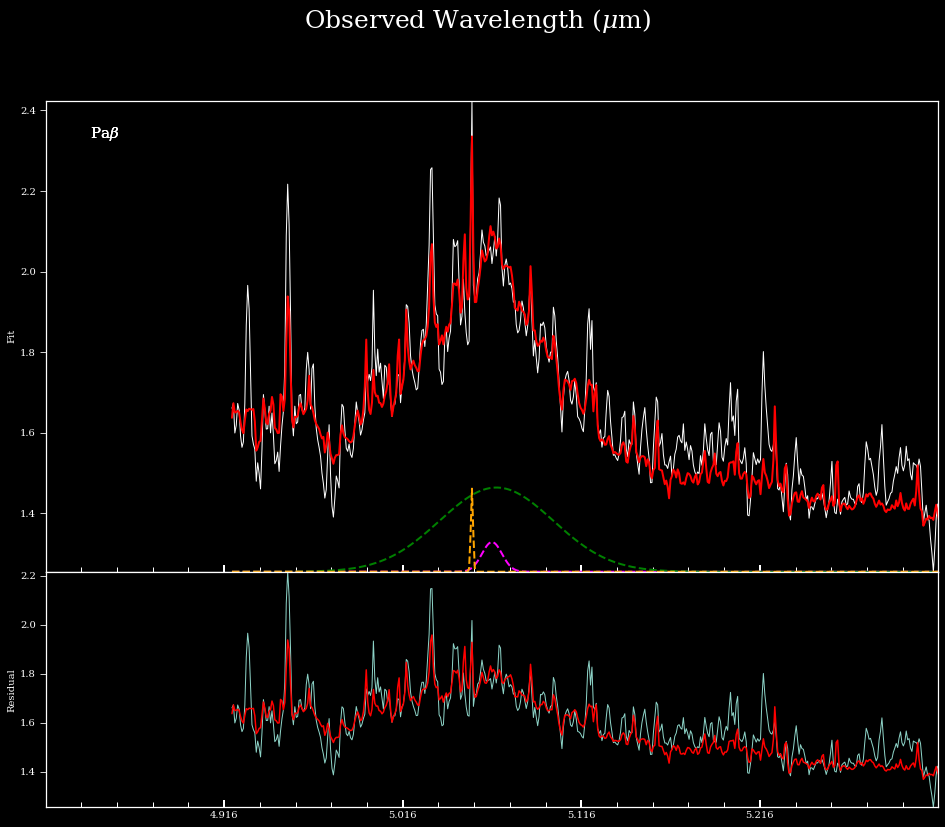

In [52]:
q3do.plot_line(q3di, plotargs=argsplotline)

#from matplotlib import pyplot as plt
#plt.plot(q3do.wave, q3do.spec, color='k')
#plt.plot(q3do.wave, q3do.cont_fit+q3do.line_fit, color='r')

#from q3dfit.q3dmath import cmplin
#flux1 = cmplin(q3do, '[NeVI]7.65', 0, velsig=True)
#flux2 = cmplin(q3do, '[NeVI]7.65', 1, velsig=True)
#plt.plot(q3do.wave, flux1)
#plt.plot(q3do.wave, flux2)
#print(flux1)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength.

In [53]:
argscontplot = dict()
argscontplot['xstyle'] = 'lin'
argscontplot['ystyle'] = 'lin'
argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

In [54]:
argscontplot['IR'] = True

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

Because we specified `decompose_qso_fit=True` in the `q3di` object, three plots are created: one for the host-only light, one for quasar-only light, and one for the total continuum.

True questfit


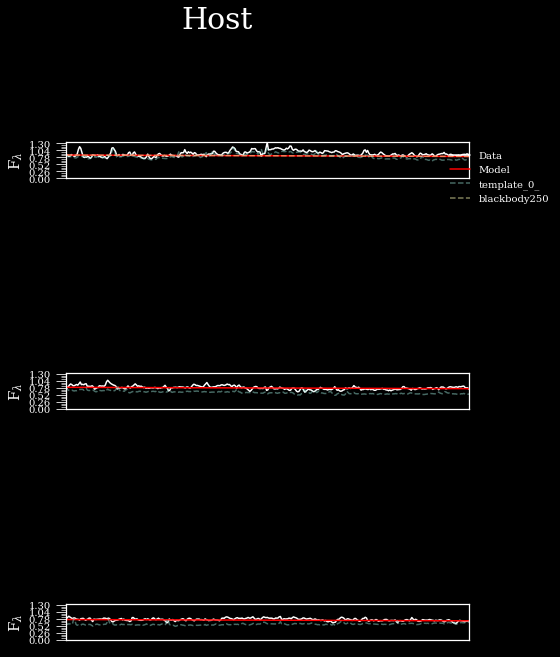

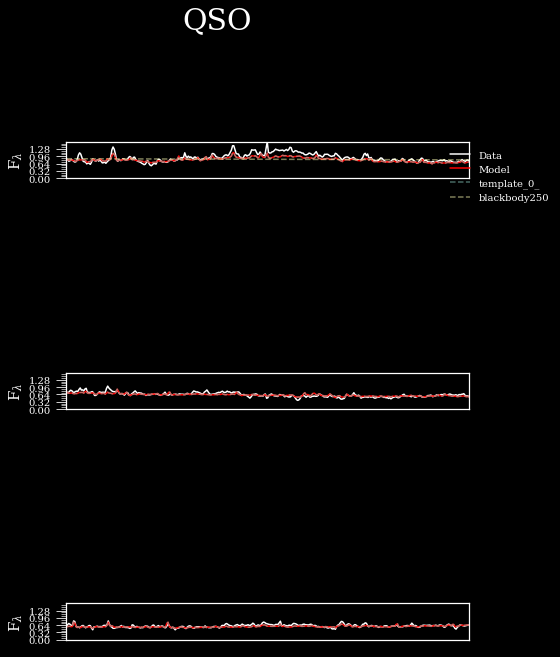

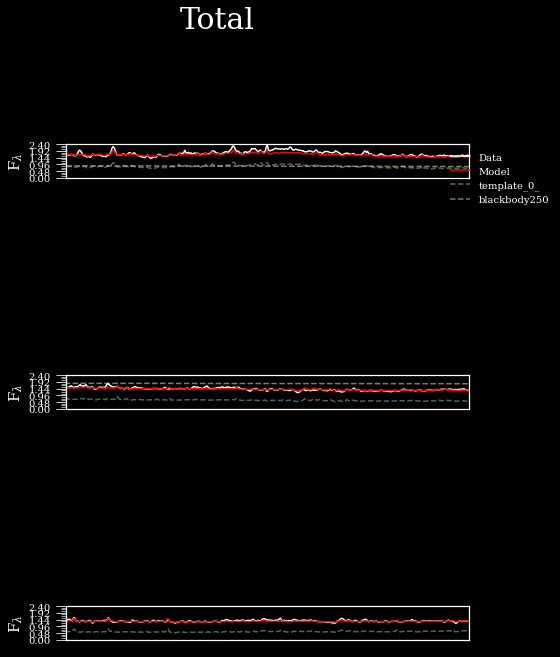

In [55]:
print(q3di.decompose_qso_fit, q3di.fcncontfit)
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

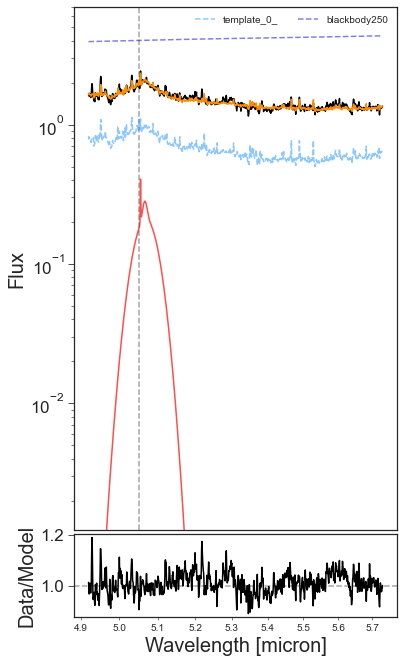

In [61]:
from q3dfit.plot import plotdecomp
plotdecomp(q3do, q3di, show=True, do_lines=True)


## 4. Combine fit results from all spaxels.<a class="anchor" id="chapter4"></a>

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files. This example assumes that the spaxels listed here in each dimension have been fit.

In [57]:
cols = [0,35]
rows = [18]
rows = [0,35]

cols = [15, 23]
rows = [15, 23]

cols = [10, 30]
rows = [10, 30]

from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows)

q3dcollect: Saving emission-line fit results into J1652/J1652.line.npz
q3dcollect: Saving continuum fit results into J1652/J1652.cont.npy


## 5. Plot science products. <a class="anchor" id="chapter5"></a>

These routines take the output of `q3dcollect` and process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [58]:
import q3dfit.q3dpro as q3dpro
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.025, NOCONT=True)

Start by plotting linemaps for [OIII], of both flux and velocity measures. The parameters listed below control the plotting.

In [59]:
wave0,linetext,dataOUT = qpro.get_linemap('Pab',LINEVAC=True,APPLYMASK=True)
dataOUT,ncomp = qpro.resort_line_components(dataOUT,NCOMP=q3di.ncomp)
print(dataOUT.keys())
print(dataOUT['Ftot']['data'])
data1 = dataOUT['Ftot']['data']
print(data1.shape)
print(np.sum(np.isnan(data1)))
#print(linemap['Ftot']['data'])
#import pdb; pdb.set_trace()

getting line data... Pab
dict_keys(['Ftot', 'Fci', 'Sig', 'v50', 'w80'])
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(43, 49)
1666


Plotting emission line maps
getting line data... Pab
Saving line map: J1652_Pab_Ftot_map.fits
Saving line map: J1652_Pab_Fci_c1_map.fits
Saving line map: J1652_Pab_Fci_c2_map.fits
Saving line map: J1652_Pab_Fci_c3_map.fits
Saving line map: J1652_Pab_Sig_c1_map.fits
Saving line map: J1652_Pab_Sig_c2_map.fits
Saving line map: J1652_Pab_Sig_c3_map.fits
Saving line map: J1652_Pab_v50_c1_map.fits
Saving line map: J1652_Pab_v50_c2_map.fits
Saving line map: J1652_Pab_v50_c3_map.fits
Saving line map: J1652_Pab_w80_c1_map.fits
Saving line map: J1652_Pab_w80_c2_map.fits
Saving line map: J1652_Pab_w80_c3_map.fits
Saving figure: Pab_emlin_map


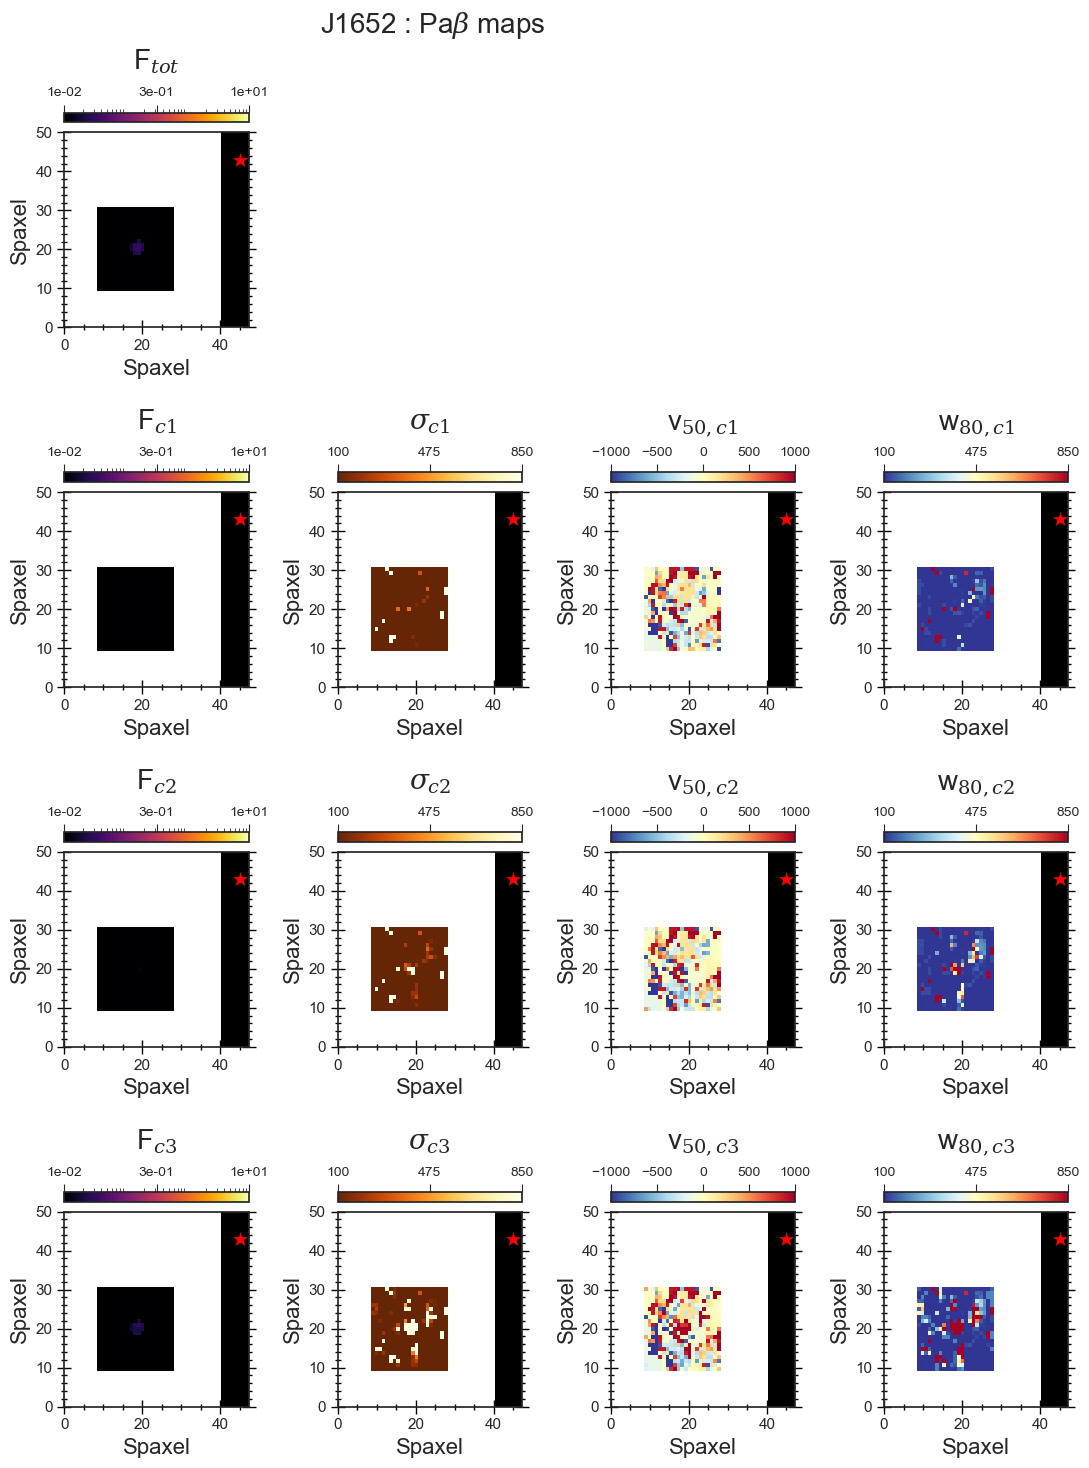

In [60]:
do_kpc = False
saveFile = True
flx = [1e-2,1e1]
qsocenter = [45., 43.]
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[100.,850.],
          'v50':[-1000.,1000.],
          'w80':[100.,850.],
          'fluxlog': True}
qpro.make_linemap('Pab', XYSTYLE=do_kpc, xyCenter=qsocenter,
                  SAVEDATA=saveFile, VMINMAX=pltarg, PLTNUM=1, CMAP='inferno')

Map of [OIII]/H$\beta$ for each component, and for the total flux:

In [37]:
qpro.make_lineratio_map('[OIII]5007', 'Hbeta', VMINMAX=[0,1])

TypeError: 'NoneType' object is not subscriptable

Map of v50 over the cumulative velocity distribution:

In [ ]:
from q3dfit.q3dpro import OneLineData
o3data = OneLineData(qpro.linedat, '[OIII]5007')
o3data.calc_cvdf(2.9489, [-1e3, 1e3], vstep=5)
o3data.make_cvdf_map(50., velran=[-1e3, 1e3], markcenter=[45., 43.],
                     outfile=True)

Map of W80 over the cumulative velocity distribution:

In [ ]:
from matplotlib.pyplot import *
imshow(o3data.calc_cvdf_vel(90, calc_from_posvel=False).T - o3data.calc_cvdf_vel(10, calc_from_posvel=False).T, 
       origin='lower', cmap='bwr', vmin=50, vmax=1500)
colorbar()